# 统计学习导论第二十次作业
<mark>姓名：欧阳瑞志、班级：统计22、学号：220403102</mark>  

作业任务：CTR
- **机器学习模型**：
    - [Dummy Classifier（基模型）](#1)
    - [Logistic回归（Imbalanced Data）](#2)
    - [Logistic回归（Balanced Data）](#3)
    - [决策树（Imbalanced Data）](#4)
    - [决策树（Balanced Data）](#5)
    - [随机森林（Imbalanced Data）](#6)
    - [随机森林（Balanced Data）](#7) 
- **深度学习CTR模型**：
    - [AFM](#8)
    - [DCN](#9)
    - [DCN-Mix](#10)
    - [DeepFM](#11)
    - [xDeepFM](#12)
    - [AutoInt](#13)
    - [ONN](#14)
    - [FiBiNET](#15)  

模型评价：采用更为激进的**Lift曲线**，因为即使点击率小于0.5也考虑推荐  
依赖库：[DeepCTR-Torch](https://deepctr-torch.readthedocs.io/en/doc/index.html)  
本课程全部作业：https://github.com/ouyangruizhi/Machine-Learning

## 一、数据导入
**数据来源**：kaggle 2015年竞赛[Click-Through Rate Prediction](https://www.kaggle.com/competitions/avazu-ctr-prediction)  
数据量太大了，原始数据有**四千万多**数据，从总体中抽取**五百万**样本实验

In [1]:
####--------------------------------统计学习导论第二十次作业——CTR点击率预测模型--------------------------------####

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(font_scale=1)
pd.set_option('display.max_columns', 0) # 显示所有列
pd.options.display.float_format = '{:.2f}'.format # 保留两位小数
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import AFM, DCN, DCNMix, DeepFM, xDeepFM, AutoInt, ONN, FiBiNET
import random
import category_encoders as ce
import math

####--------------------------------------------1、数据导入--------------------------------------------####

## 数据来源：kaggle 2015年竞赛【Click-Through Rate Prediction】
## 数据地址：https://www.kaggle.com/competitions/avazu-ctr-prediction

## 训练数据导入
## 数据集太大，两次抽样，确保分布一致
parse_date = lambda val : pd.to_datetime(val, format='%y%m%d%H')

# 数据集全部数据中抽取 5000000 样本
num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
train = pd.read_csv("/Users/ouyangruizhi/Desktop/python/统计学习导论/CTR点击率预测/train.gz", parse_dates=['hour'], date_parser=parse_date,\
                     skiprows=skip_values)

# ## 导入全部数据
# train = pd.read_csv("/Users/ouyangruizhi/Desktop/python/统计学习导论/CTR点击率预测/train.gz", parse_dates=['hour'], date_parser=parse_date)

print('前五行数据：')
train.head()

前五行数据：


id  click       hour    C1  ...  C18  C19     C20  C21
0  10000371904215119486      0 2014-10-21  1005  ...    0   35  100084   79
1  10000949271186029916      1 2014-10-21  1005  ...    0   35      -1   79
2  10004482643316086592      0 2014-10-21  1005  ...    3  163  100088   61
3  10004510652136496837      0 2014-10-21  1005  ...    0   39      -1  157
4  10005541670676403131      0 2014-10-21  1005  ...    0  551  100217   46

[5 rows x 24 columns]

## 二、特征工程
### 2.1 数据探索与预处理
#### 2.1.1 拆分变量hour

In [2]:
####--------------------------------------------2、特征工程--------------------------------------------####
## 2.1 数据探索与预处理

# 将hour这个字段拆分
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
train.head()

id  click       hour    C1  ...  C21 dayofweek day hour_time
0  10000371904215119486      0 2014-10-21  1005  ...   79         1  21         0
1  10000949271186029916      1 2014-10-21  1005  ...   79         1  21         0
2  10004482643316086592      0 2014-10-21  1005  ...   61         1  21         0
3  10004510652136496837      0 2014-10-21  1005  ...  157         1  21         0
4  10005541670676403131      0 2014-10-21  1005  ...   46         1  21         0

[5 rows x 27 columns]

#### 2.1.2 缺失值检测

In [3]:
# 缺失值检测
print('全部缺失值数量：', train.isnull().sum())

全部缺失值数量： id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dayofweek           0
day                 0
hour_time           0
dtype: int64


结果表明：无缺失值
#### 2.1.3 数据类型

In [4]:
# 数据类型
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint64        
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19     

#### 2.1.4 描述性统计

In [5]:
# 描述性统计
train.describe()

id      click  ...        day  hour_time
count              5000000.00 5000000.00  ... 5000000.00 5000000.00
mean   9220579023838202880.00       0.17  ...      25.47      11.28
min          1296228608365.00       0.00  ...      21.00       0.00
25%    4608310502662338560.00       0.00  ...      23.00       6.00
50%    9223466441721829376.00       0.00  ...      26.00      11.00
75%   13831325114960699392.00       0.00  ...      28.00      16.00
max   18446743910940219392.00       1.00  ...      30.00      23.00
std    5324986349474344960.00       0.38  ...       2.96       5.95

[8 rows x 18 columns]

**由描述性统计结果，分析得出：'C15', 'C16', 'C19', 'C21'可能存在异常值**

#### 2.1.5 异常值检测
知道'C15', 'C16', 'C19', 'C21'并不服从正态分布，因此不使用3sigma法则处理异常值  
先采用更为严格的四分位数IQR检测

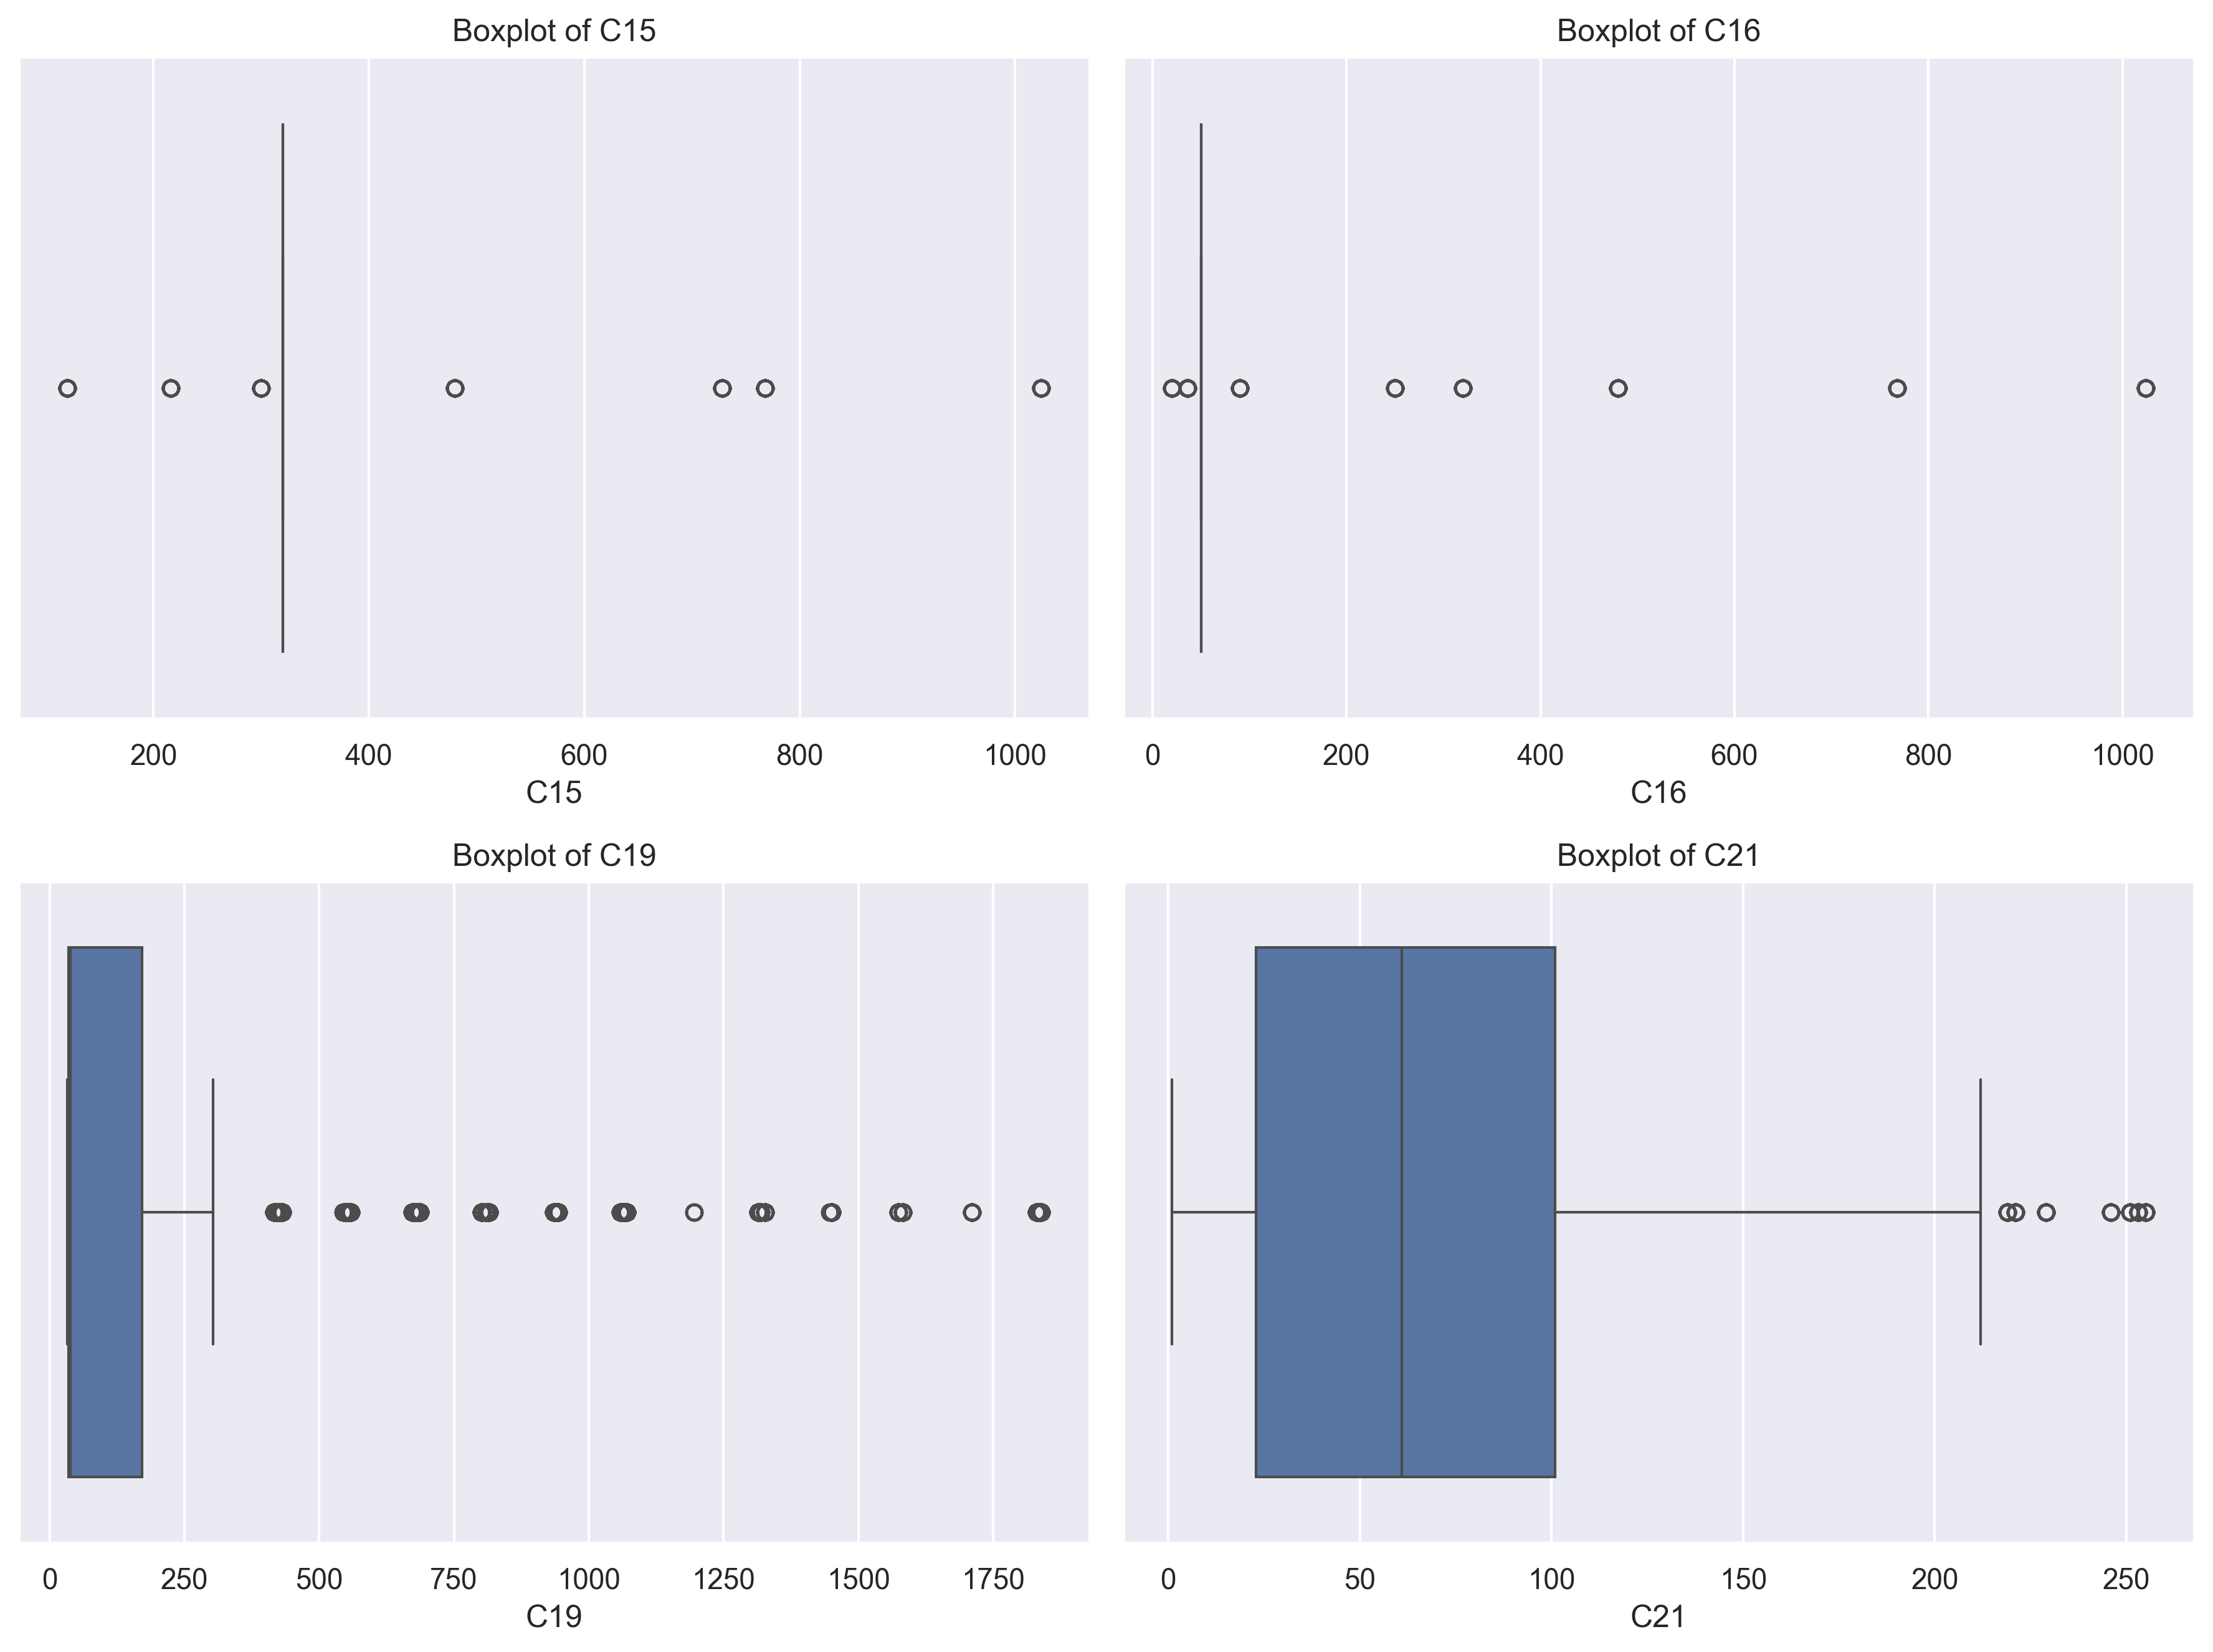

In [6]:
# 异常值处理
# 知道'C15', 'C16', 'C19', 'C21'并不服从正态分布，因此不使用3sigma法则处理异常值
# 箱线图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9), dpi=300)

g_C15_box = sns.boxplot(data=train, x='C15', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of C15')

g_C16_box = sns.boxplot(data=train, x='C16', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of C16')

g_C19_box = sns.boxplot(data=train, x='C19', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of C19')

g_C21_box = sns.boxplot(data=train, x='C21', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of C21')

plt.tight_layout()
plt.savefig(fname="箱线图.png")

**箱线图表明：对于这个数据量IQR还是太严格了，使用98分位数，超出部分用98分位数代替**

In [7]:
col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = train[col].quantile(0.98)
    if train[col].quantile(0.98) < 0.5 * train[col].max():
        train[col][train[col] >= percentiles] = percentiles

#### 2.1.6 分布探索
##### 分离数值型数据变量和分类型数据变量
为了方便分布探索，将变量按数值型数据和分类型数据分离

In [8]:
# 分离数值型和分类型变量
numerical = []
categorical = []

for col in (train.columns):
    if train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("数值型数据有：",numerical)
print("\n 分类数据有：",categorical)

数值型数据有： ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'dayofweek', 'day', 'hour_time']

 分类数据有： ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


##### 输出数据click分布探索

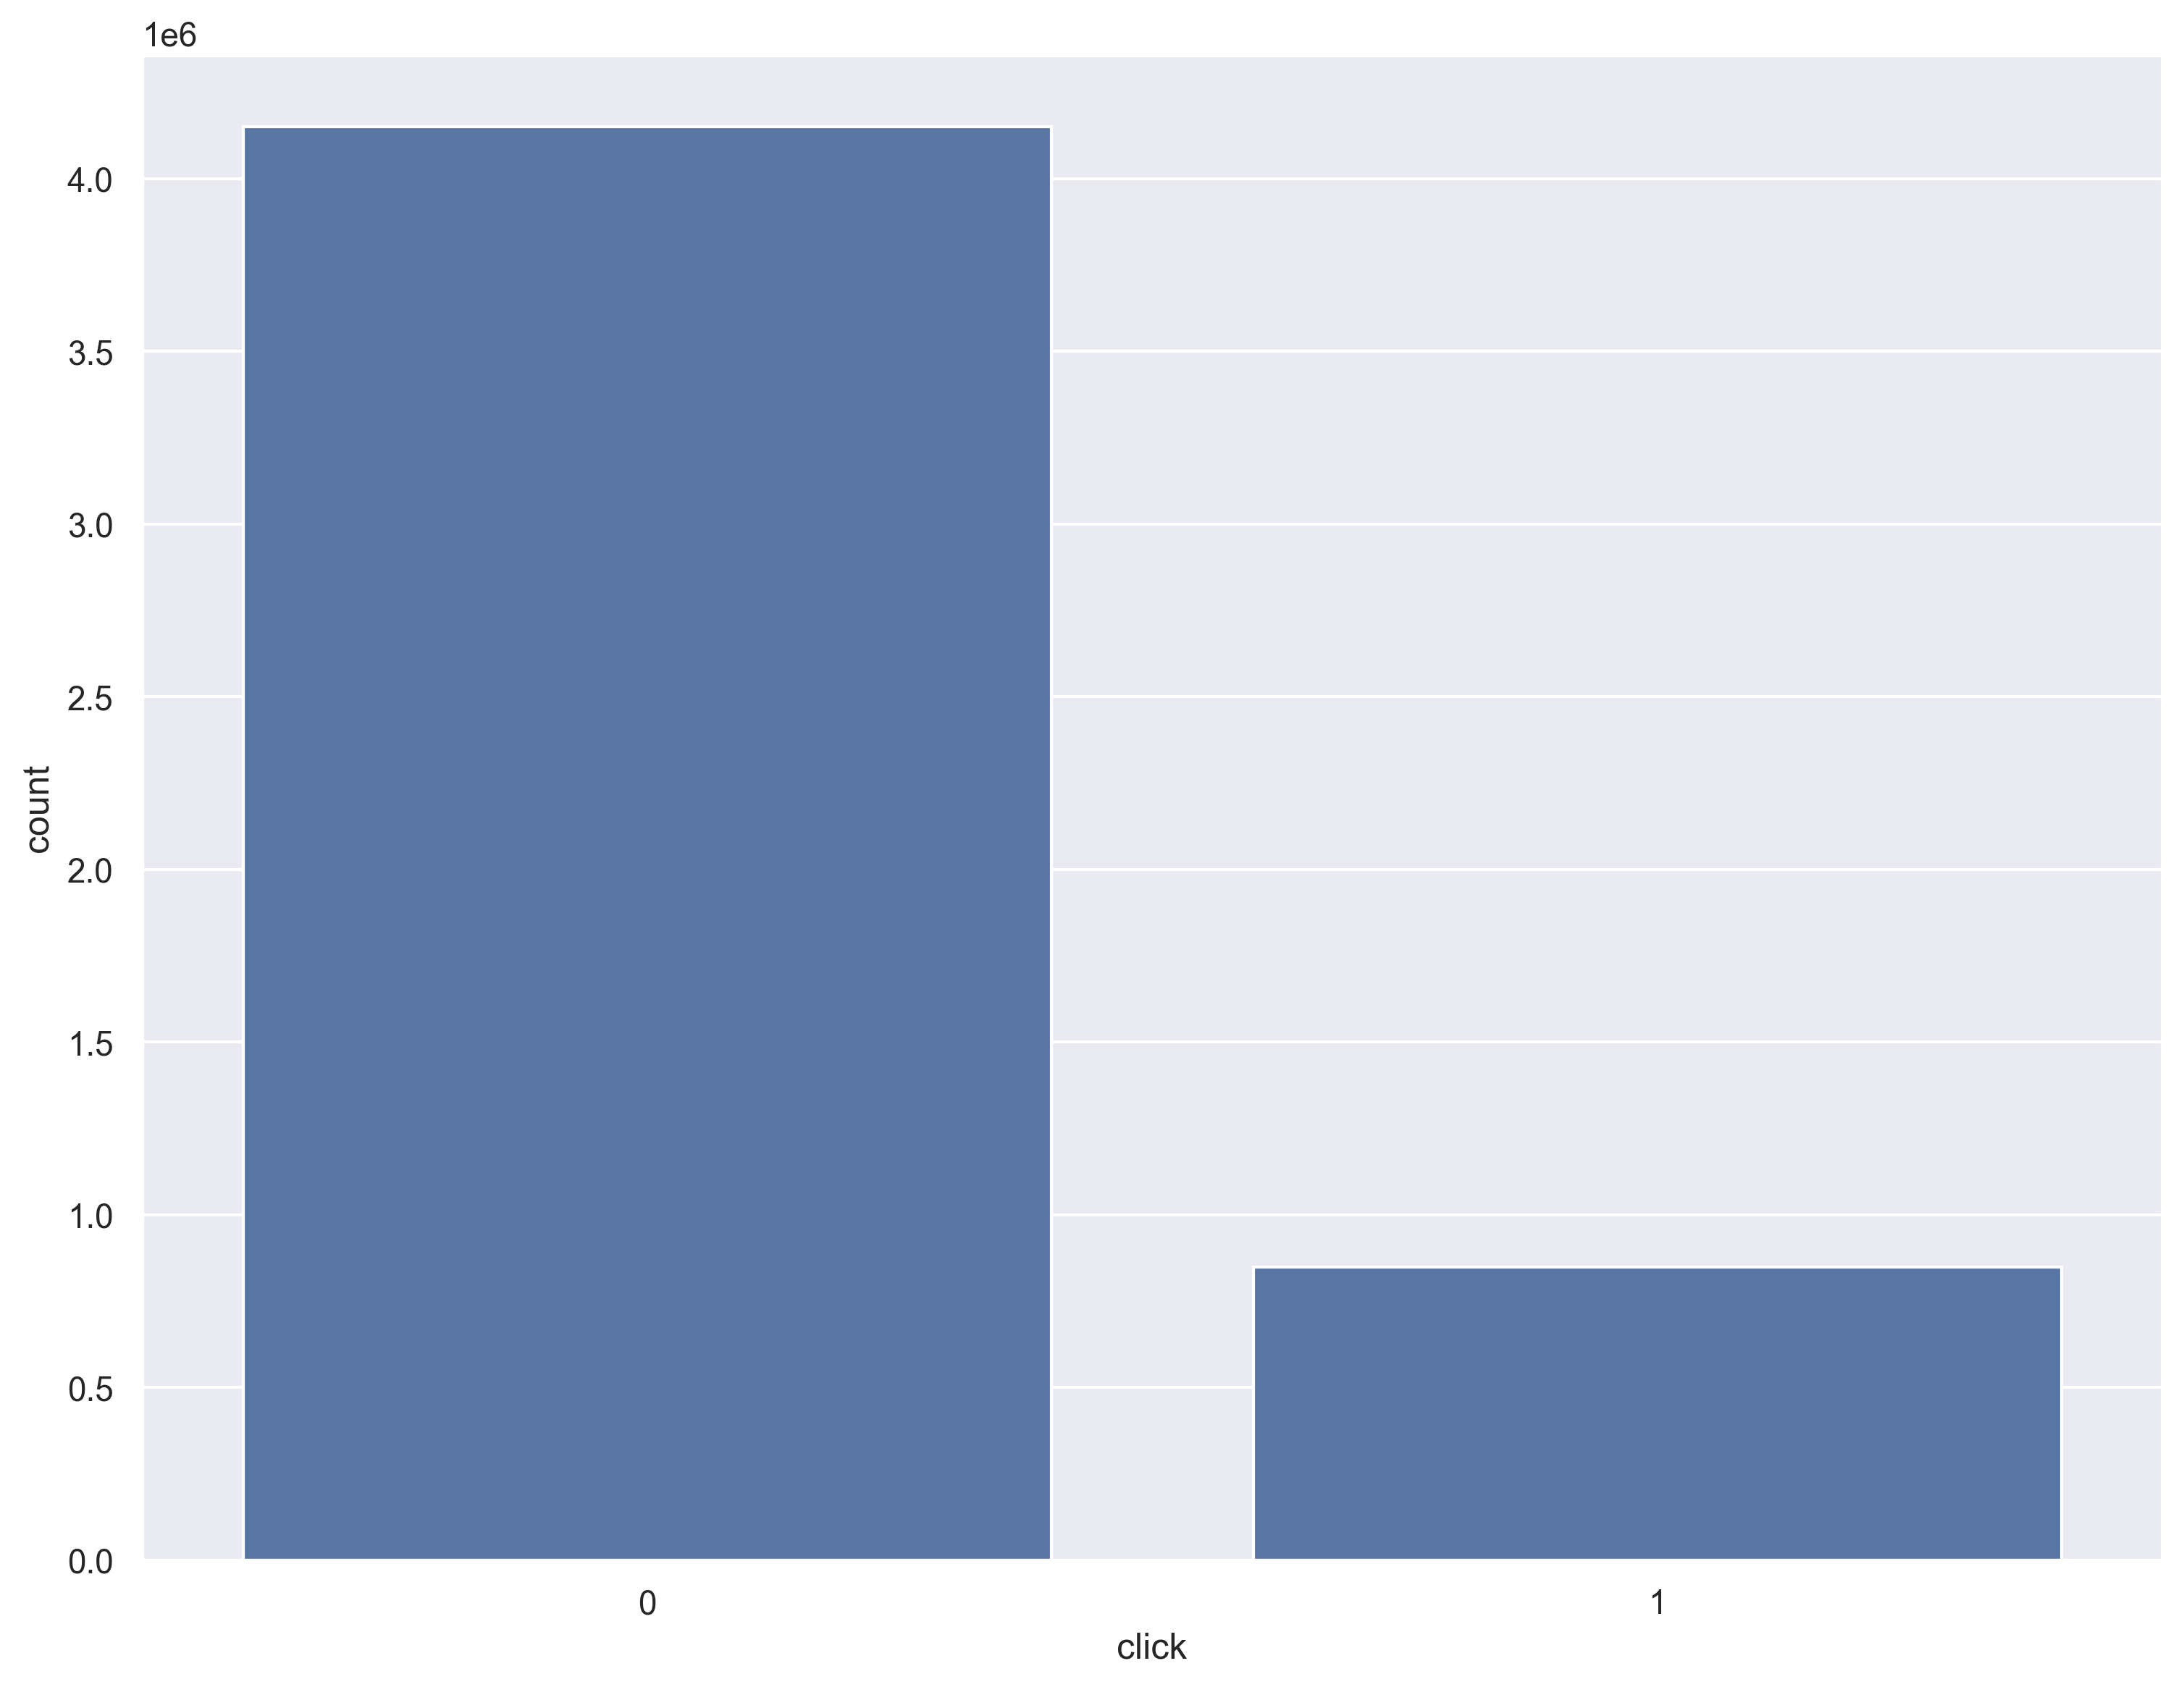

In [9]:
# click结果分布探索
plt.figure(figsize=(12, 9), dpi=300)
sns.countplot(x='click', data=train)
plt.savefig(fname="click分布.png")

##### 输入特征分类数据探索
数据种类太多了，都是几千个画不了柱状图了，只能看看有多少种类和他们的比例

In [10]:
# 分类数据探索
# 数据种类太多了，都是几千个画不了柱状图了，只能看看有多少种类和他们的比例
print("site_id共有", len(train['site_id'].unique()), '个不一样的值')
print(train['site_id'].value_counts(normalize = True))
print("======================")

print("ite_domain共有", len(train['site_domain'].unique()), '个不一样的值')
print(train['site_domain'].value_counts(normalize = True))
print("======================")

print("site_category共有", len(train['site_category'].unique()), '个不一样的值')
print(train['site_category'].value_counts(normalize = True))
print("======================")

print("app_id共有", len(train['app_id'].unique()), '个不一样的值')
print(train['app_id'].value_counts(normalize = True))
print("======================")

print("app_domain共有", len(train['app_domain'].unique()), '个不一样的值')
print(train['app_domain'].value_counts(normalize = True))
print("======================")

print("app_category共有", len(train['app_category'].unique()), '个不一样的值')
print(train['app_category'].value_counts(normalize = True))
print("======================")

print("device_id共有", len(train['device_id'].unique()), '个不一样的值')
print(train['device_id'].value_counts(normalize = True))
print("======================")

print("device_ip共有", len(train['device_ip'].unique()), '个不一样的值')
print(train['device_ip'].value_counts(normalize = True))
print("======================")

print("device_model共有", len(train['device_model'].unique()), '个不一样的值')
print(train['device_model'].value_counts(normalize = True))
print("======================")

site_id共有 3568 个不一样的值
site_id
85f751fd   0.36
1fbe01fe   0.16
e151e245   0.07
d9750ee7   0.02
5b08c53b   0.02
           ... 
eddd0239   0.00
5f4102a4   0.00
dafbd312   0.00
3d777827   0.00
5fde0f3e   0.00
Name: proportion, Length: 3568, dtype: float64
ite_domain共有 4501 个不一样的值
site_domain
c4e18dd6   0.37
f3845767   0.16
7e091613   0.08
7687a86e   0.03
98572c79   0.02
           ... 
594e142d   0.00
63b5a112   0.00
bfff041e   0.00
1cc86351   0.00
042c1b06   0.00
Name: proportion, Length: 4501, dtype: float64
site_category共有 24 个不一样的值
site_category
50e219e0   0.41
f028772b   0.31
28905ebd   0.18
3e814130   0.08
f66779e6   0.01
75fa27f6   0.00
335d28a8   0.00
76b2941d   0.00
c0dd3be3   0.00
72722551   0.00
dedf689d   0.00
70fb0e29   0.00
0569f928   0.00
8fd0aea4   0.00
a818d37a   0.00
42a36e14   0.00
e787de0e   0.00
bcf865d9   0.00
5378d028   0.00
9ccfa2ea   0.00
c706e647   0.00
da34532e   0.00
74073276   0.00
110ab22d   0.00
Name: proportion, dtype: float64
app_id共有 5188 个不一样的值
app_id
ec

##### 输入特征数值型数据探索

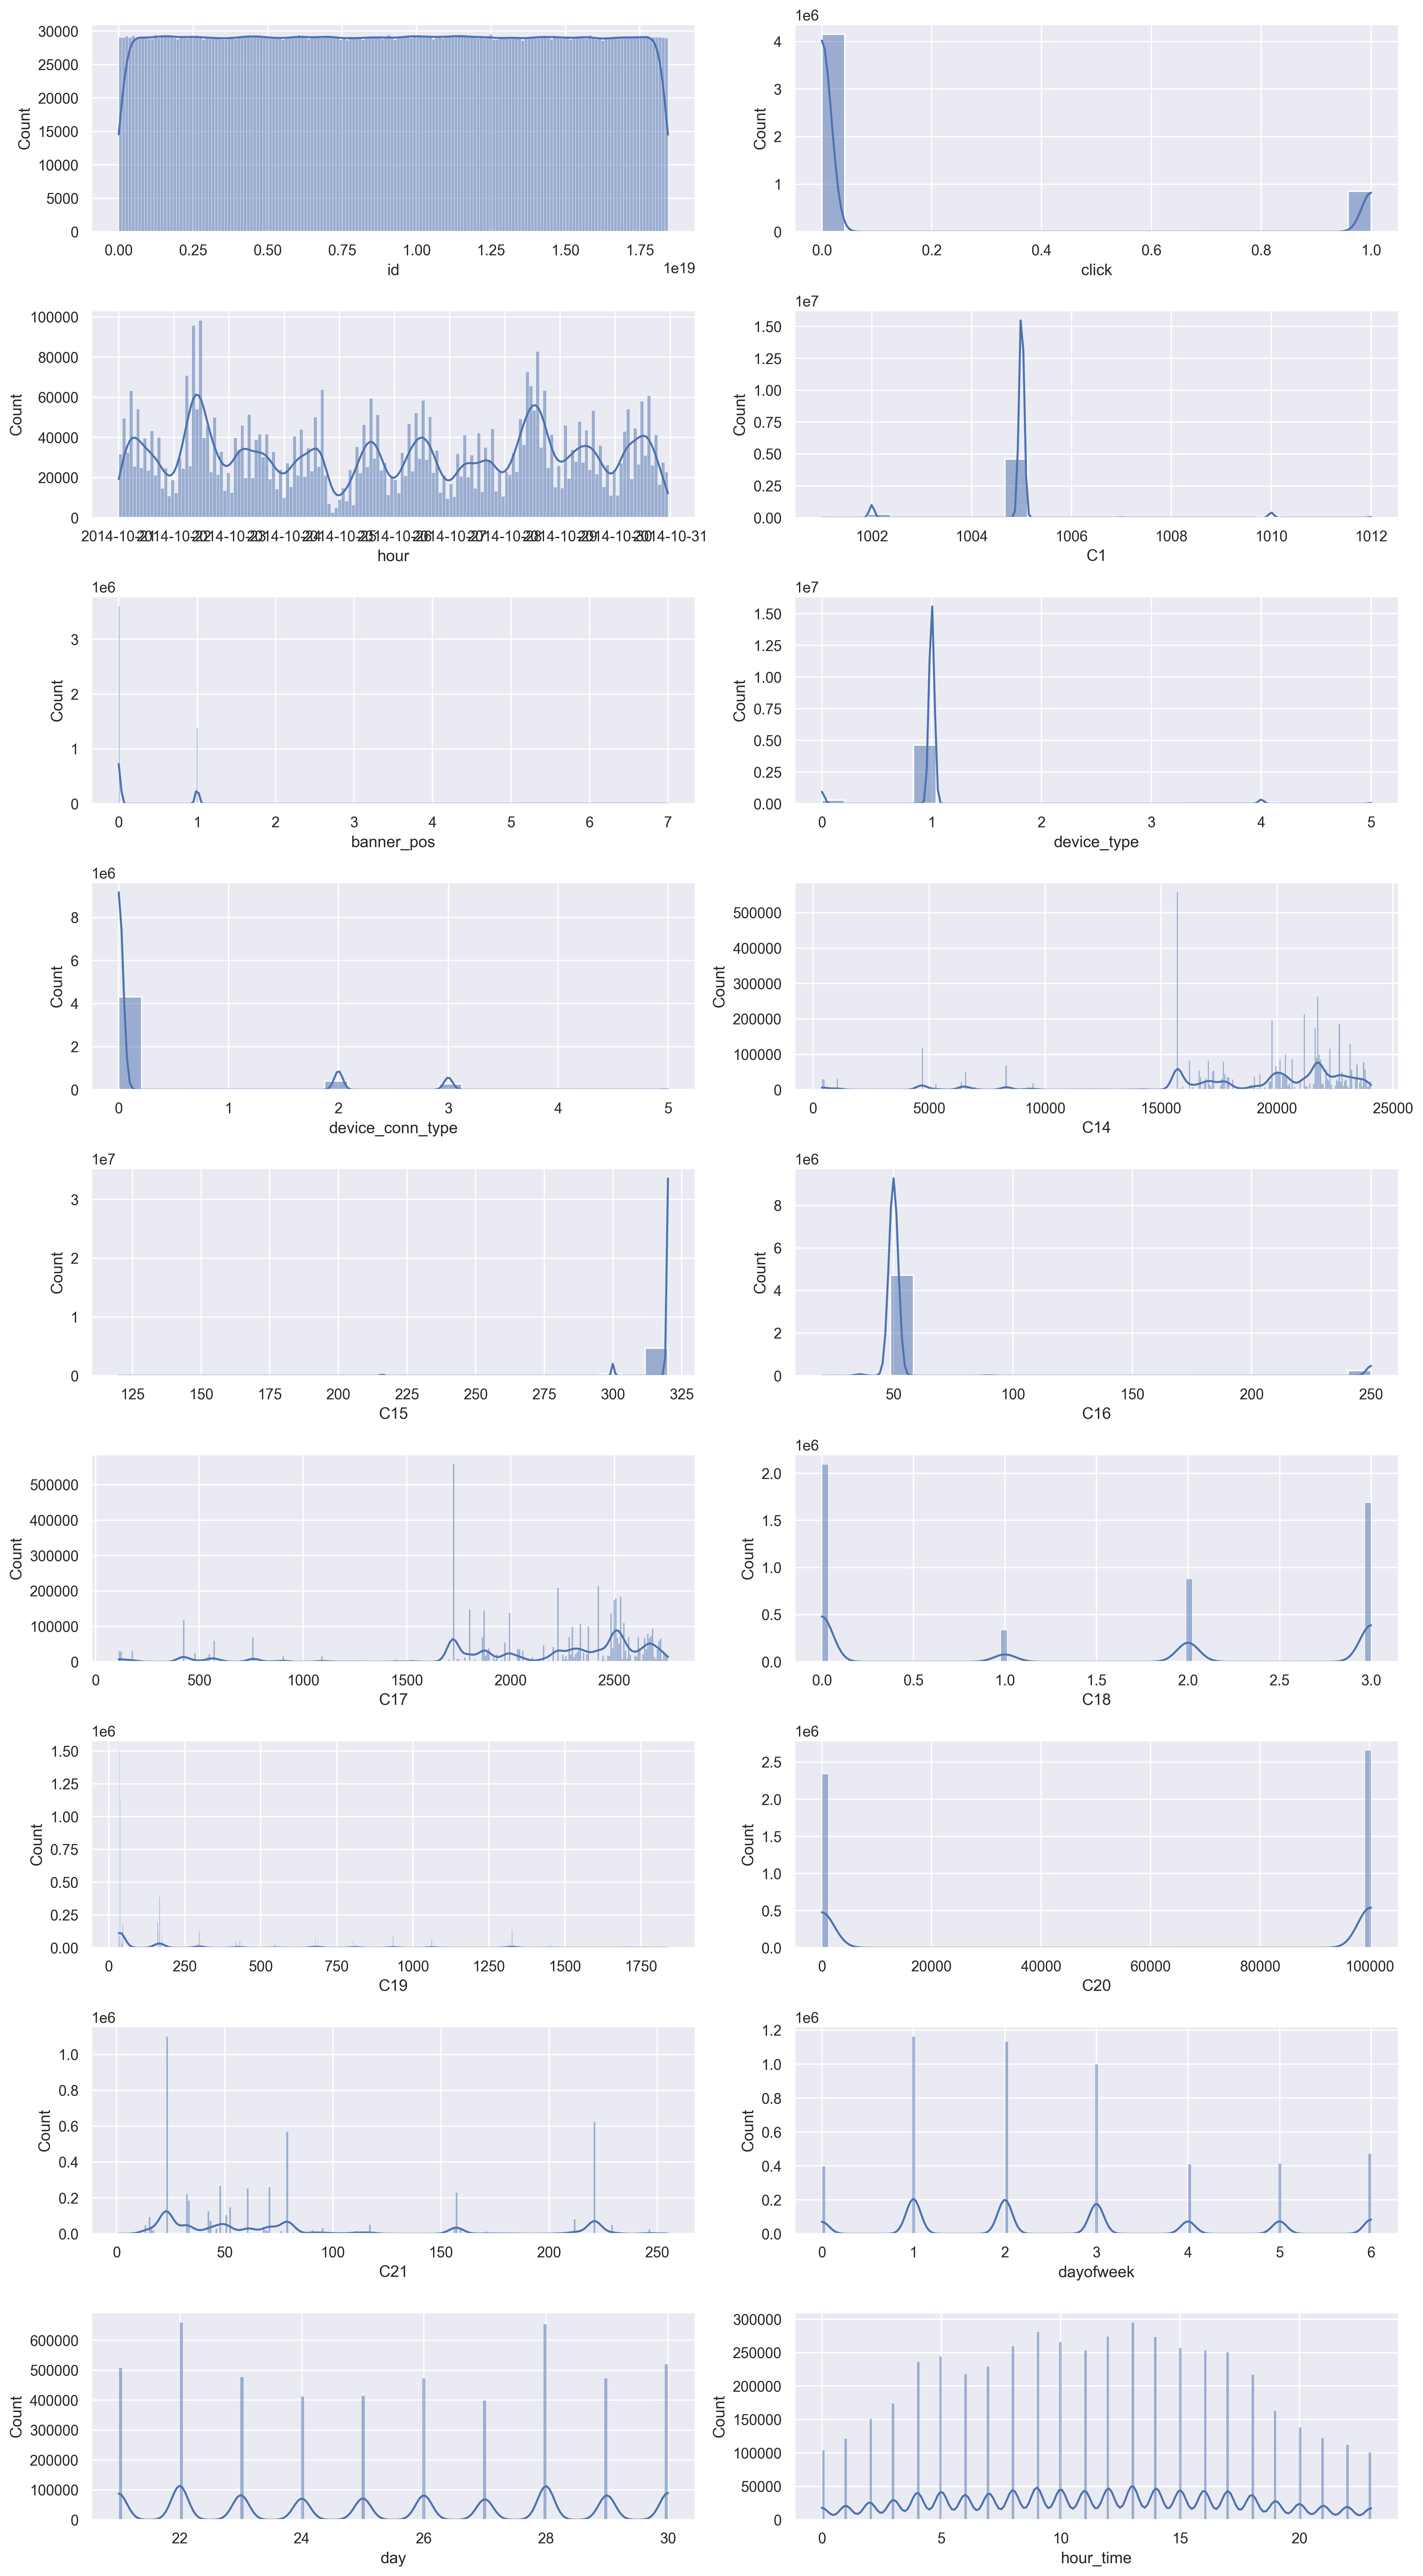

In [11]:
# 数值型数据探索
n = 2
plt.figure(figsize=[15,3*math.ceil(len(numerical)/n)], dpi=300)

for i in range(len(numerical)):
    plt.subplot(math.ceil(len(numerical)/n),n,i+1)
    sns.histplot(train[numerical[i]], kde=True)

plt.tight_layout()
plt.savefig(fname="数值型数据分布.png")

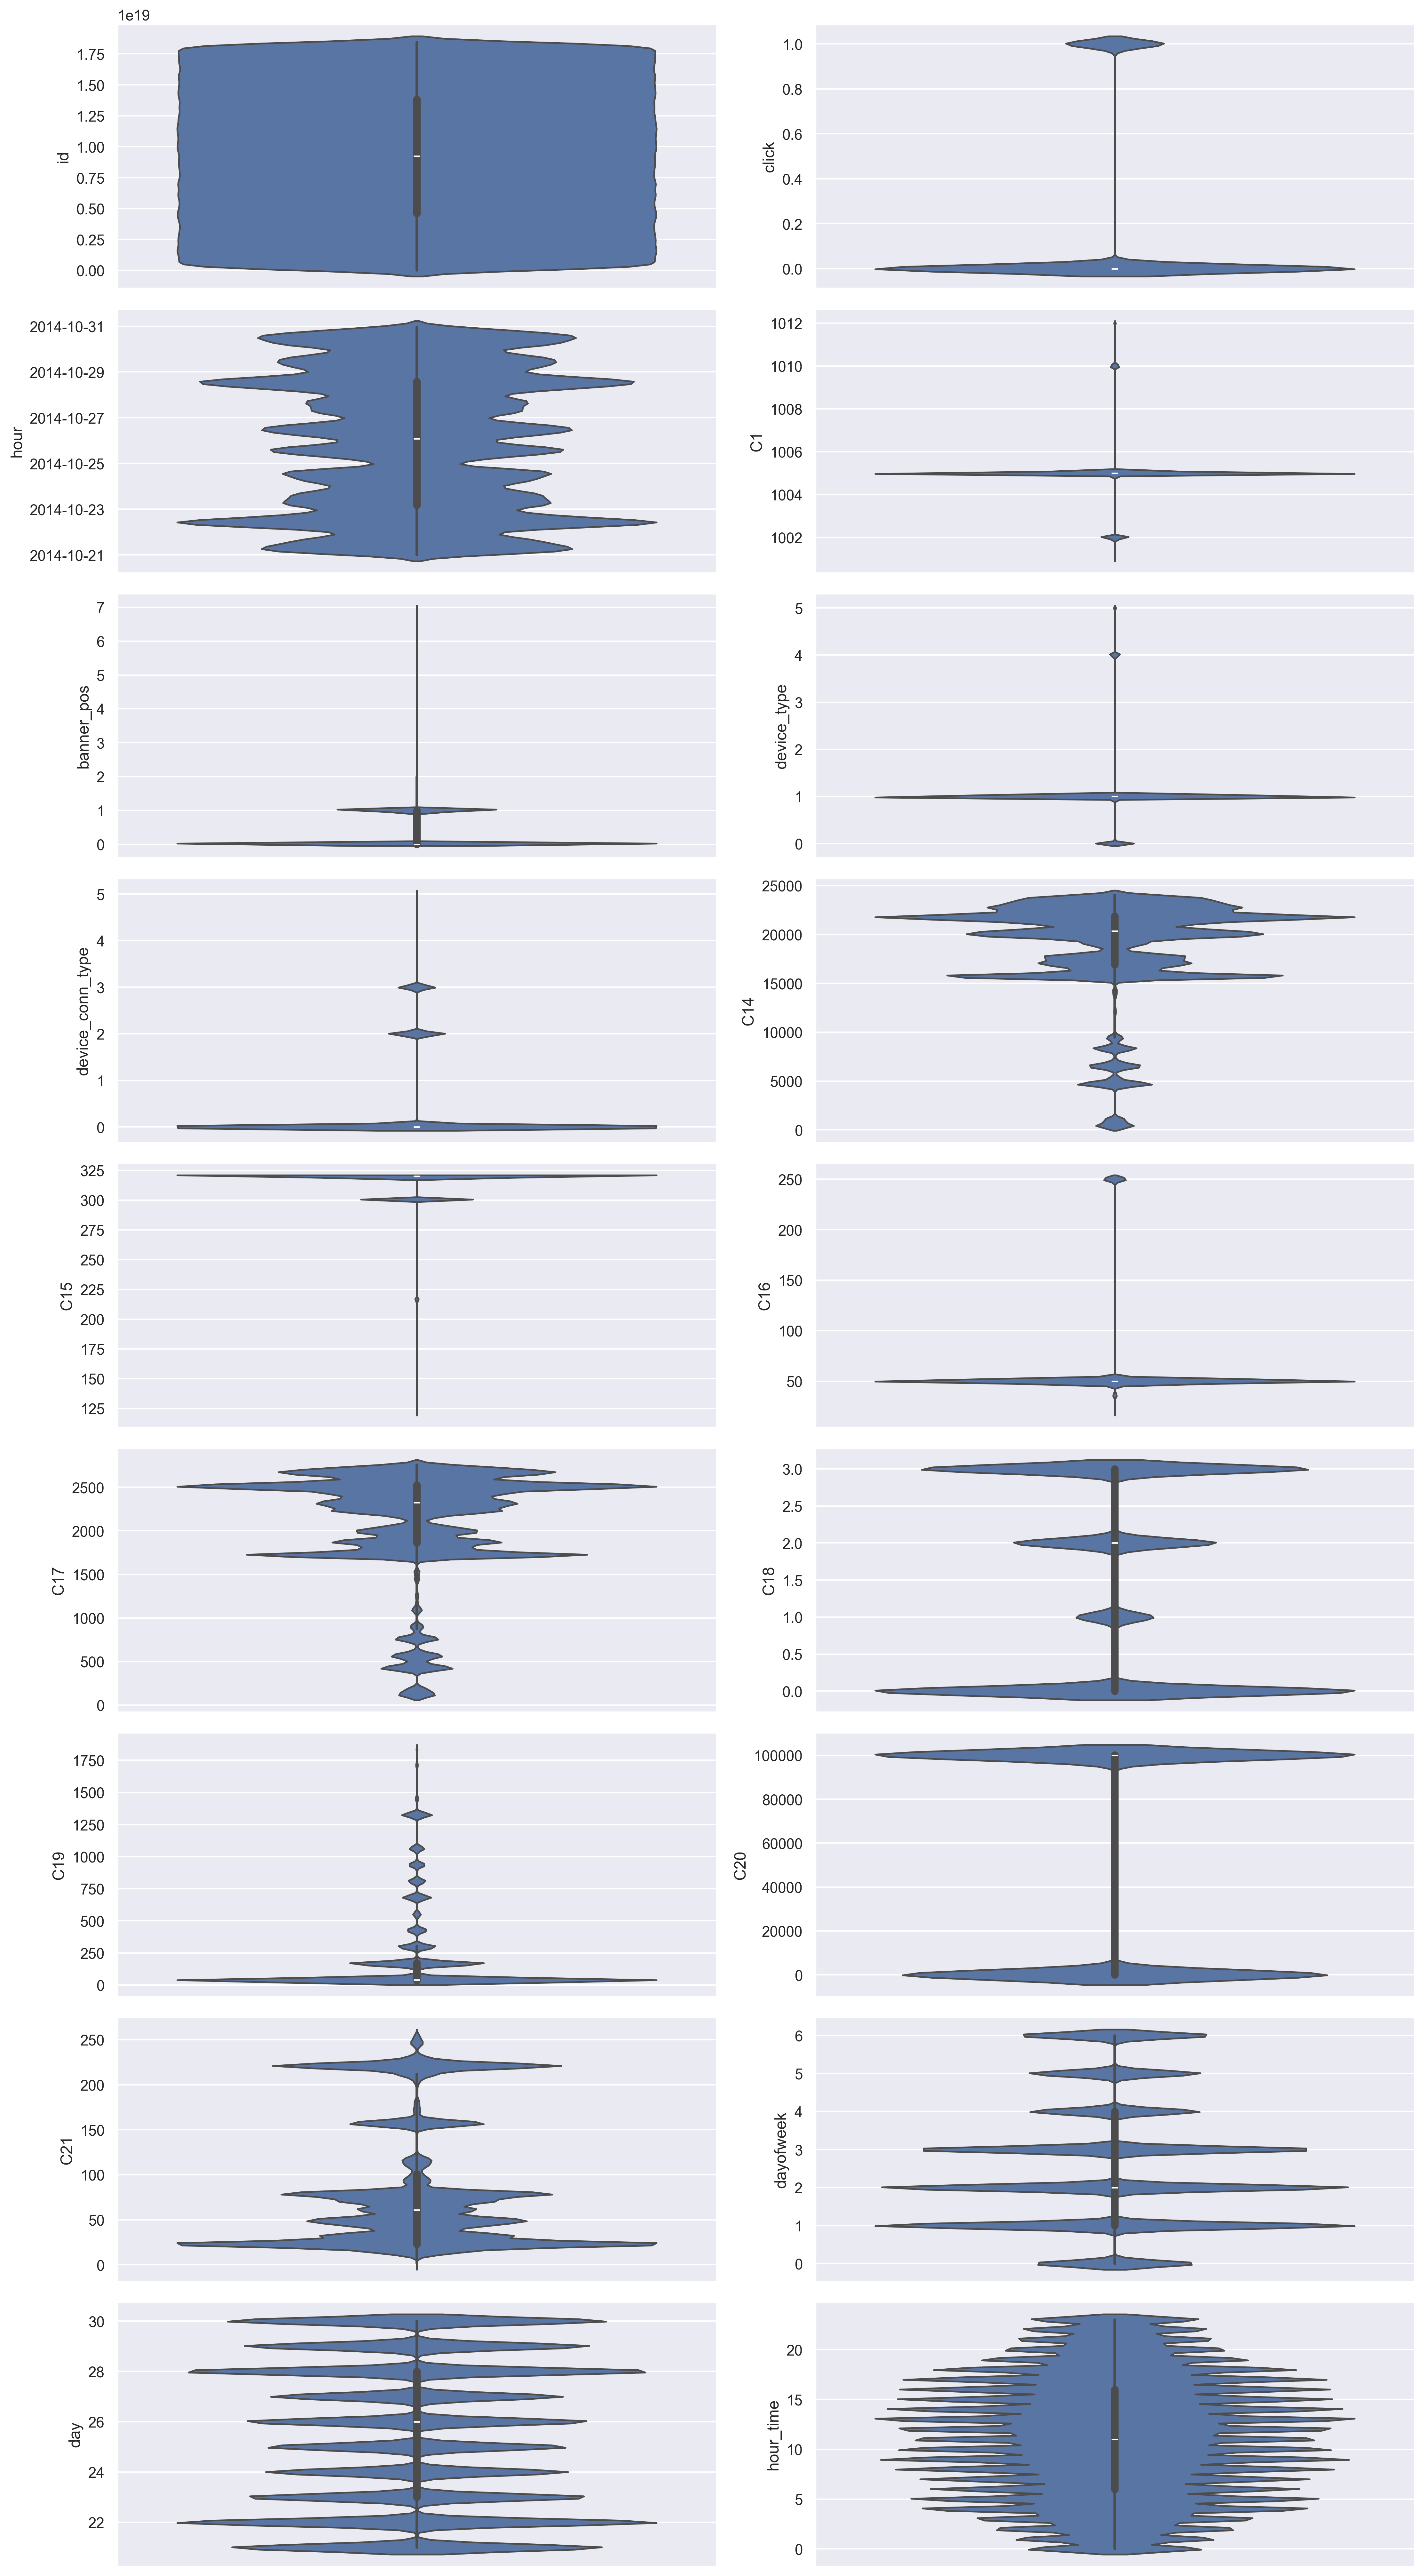

In [12]:
n = 2
plt.figure(figsize=[15,3*math.ceil(len(numerical)/n)], dpi=300)

for i in range(len(numerical)):
    plt.subplot(math.ceil(len(numerical)/n),n,i+1)
    sns.violinplot(y=train[numerical[i]])

plt.tight_layout()
plt.savefig(fname="数值型数据分布_小提琴图.png")

好像分布有点奇怪，至少确定不是正态分布
### 2.2 特征过滤
#### 2.2.1 相关系数
##### Pearson相关系数

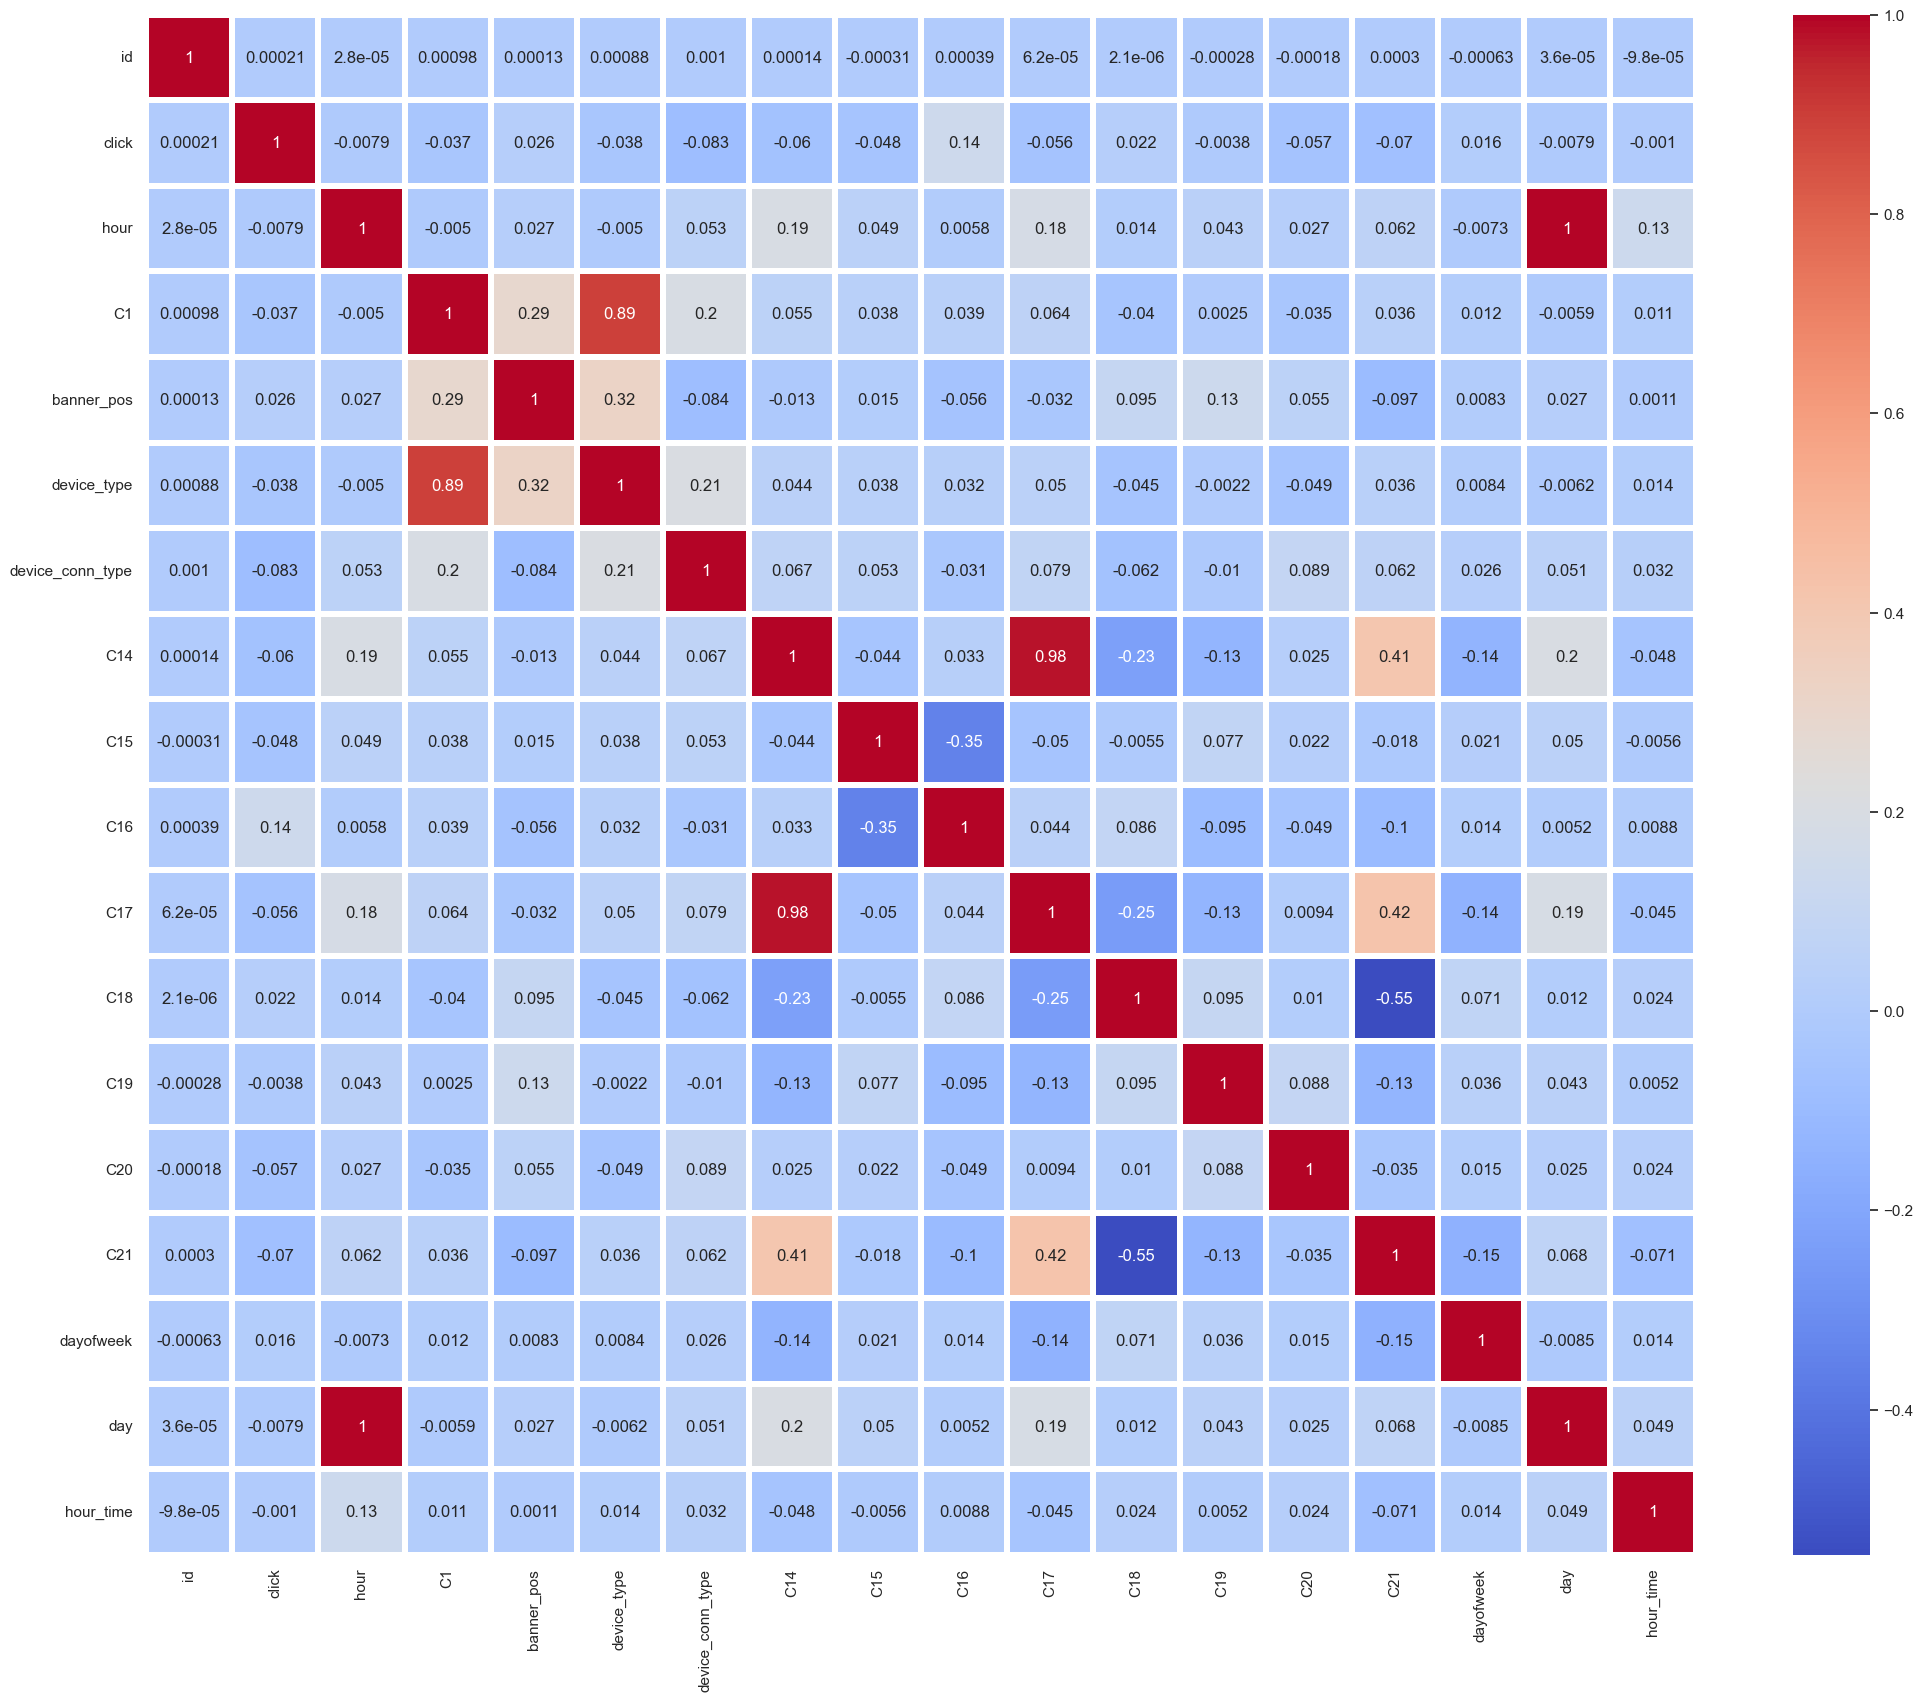

In [13]:
## 2.2 变量过滤
# Pearson相关系数
corr = train[numerical].corr()
f, ax = plt.subplots(figsize=(25,20))
sns.heatmap(corr, ax=ax, annot=True, linewidths=3, cmap='coolwarm')
plt.savefig(fname="Pearson相关系数热图.png")

##### Spearman相关系数
数据不满足正态分布，用非参的Spearman更合适

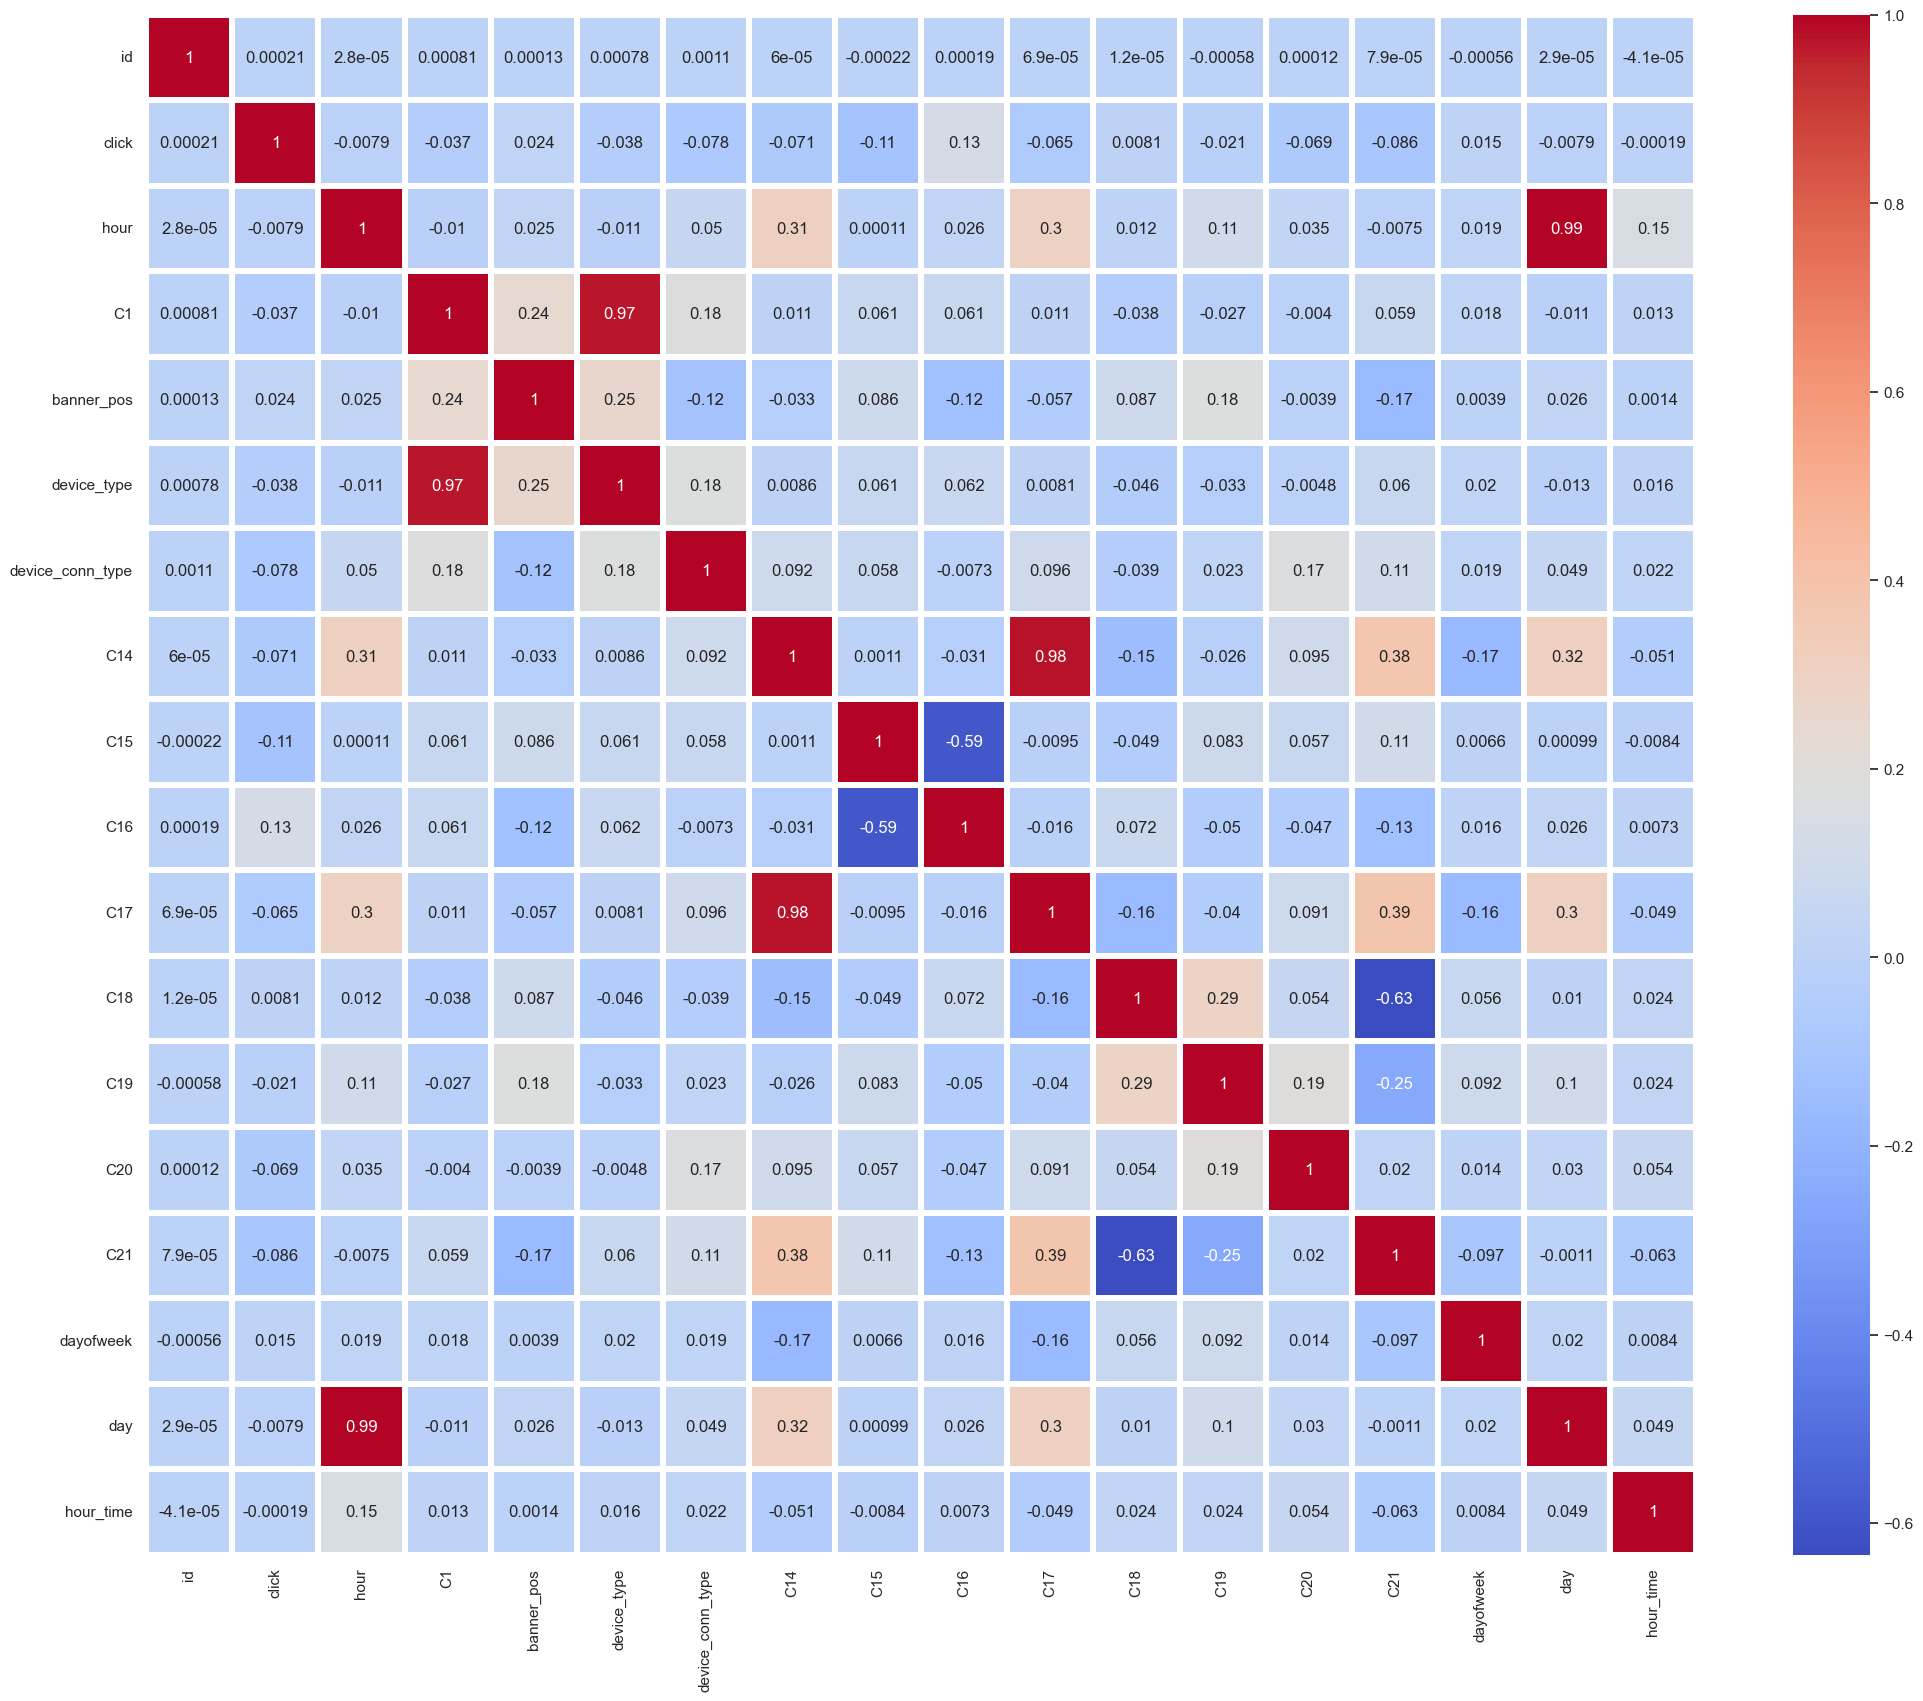

In [14]:
# Spearman相关系数
corr = train[numerical].corr(method='spearman')
f, ax = plt.subplots(figsize=(25,20))
sns.heatmap(corr, ax=ax, annot=True, linewidths=3, cmap='coolwarm')
plt.savefig(fname="Spearman相关系数热图.png")

#### 2.2.2 异常特征过滤
删除C20，因为它有近47%的值为-1。作为分类变量，它的值不应为-1  
删除hour，因为最开始已经分解了hour

In [15]:
train.drop(['C20', 'hour'], axis=1, inplace=True)

#### 2.2.3 数值型特征低方差过滤法

In [16]:
# 数值型数据低方差过滤法
print("原始数据形状：", train.shape)
numerical = [col for col in numerical if col!= 'click' and col != 'C20' and col != 'hour']

threshold = 0.05 # 阈值

selector = VarianceThreshold(threshold=threshold)
selector.fit(train[numerical])
selected_columns = train[numerical].columns[selector.get_support()]
train_low_var = train[['click'] + list(selected_columns) + list(categorical)]

print("经过低方差过滤后的数据形状：", train_low_var.shape)
print('所包含的变量', train_low_var.columns)
train_low_var.head()

原始数据形状： (5000000, 25)
经过低方差过滤后的数据形状： (5000000, 25)
所包含的变量 Index(['click', 'id', 'C1', 'banner_pos', 'device_type', 'device_conn_type',
       'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day',
       'hour_time', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model'],
      dtype='object')


click                    id    C1  ...  device_id  device_ip  device_model
0      0  10000371904215119486  1005  ...   a99f214a   b3cf8def      8a4875bd
1      1  10000949271186029916  1005  ...   a99f214a   37e8da74      5db079b5
2      0  10004482643316086592  1005  ...   a99f214a   fa60af6b      b4b19c97
3      0  10004510652136496837  1005  ...   a99f214a   8a308c73      3223bcfe
4      0  10005541670676403131  1005  ...   a99f214a   c62f7206      69f9dd0e

[5 rows x 25 columns]

#### 2.2.4 数值型特征高相关过滤法

In [17]:
# 数值型数据高相关过滤法
corr_matrix = train_low_var[selected_columns].corr(method='spearman')

corr_threshold = 0.8 # 阈值

columns_to_drop = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > corr_threshold:
            columns_to_drop.append(corr_matrix.columns[j])
columns_to_drop = list(set(columns_to_drop))
train = train_low_var.drop(columns=columns_to_drop)

print("经过高相关过滤后的数据形状：", train.shape)
print('所包含的变量', train.columns)
train.head()

经过高相关过滤后的数据形状： (5000000, 23)
所包含的变量 Index(['click', 'id', 'C1', 'banner_pos', 'device_conn_type', 'C14', 'C15',
       'C16', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour_time', 'site_id',
       'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category',
       'device_id', 'device_ip', 'device_model'],
      dtype='object')


click                    id    C1  ...  device_id  device_ip  device_model
0      0  10000371904215119486  1005  ...   a99f214a   b3cf8def      8a4875bd
1      1  10000949271186029916  1005  ...   a99f214a   37e8da74      5db079b5
2      0  10004482643316086592  1005  ...   a99f214a   fa60af6b      b4b19c97
3      0  10004510652136496837  1005  ...   a99f214a   8a308c73      3223bcfe
4      0  10005541670676403131  1005  ...   a99f214a   c62f7206      69f9dd0e

[5 rows x 23 columns]

##### 特征过滤后的Spearman相关系数

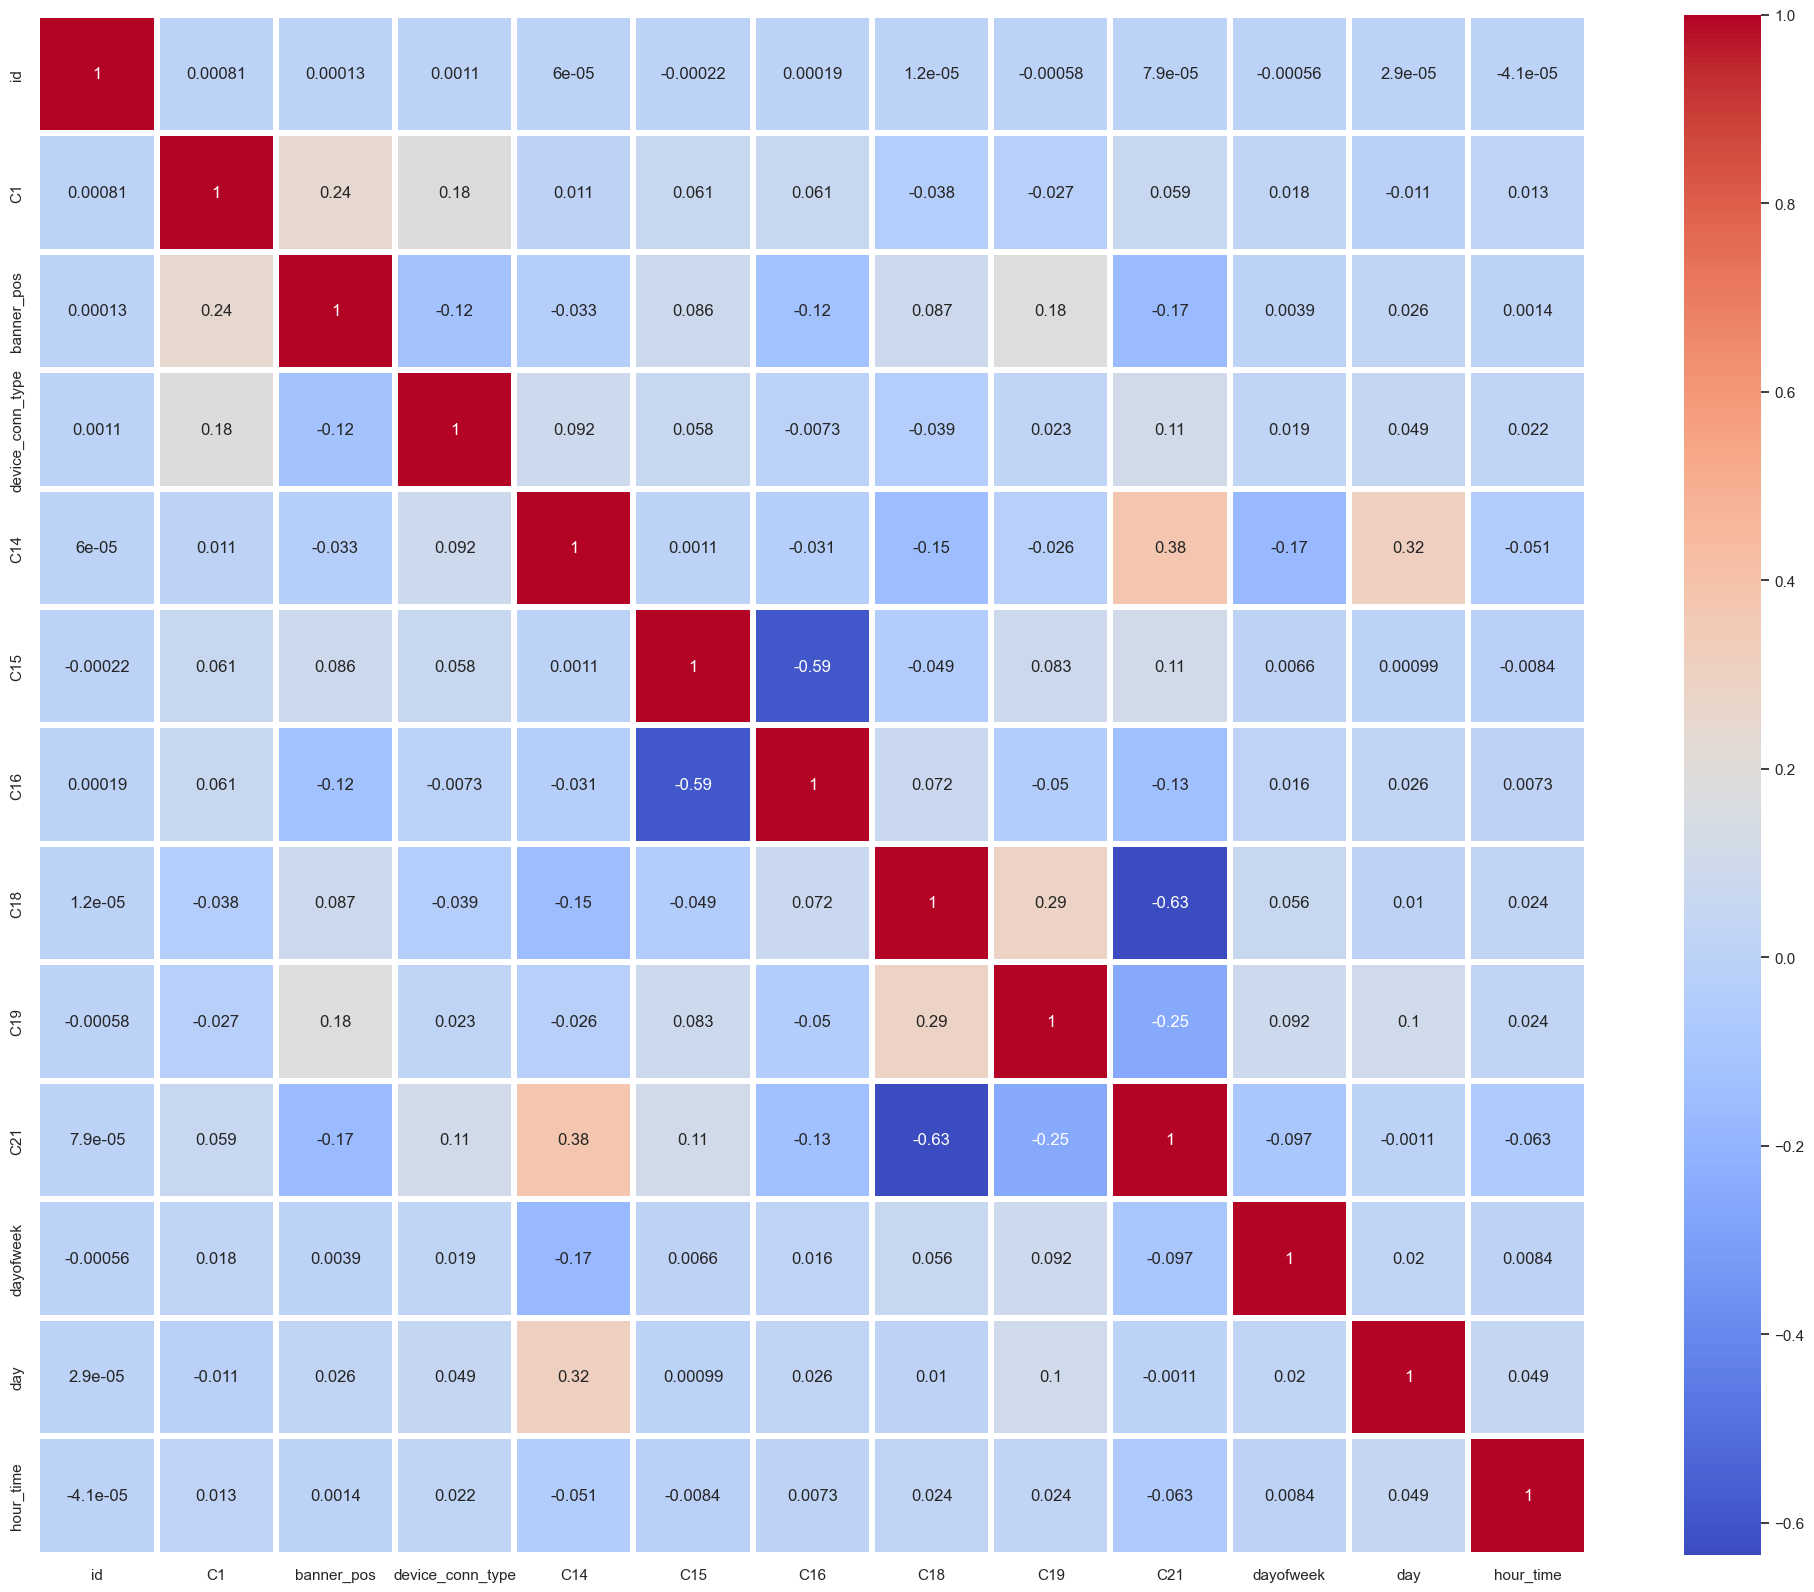

In [18]:
# Spearman相关系数
numerical = [col for col in numerical if col!= 'device_type' and col != 'C17']
corr = train[numerical].corr(method='spearman')
f, ax = plt.subplots(figsize=(25,20))
sns.heatmap(corr, ax=ax, annot=True, linewidths=3, cmap='coolwarm')
plt.savefig(fname="过滤后Spearman相关系数热图.png")

### 2.3 数据准备
#### 2.3.1 变量重命名

In [19]:
## 2.3 数据准备
# 变量重命名
train.rename(columns={'click': 'y', 'hour_time': 'hour'}, inplace=True, errors='raise')

#### 2.3.2 数据抽样
五百万个样本我cpu还是吃不消，而且这个月的kaggle免费gpu用完了  
所以抽取10%的样本，五十万样本用于训练

In [20]:
sampled_data = train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

#### 2.3.3 K-S检验
确保抽样前后分布一致，p > 0.05不拒绝原假设，分布一致

y
0   0.83
1   0.17
Name: proportion, dtype: float64
KS统计量：0.0006314000000000597
P值：0.993446608148514
在显著性水平为 0.05 的情况下，不能拒绝原假设，抽样前后目标变量的分布没有显著差异。


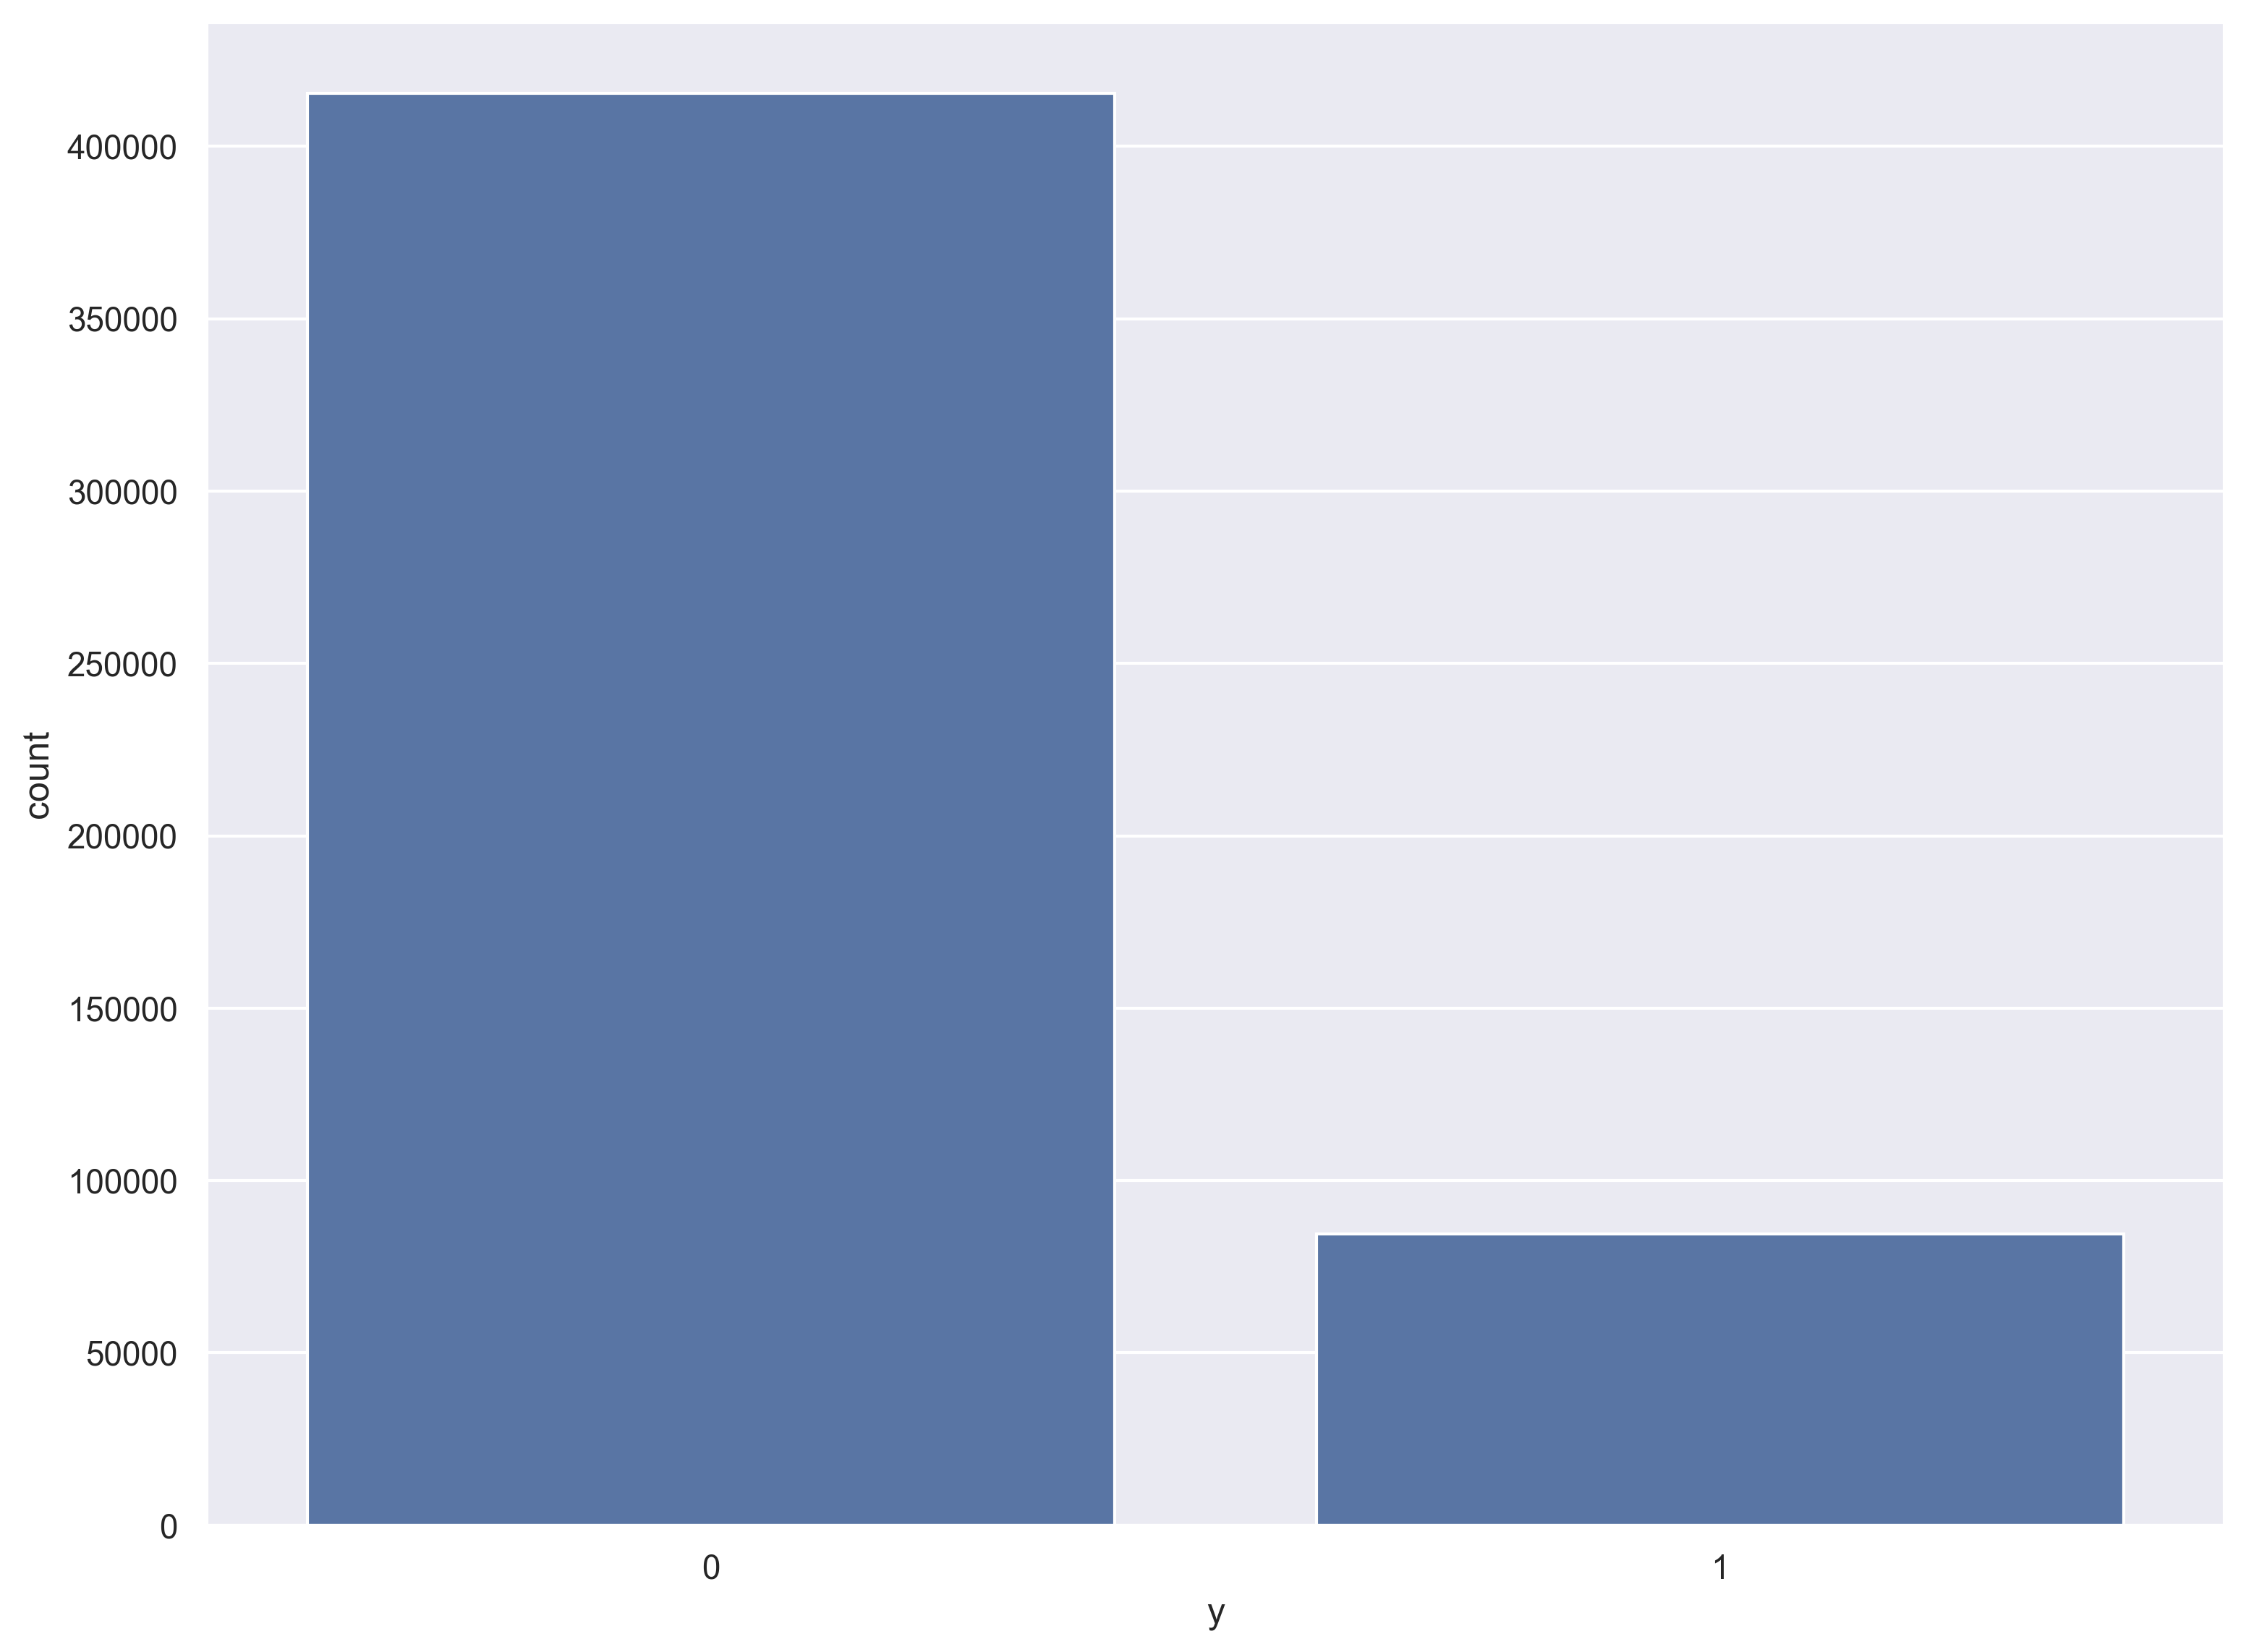

In [21]:
# K-S检验
# 确认抽样后分布保持不变
# 分布情况
print(train.y.value_counts(normalize = True))

plt.figure(figsize=(12, 9), dpi=300)
sns.countplot(x=y)
plt.savefig(fname="抽样后的click分布.png")

# 计算K-S检验结果
y_train = train['y']
y_sampled = y

ks_statistic, p_value = ks_2samp(y_train, y_sampled)

print(f"KS统计量：{ks_statistic}")
print(f"P值：{p_value}")

alpha = 0.05
if p_value > alpha:
    print("在显著性水平为", alpha, "的情况下，不能拒绝原假设，抽样前后目标变量的分布没有显著差异。")
else:
    print("在显著性水平为", alpha, "的情况下，拒绝原假设，抽样前后目标变量的分布存在显著差异。")

#### 2.3.4 数据编码
所有分类变量都包含许多唯一值，one-hot编码不合适，导致数据集变得非常大，因此使用target编码  

In [22]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head()

id    C1  ...  device_ip  device_model
3577888  11226371896522467897  1005  ...       0.15          0.17
4993932  16686619985120477716  1005  ...       0.15          0.14
4094900   8421542567069138084  1005  ...       0.28          0.19
4420497  17543475496005961291  1005  ...       0.18          0.34
634465   16365185369633497389  1005  ...       0.15          0.13

[5 rows x 22 columns]

#### 2.3.5 数据划分

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

## 三、传统机器学习模型
### 3.1 函数定义
##### 模型评估

In [24]:
def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print(accuracy)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    #print(cnf_matrix)
    #metrics.plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    return accuracy, cnf_matrix

##### 交叉验证

In [25]:
def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    return crossvalidation

##### 结果保存

In [26]:
def store_results(name, ytrain, xtrain, ytest, xtest, model, folds):
    
    crossvalidation = cross_val(model, xtrain, ytrain, folds)
    
    accuracy_test, cm1 =  model_eval(model, xtrain, ytrain)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_test = TP / (TP+FP)
    precision_test = TP / (TP+FN)
    
    accuracy_train, cm1 =  model_eval(model, xtest, ytest)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_train = TP / (TP+FP)
    precision_train = TP / (TP+FN)

    entry = {'Model': [name],
          'Accuracy_train': [accuracy_train],
          'recall_train': [recall_train],
          'precision_train': [precision_train],
          'Accuracy_test': [accuracy_train],
          'recall_test': [recall_train],
          'precision_test': [precision_train],
          'CrossVal_Mean': [crossvalidation.mean()],           
          'CrossVal1': [crossvalidation[0]],
          'CrossVal2': [crossvalidation[1]],
          'CrossVal3': [crossvalidation[2]],
          'CrossVal4': [crossvalidation[3]],
          'CrossVal5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result

<a id="1"></a>
### 3.2 Dummy classifier
基模型，用于比较模型效果
##### 预测准确率

In [27]:
## 3.1 Dummy classifier
# 基模型，用于比较模型效果
outcome = pd.DataFrame()
dummy_clf = DummyClassifier(strategy= "most_frequent")
dummy_clf.fit(X_train, y_train)
accuracy, cnf_matrix  = model_eval(dummy_clf, X_train, y_train)
print("预测准确率:", accuracy)

预测准确率: 0.8309171428571429


##### 混淆矩阵

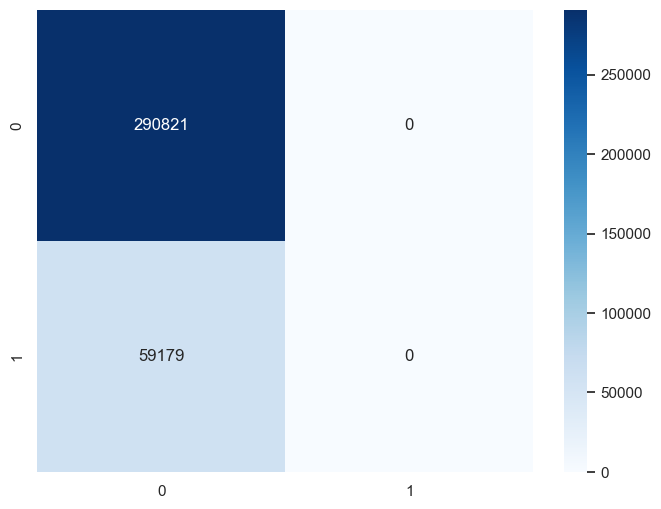

In [28]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="Dummy classifier混淆矩阵.png")

##### 模型评估

In [29]:
temp = store_results("Dummy classifier", y_train, X_train, y_test, X_test, dummy_clf, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

Model  Accuracy_train  ...  CrossVal4  CrossVal5
0  Dummy classifier            0.83  ...       0.83       0.83

[1 rows x 13 columns]

##### Lift曲线

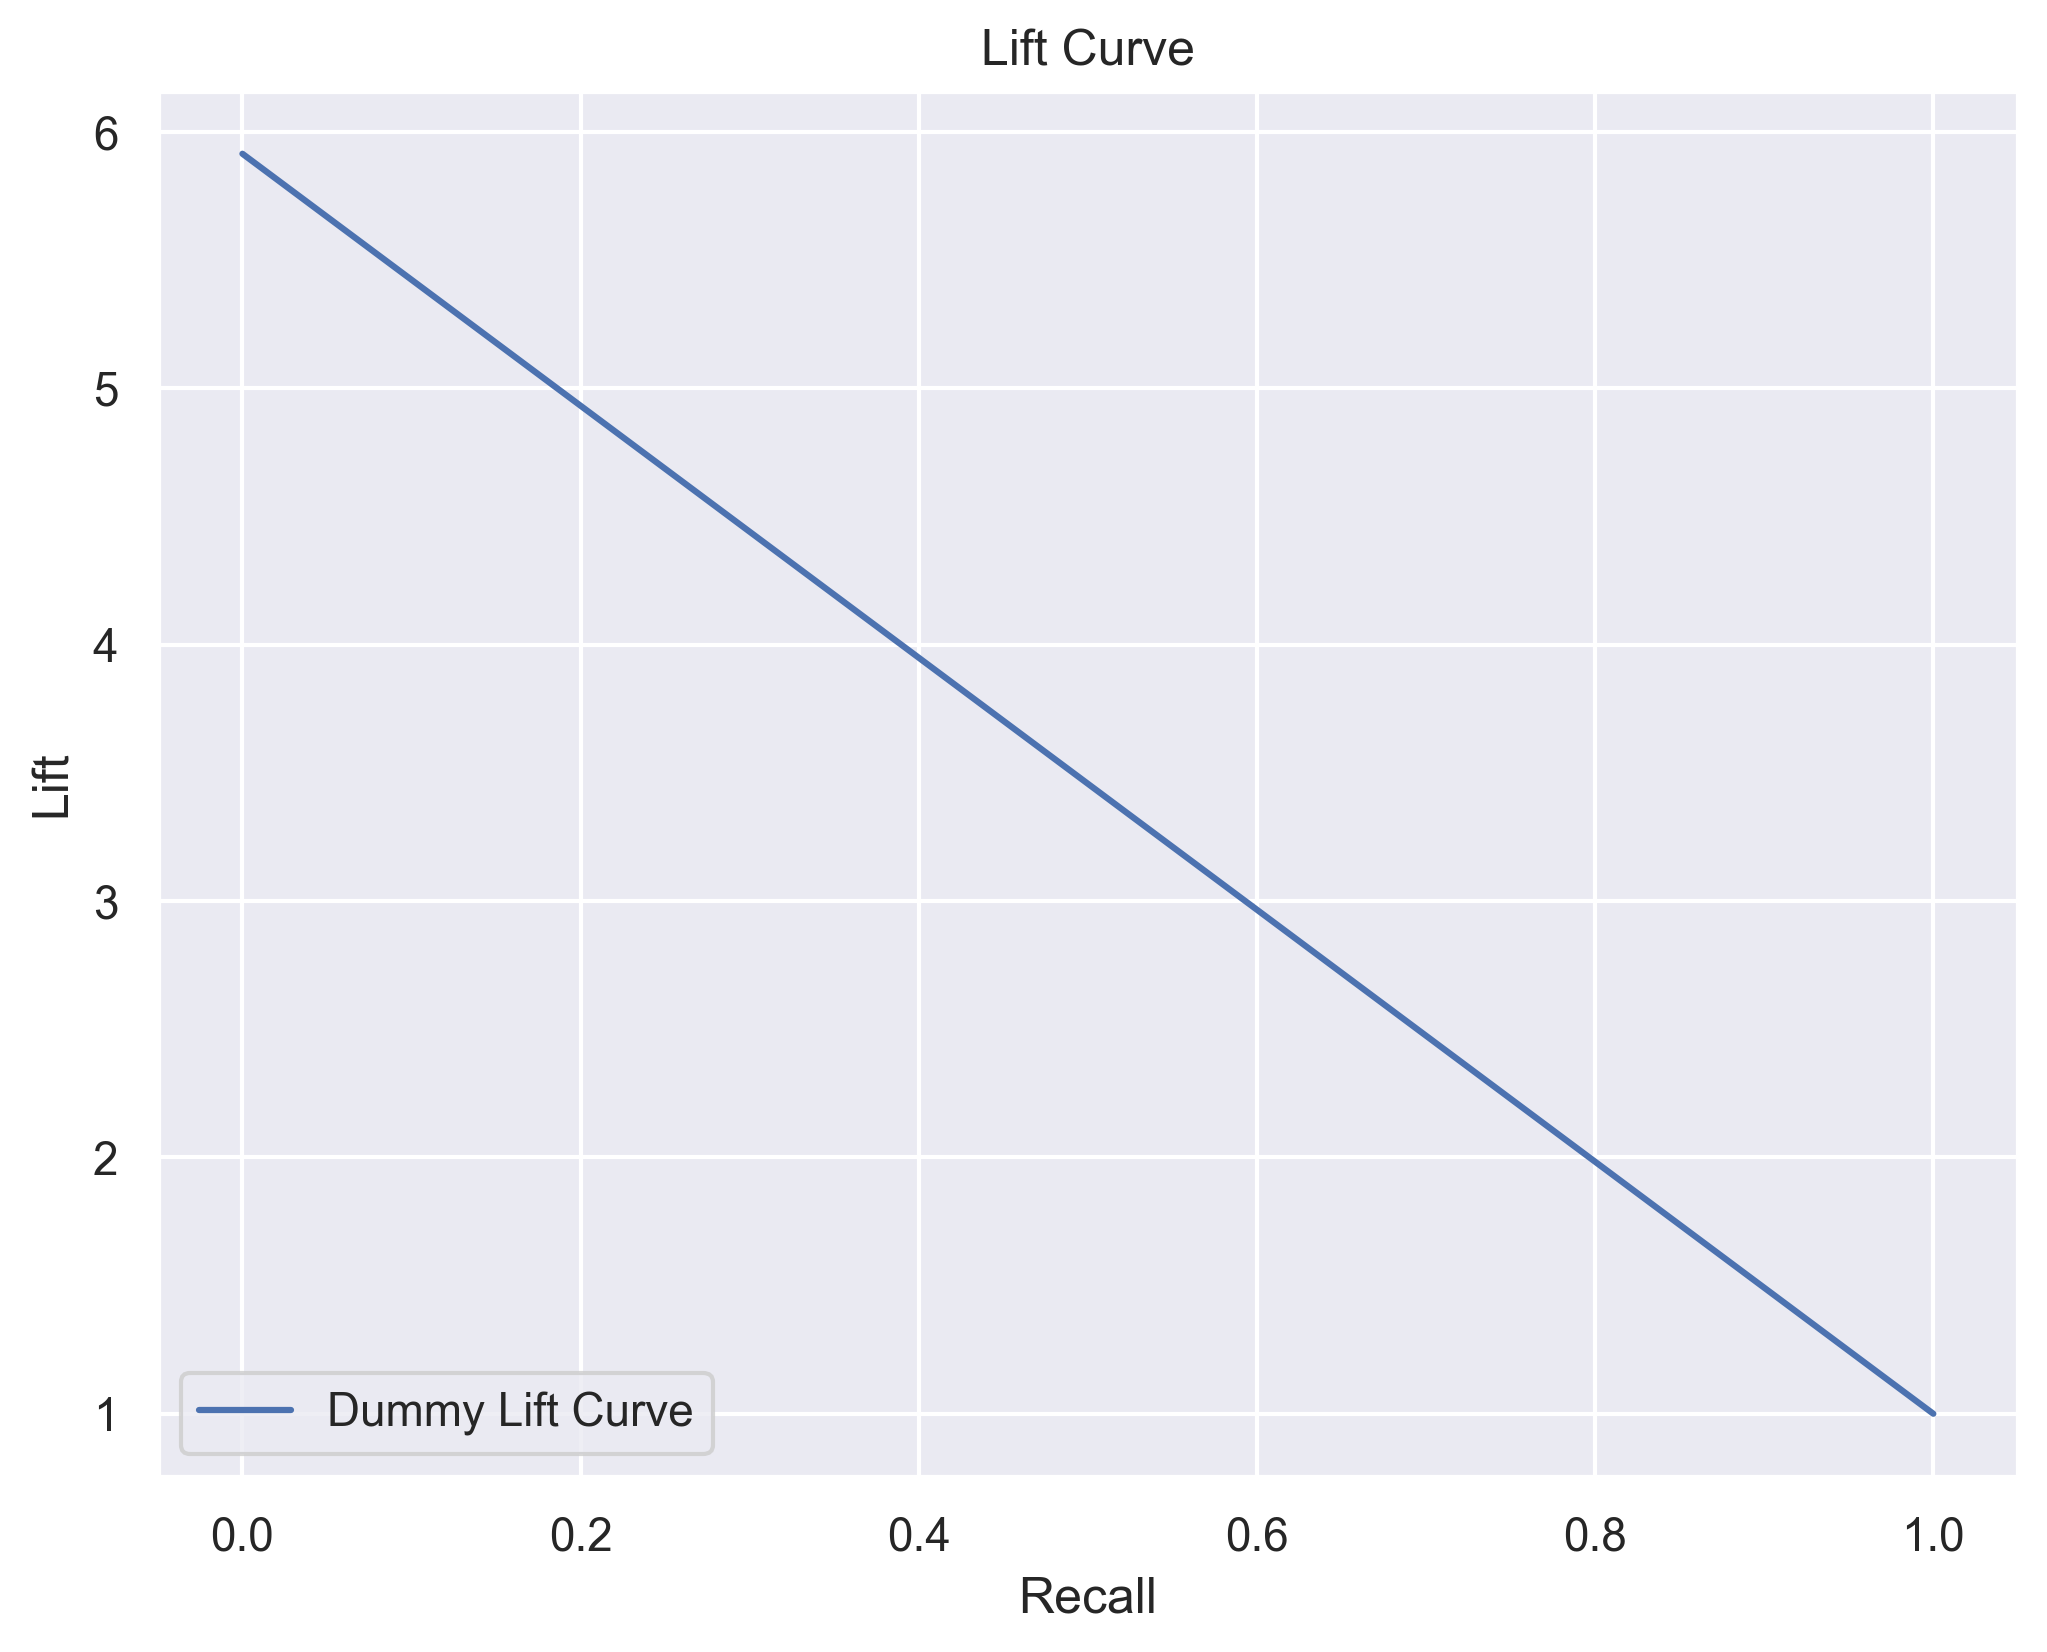

In [30]:
# 绘制 Lift 曲线
y_pred = dummy_clf.predict(X_test)
precision_Dummy, recall_Dummy, thresholds_Dummy = precision_recall_curve(y_test, y_pred)
lift_Dummy = precision_Dummy / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_Dummy, lift_Dummy, label='Dummy Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="DummyLift曲线.png")

<a id="2"></a>
### 3.3 Logistic回归（不平稳数据）
##### 最大最小归一化

In [31]:
# 最大最小归一化
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

id   C1  banner_pos  ...  device_id  device_ip  device_model
1812234 0.81 0.36        0.00  ...       0.22       0.22          0.03
4970514 0.01 0.36        0.00  ...       0.22       0.23          0.31
463370  0.48 0.36        0.14  ...       0.22       0.22          0.22
4649555 0.77 0.36        0.00  ...       0.22       0.22          0.35
4244499 1.00 0.36        0.14  ...       0.22       0.23          0.37

[5 rows x 22 columns]

In [32]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test.head()

id   C1  banner_pos  ...  device_id  device_ip  device_model
596564  0.82 0.36        0.00  ...       0.22       0.23          0.07
3947955 0.28 0.36        0.00  ...       0.22       0.23          0.30
4591569 0.26 0.09        0.00  ...       0.19       0.23          0.36
4419193 0.09 0.36        0.00  ...       0.19       0.23          0.27
1891107 0.79 0.36        0.00  ...       0.22       0.13          0.11

[5 rows x 22 columns]

##### 调参
##### 预测准确率

In [33]:
# 建模拟合
model = LogisticRegression()
model.fit(X_train, y_train)

# 模型预测
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print("预测准确率:", accuracy)

预测准确率: 0.9284933333333333


##### 混淆矩阵

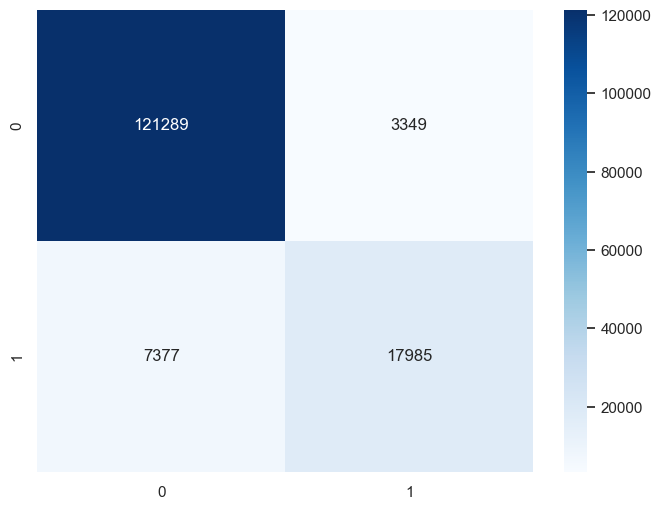

In [34]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="Logistic回归（不平稳数据）混淆矩阵.png")

##### 模型评估

In [35]:
temp = store_results("logistic回归（不平稳数据）", y_train, X_train, y_test, X_test, model, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

Model  Accuracy_train  ...  CrossVal4  CrossVal5
0   Dummy classifier            0.83  ...       0.83       0.83
1  logistic回归（不平稳数据）            0.93  ...       0.93       0.93

[2 rows x 13 columns]

##### Lift曲线

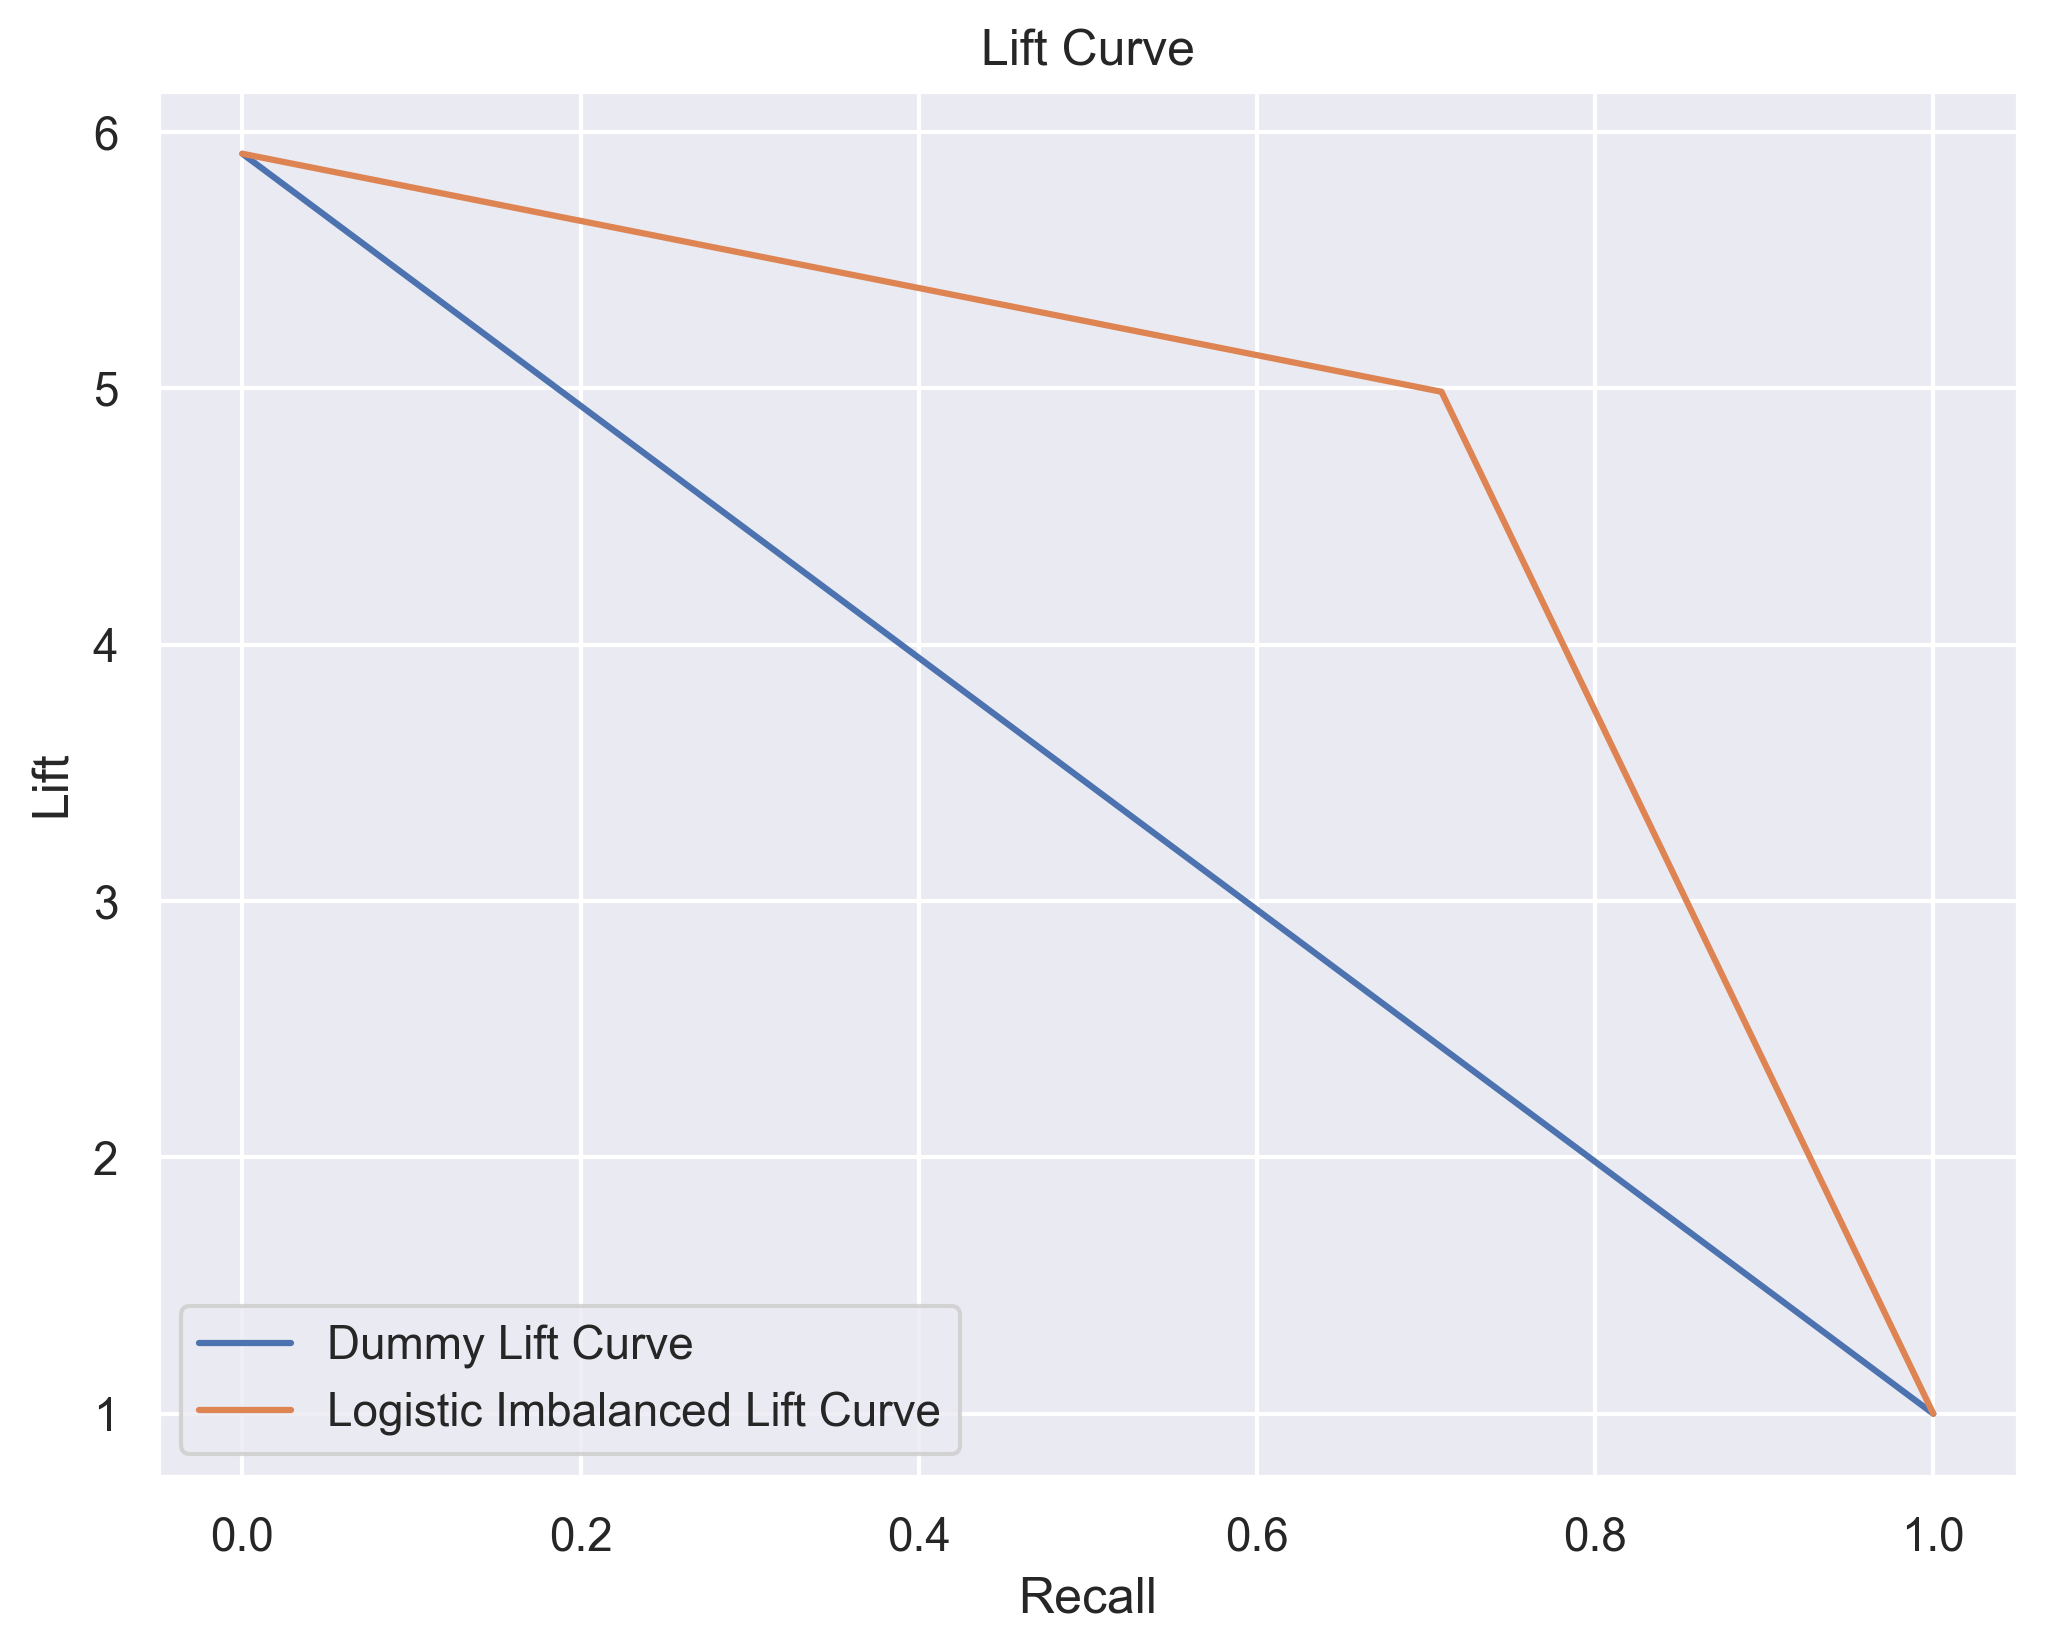

In [36]:
# 绘制 Lift 曲线
y_pred = model.predict(X_test)
precision_LI, recall_LI, thresholds_LI = precision_recall_curve(y_test, y_pred)
lift_LI = precision_LI / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_Dummy, lift_Dummy, label='Dummy Lift Curve')
plt.plot(recall_LI, lift_LI, label='Logistic Imbalanced Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="LILift曲线.png")

**Logistic回归（不平稳数据）与Dummy classifier效果基本一致**
<a id="3"></a>
### 3.4 Logistic回归（平稳数据）
##### SMOTE过采样

原始数据形状  Counter({0: 415459, 1: 84541})
过采用数据形状 Counter({0: 415459, 1: 415459})


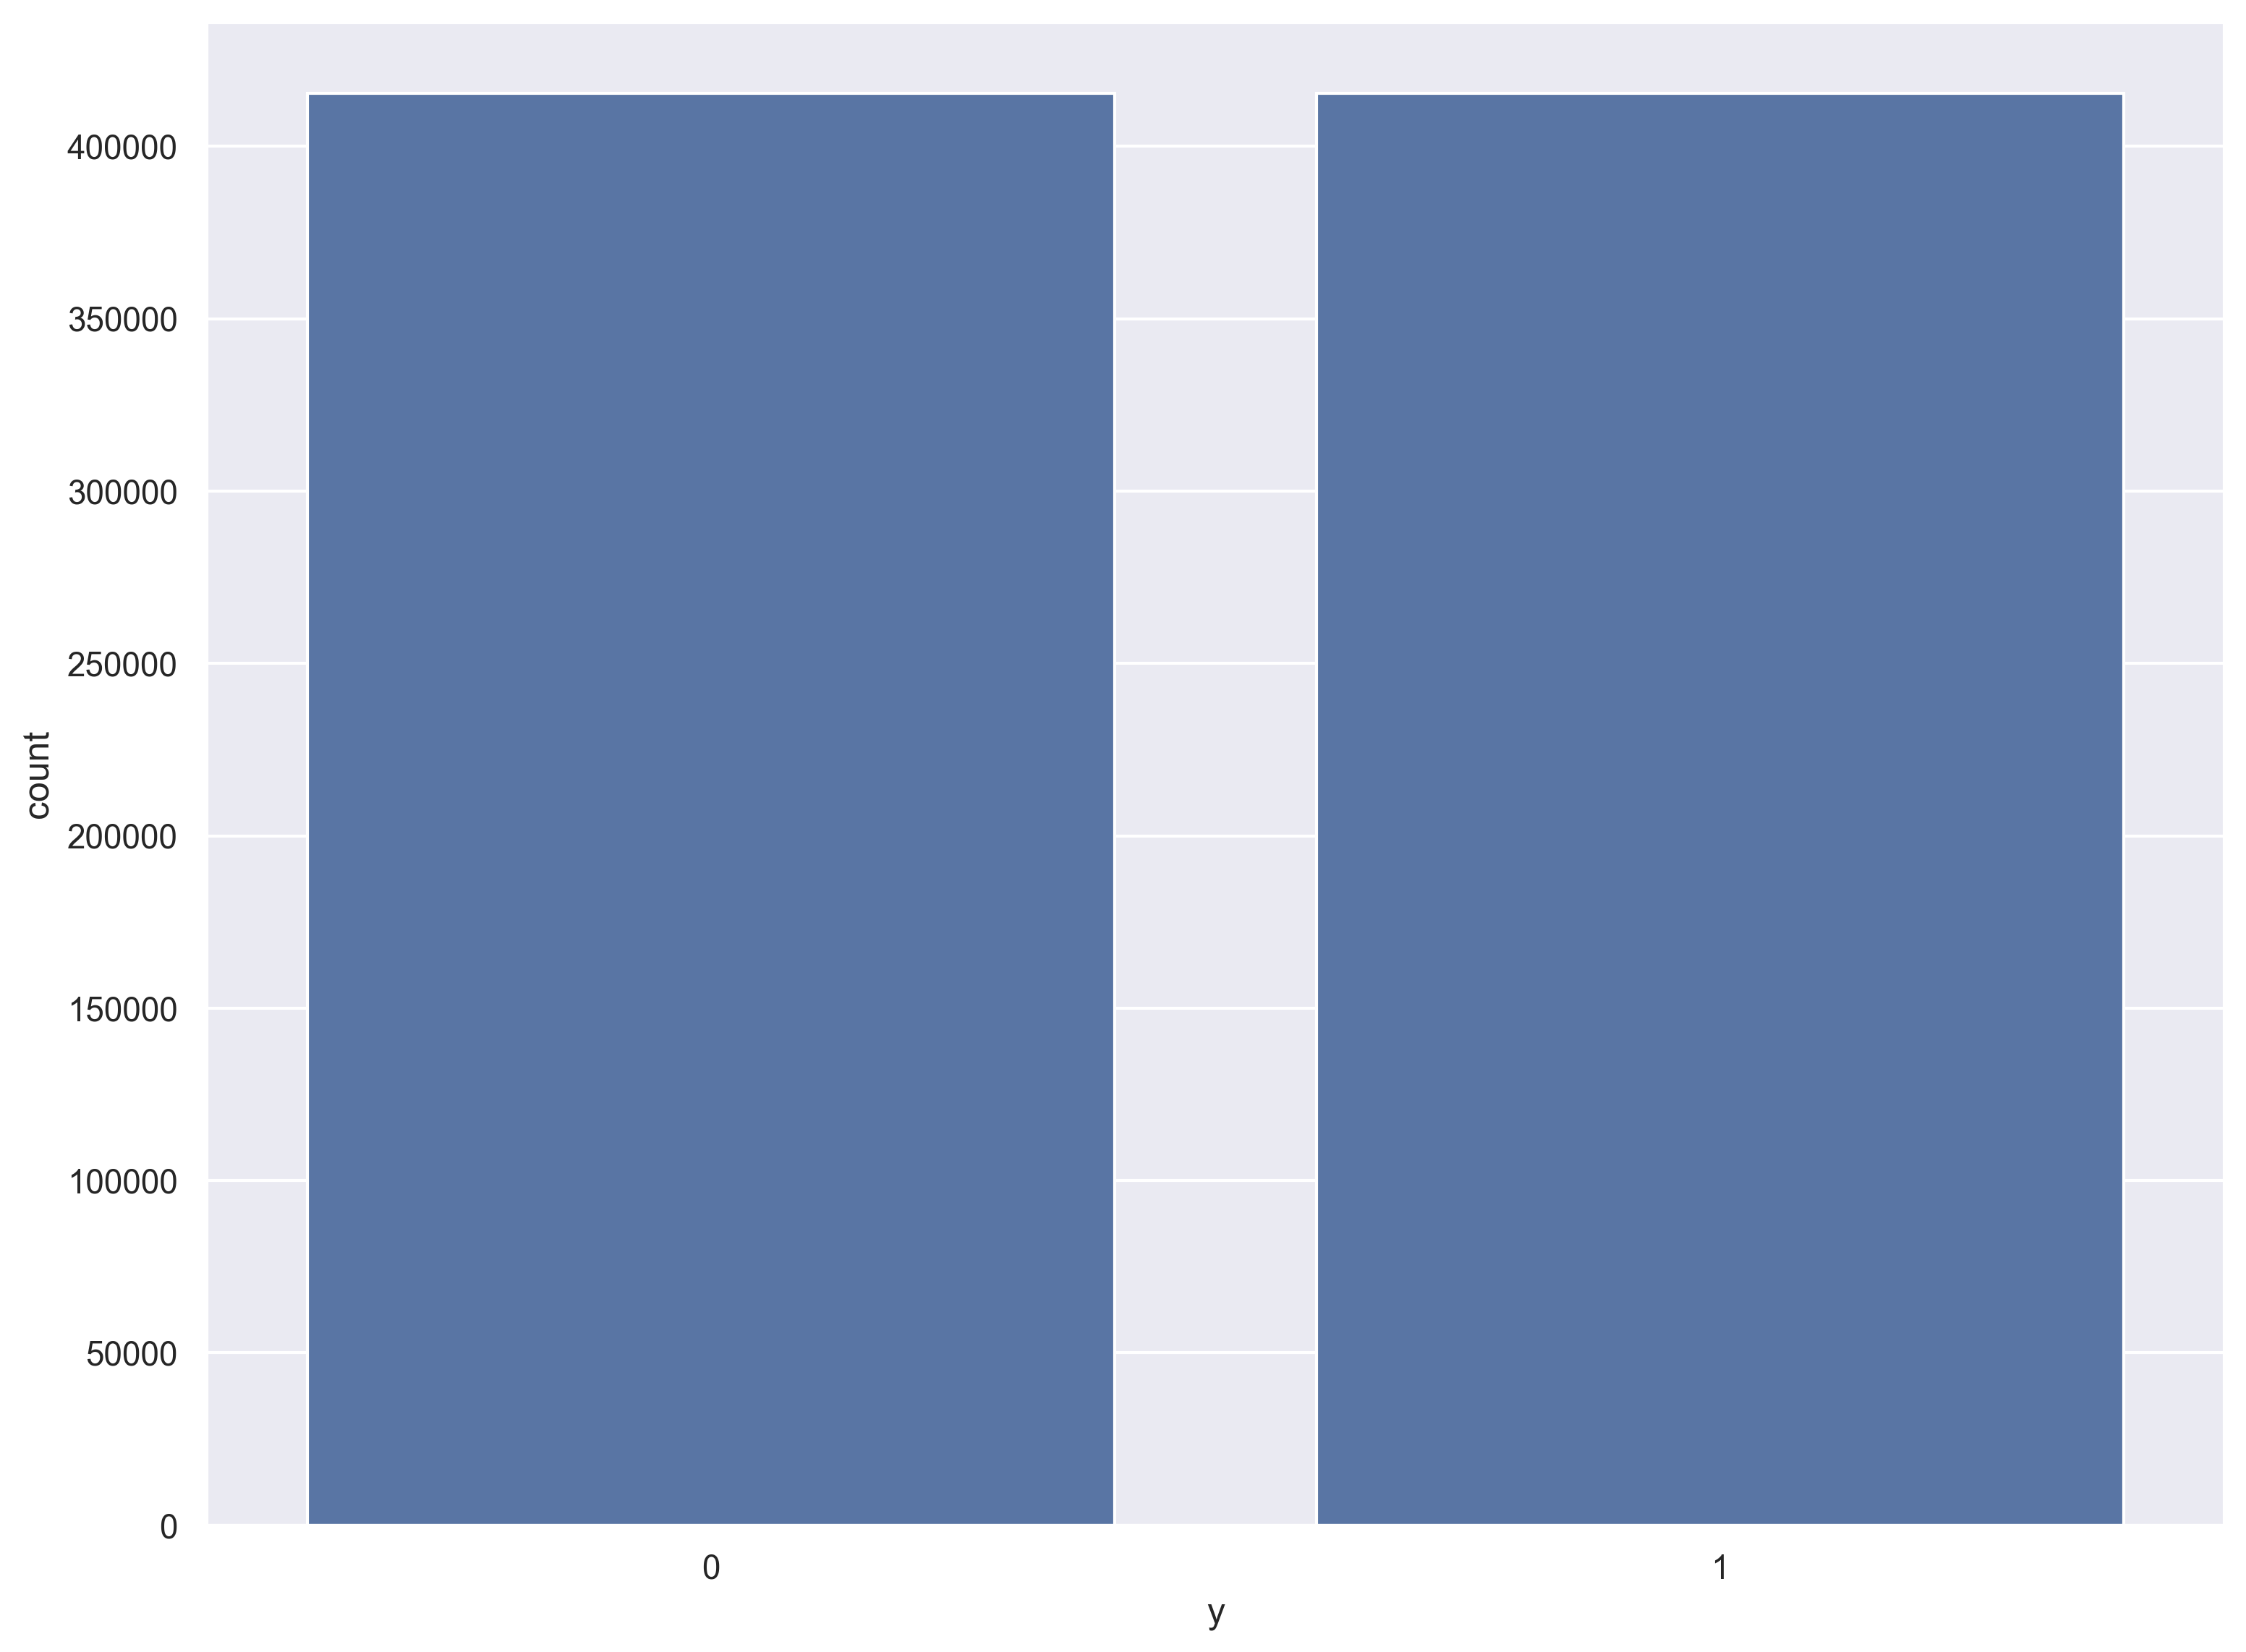

In [37]:
# SMOTE过采样
randomsample=  SMOTE()
x_new, y_new = randomsample.fit_resample(X, y)

print('原始数据形状  {}'.format(Counter(y)))
print('过采用数据形状 {}'.format(Counter(y_new)))
plt.figure(figsize=(12, 9), dpi=300)
sns.countplot(x=y_new)
plt.savefig(fname="过采样后click分布.png")

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

##### 最大最小归一化

In [38]:
# 归一化
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

##### 调参
##### 预测准确率

In [39]:
# 建模拟合
model = LogisticRegression()
model.fit(X_train, y_train)

# 模型预测
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print("预测准确率:", accuracy)

预测准确率: 0.5


##### 混淆矩阵

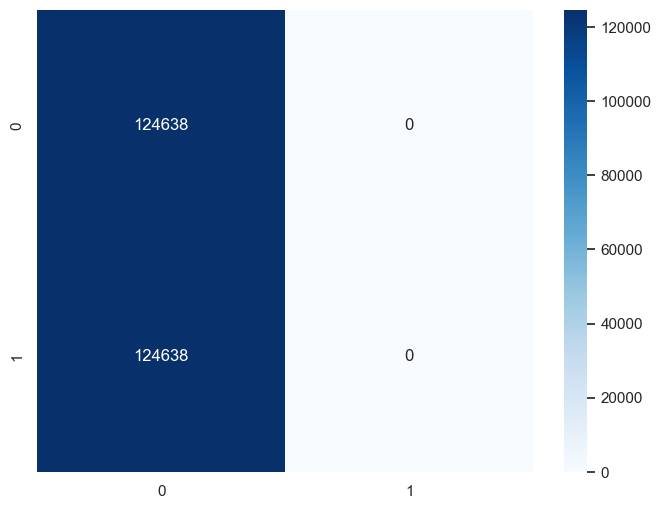

In [40]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="Logistic回归（平稳数据）混淆矩阵.png")

##### 模型评估
这个红色警告是因为平衡数据和不平衡数据量不一样，不让我一起比，但没关系，可以放在一个表中，分开比较，下面Lift曲线同理

In [41]:
temp = store_results("logistic回归（平稳数据）", y_train, X_train, y_test, X_test, model, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

/Users/ouyangruizhi/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ouyangruizhi/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Model  Accuracy_train  ...  CrossVal4  CrossVal5
0   Dummy classifier            0.83  ...       0.83       0.83
1  logistic回归（不平稳数据）            0.93  ...       0.93       0.93
2   logistic回归（平稳数据）            0.50  ...       0.91       0.91

[3 rows x 13 columns]

##### Lift曲线

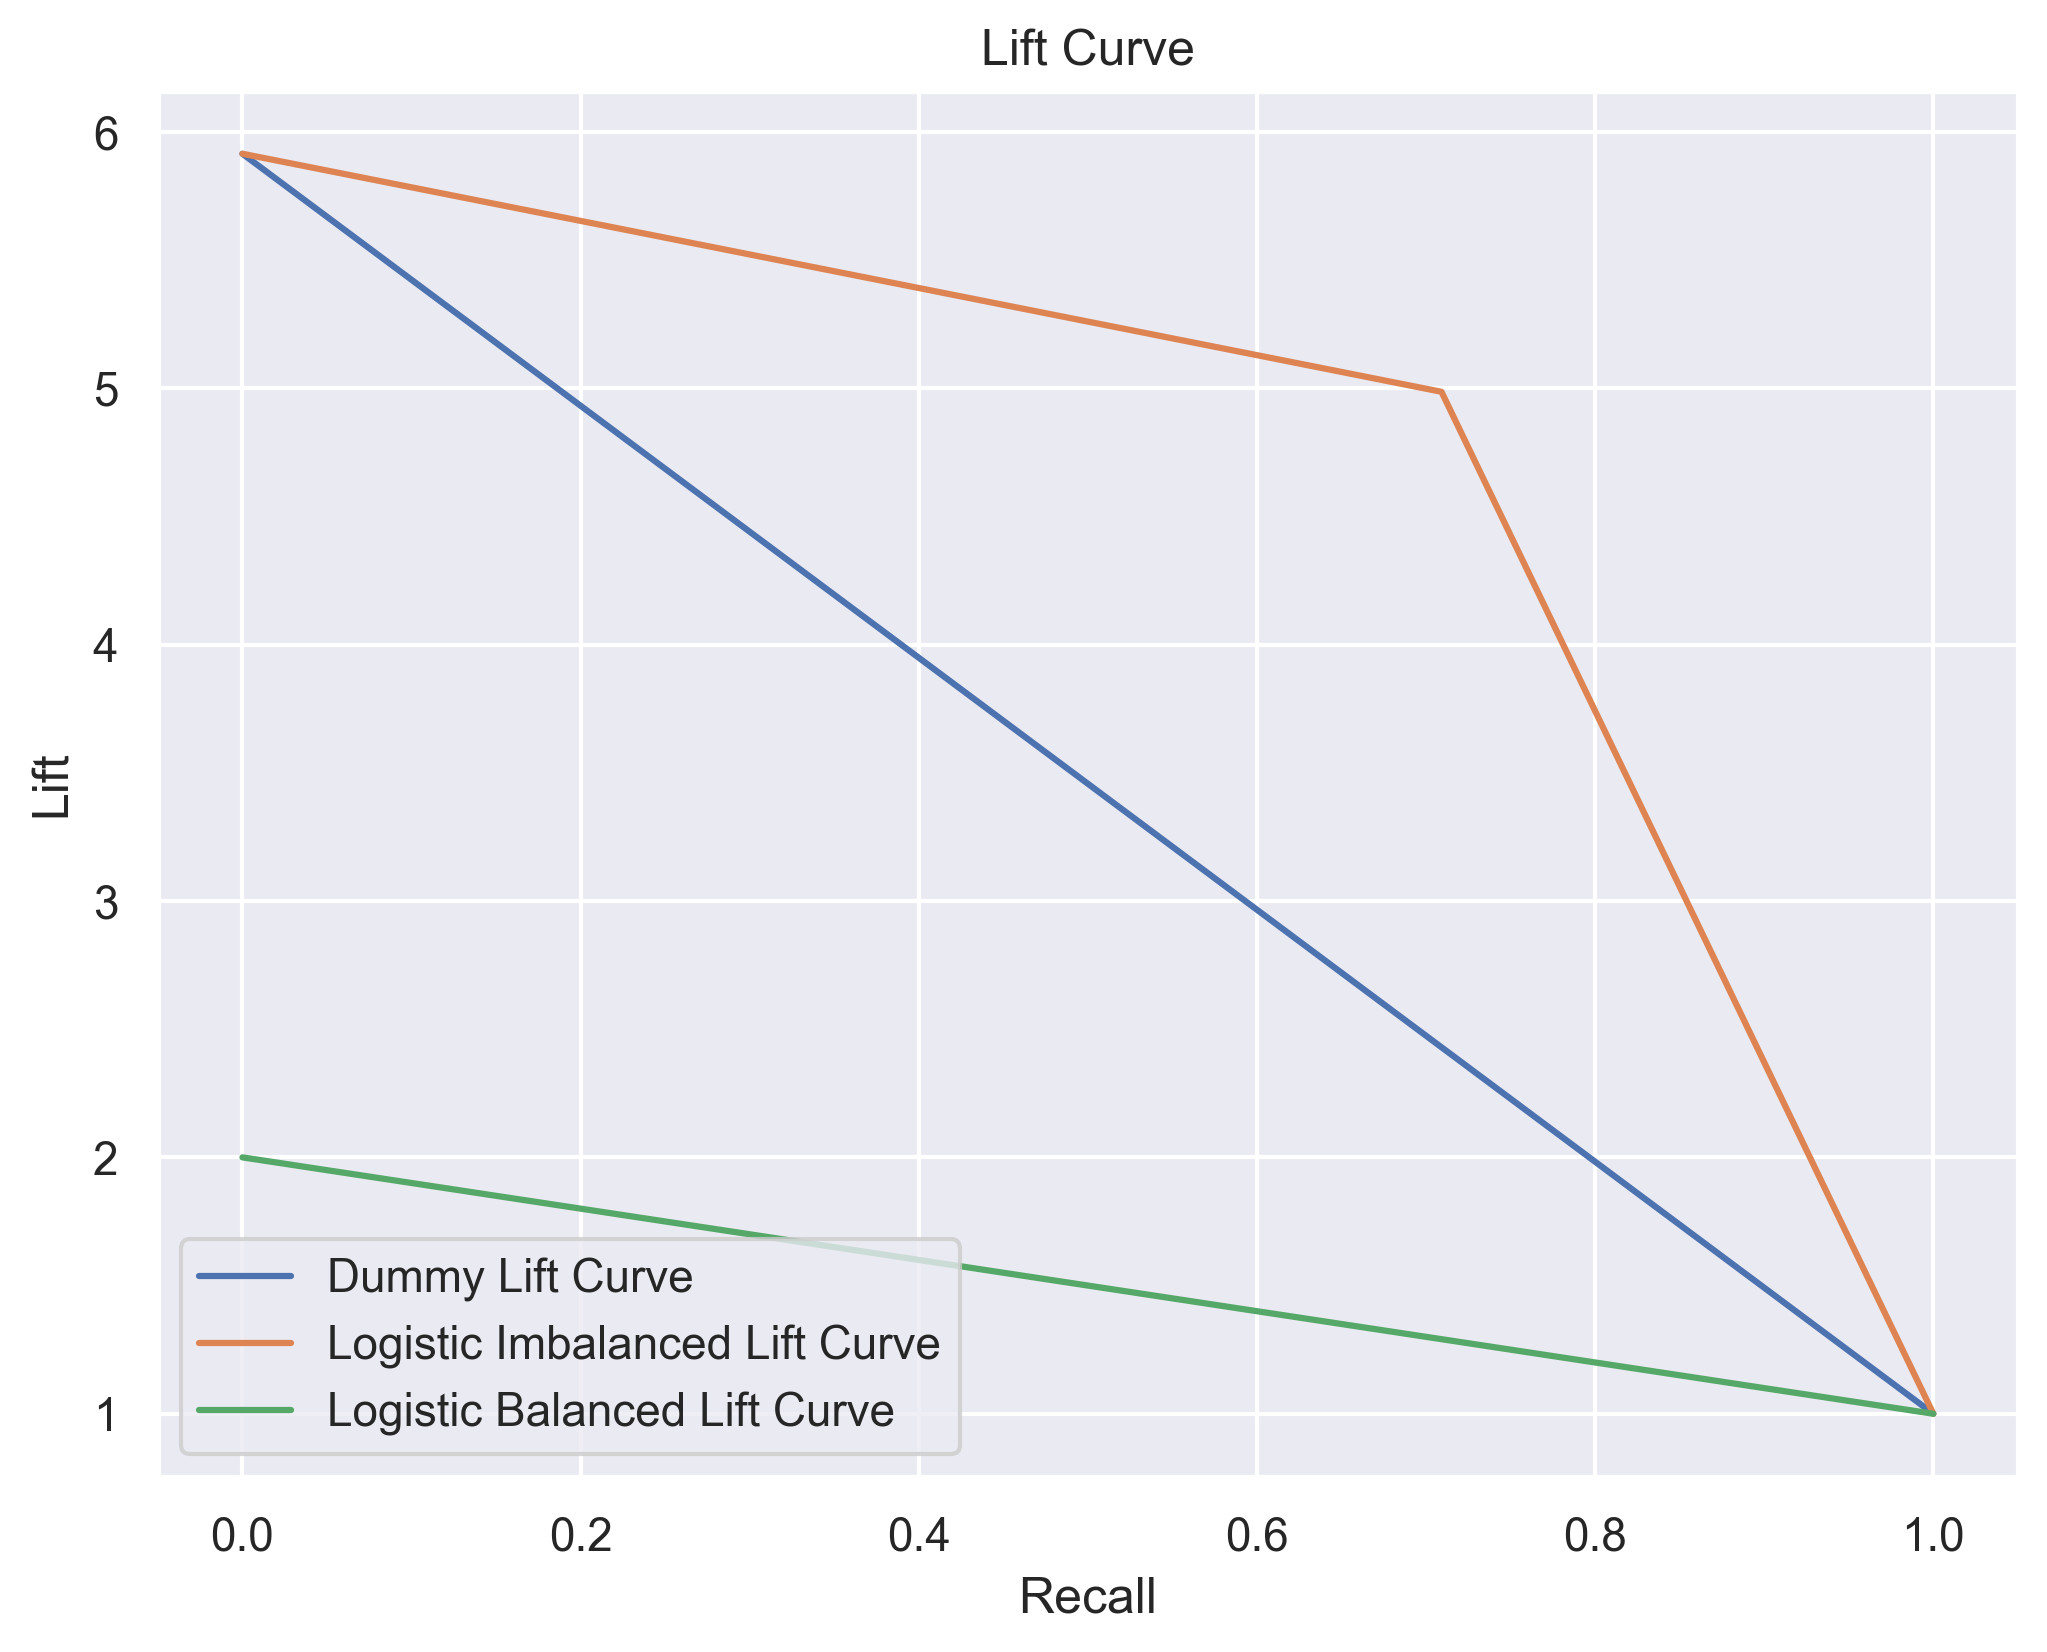

In [42]:
# 绘制 Lift 曲线
y_pred = model.predict(X_test)
precision_LB, recall_LB, thresholds_LB = precision_recall_curve(y_test, y_pred)
lift_LB = precision_LB / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_Dummy, lift_Dummy, label='Dummy Lift Curve')
plt.plot(recall_LI, lift_LI, label='Logistic Imbalanced Lift Curve')
plt.plot(recall_LB, lift_LB, label='Logistic Balanced Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="LBLift曲线.png")

<a id="4"></a>
### 3.5 决策树（不平稳数据）

##### 调参
##### 模型拟合

In [43]:
# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

# 调参

# 建模拟合
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)

# 模型预测
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print("预测准确率:", accuracy)

预测准确率: 0.9130066666666666


##### 混淆矩阵

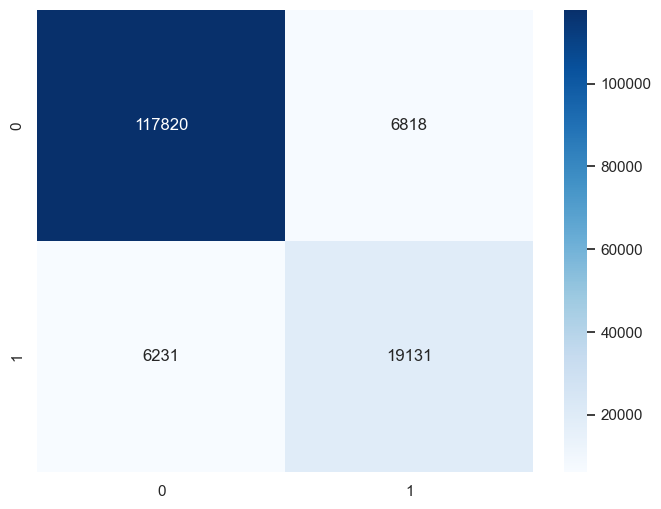

In [44]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="决策树（不平稳数据）混淆矩阵.png")

##### 模型评估

In [45]:
temp = store_results("决策树（不平稳数据）", y_train, X_train, y_test, X_test, dt_basic, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

Model  Accuracy_train  ...  CrossVal4  CrossVal5
0   Dummy classifier            0.83  ...       0.83       0.83
1  logistic回归（不平稳数据）            0.93  ...       0.93       0.93
2   logistic回归（平稳数据）            0.50  ...       0.91       0.91
3         决策树（不平稳数据）            0.91  ...       0.92       0.91

[4 rows x 13 columns]

##### Lift曲线

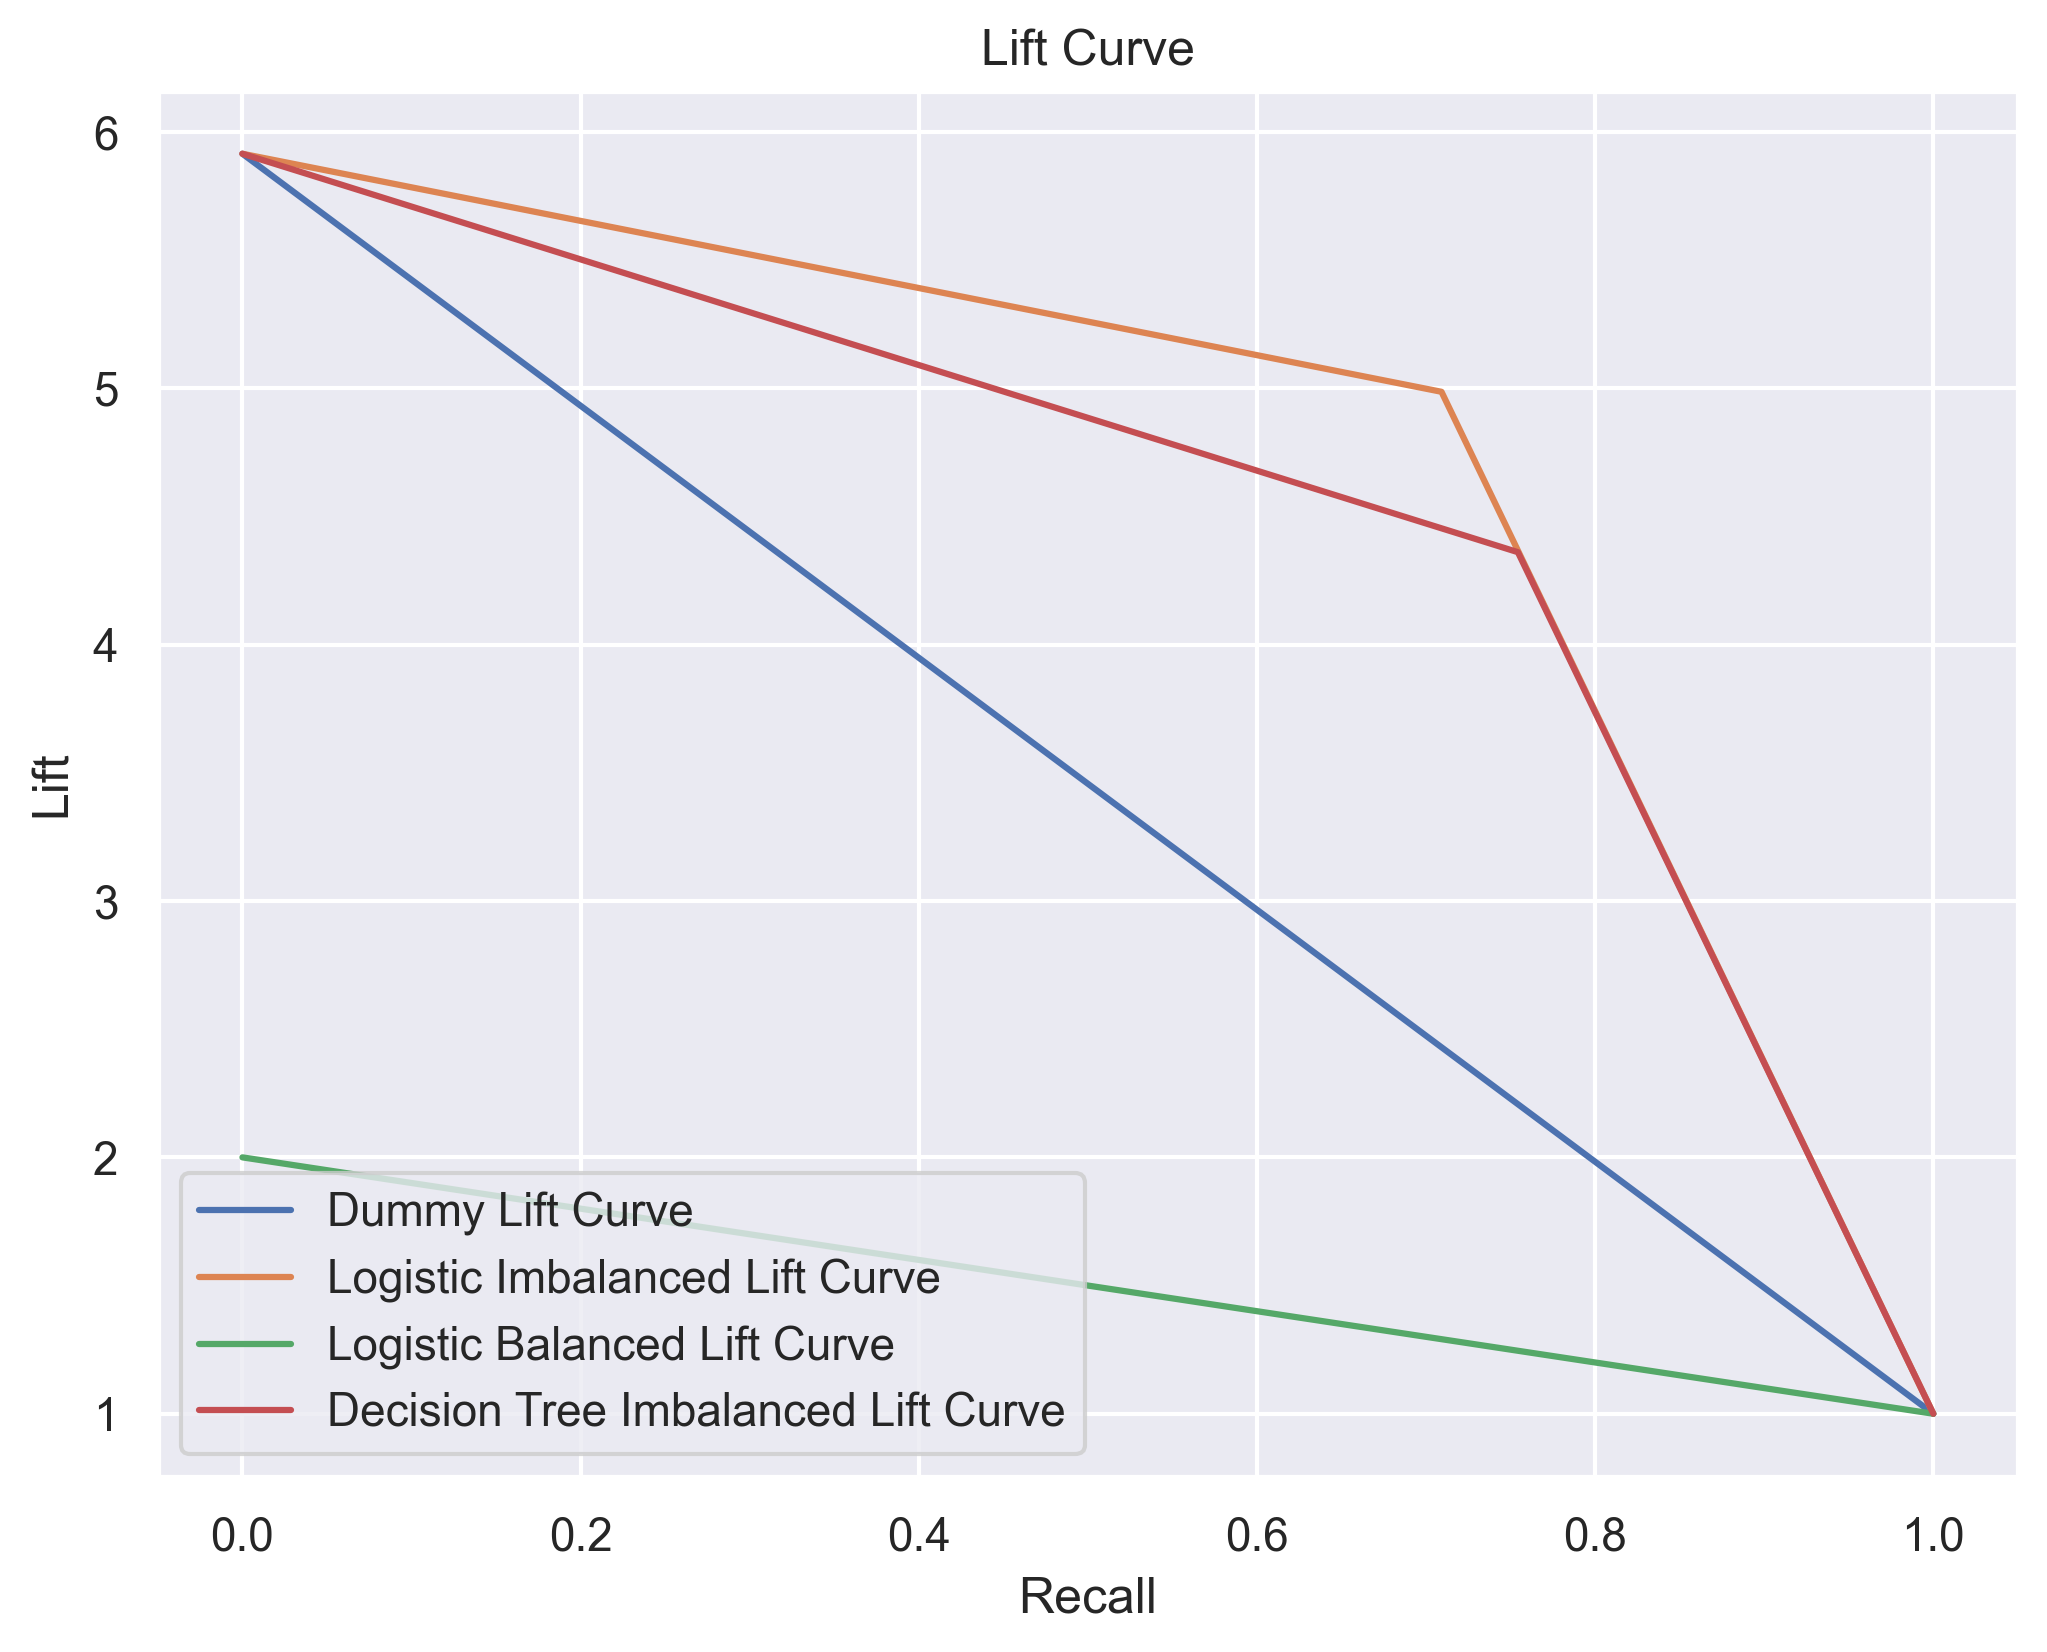

In [46]:
# 绘制 Lift 曲线
y_pred = dt_basic.predict(X_test)
precision_DI, recall_DI, thresholds_DI = precision_recall_curve(y_test, y_pred)
lift_DI = precision_DI / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_Dummy, lift_Dummy, label='Dummy Lift Curve')
plt.plot(recall_LI, lift_LI, label='Logistic Imbalanced Lift Curve')
plt.plot(recall_LB, lift_LB, label='Logistic Balanced Lift Curve')
plt.plot(recall_DI, lift_DI, label='Decision Tree Imbalanced Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="DILift曲线.png")

<a id="5"></a>
### 3.6 决策树（平稳数据）
##### 模型拟合

In [47]:
# 数据划分
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

# 调参

# 建模拟合
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)

# 模型预测
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print("预测准确率:", accuracy)

预测准确率: 0.942641890916093


##### 混淆矩阵

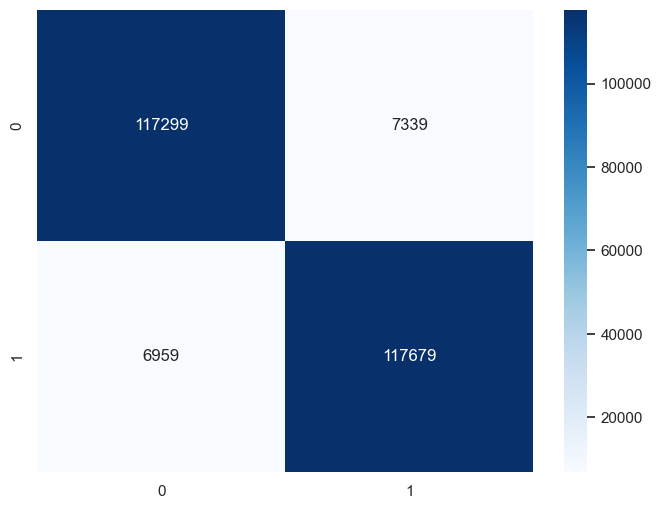

In [48]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="决策树（平稳数据）混淆矩阵.png")

##### 模型评估

In [49]:
temp = store_results("决策树（平稳数据）", y_train, X_train, y_test, X_test, dt_basic, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

Model  Accuracy_train  ...  CrossVal4  CrossVal5
0   Dummy classifier            0.83  ...       0.83       0.83
1  logistic回归（不平稳数据）            0.93  ...       0.93       0.93
2   logistic回归（平稳数据）            0.50  ...       0.91       0.91
3         决策树（不平稳数据）            0.91  ...       0.92       0.91
4          决策树（平稳数据）            0.94  ...       0.94       0.94

[5 rows x 13 columns]

##### Lift曲线

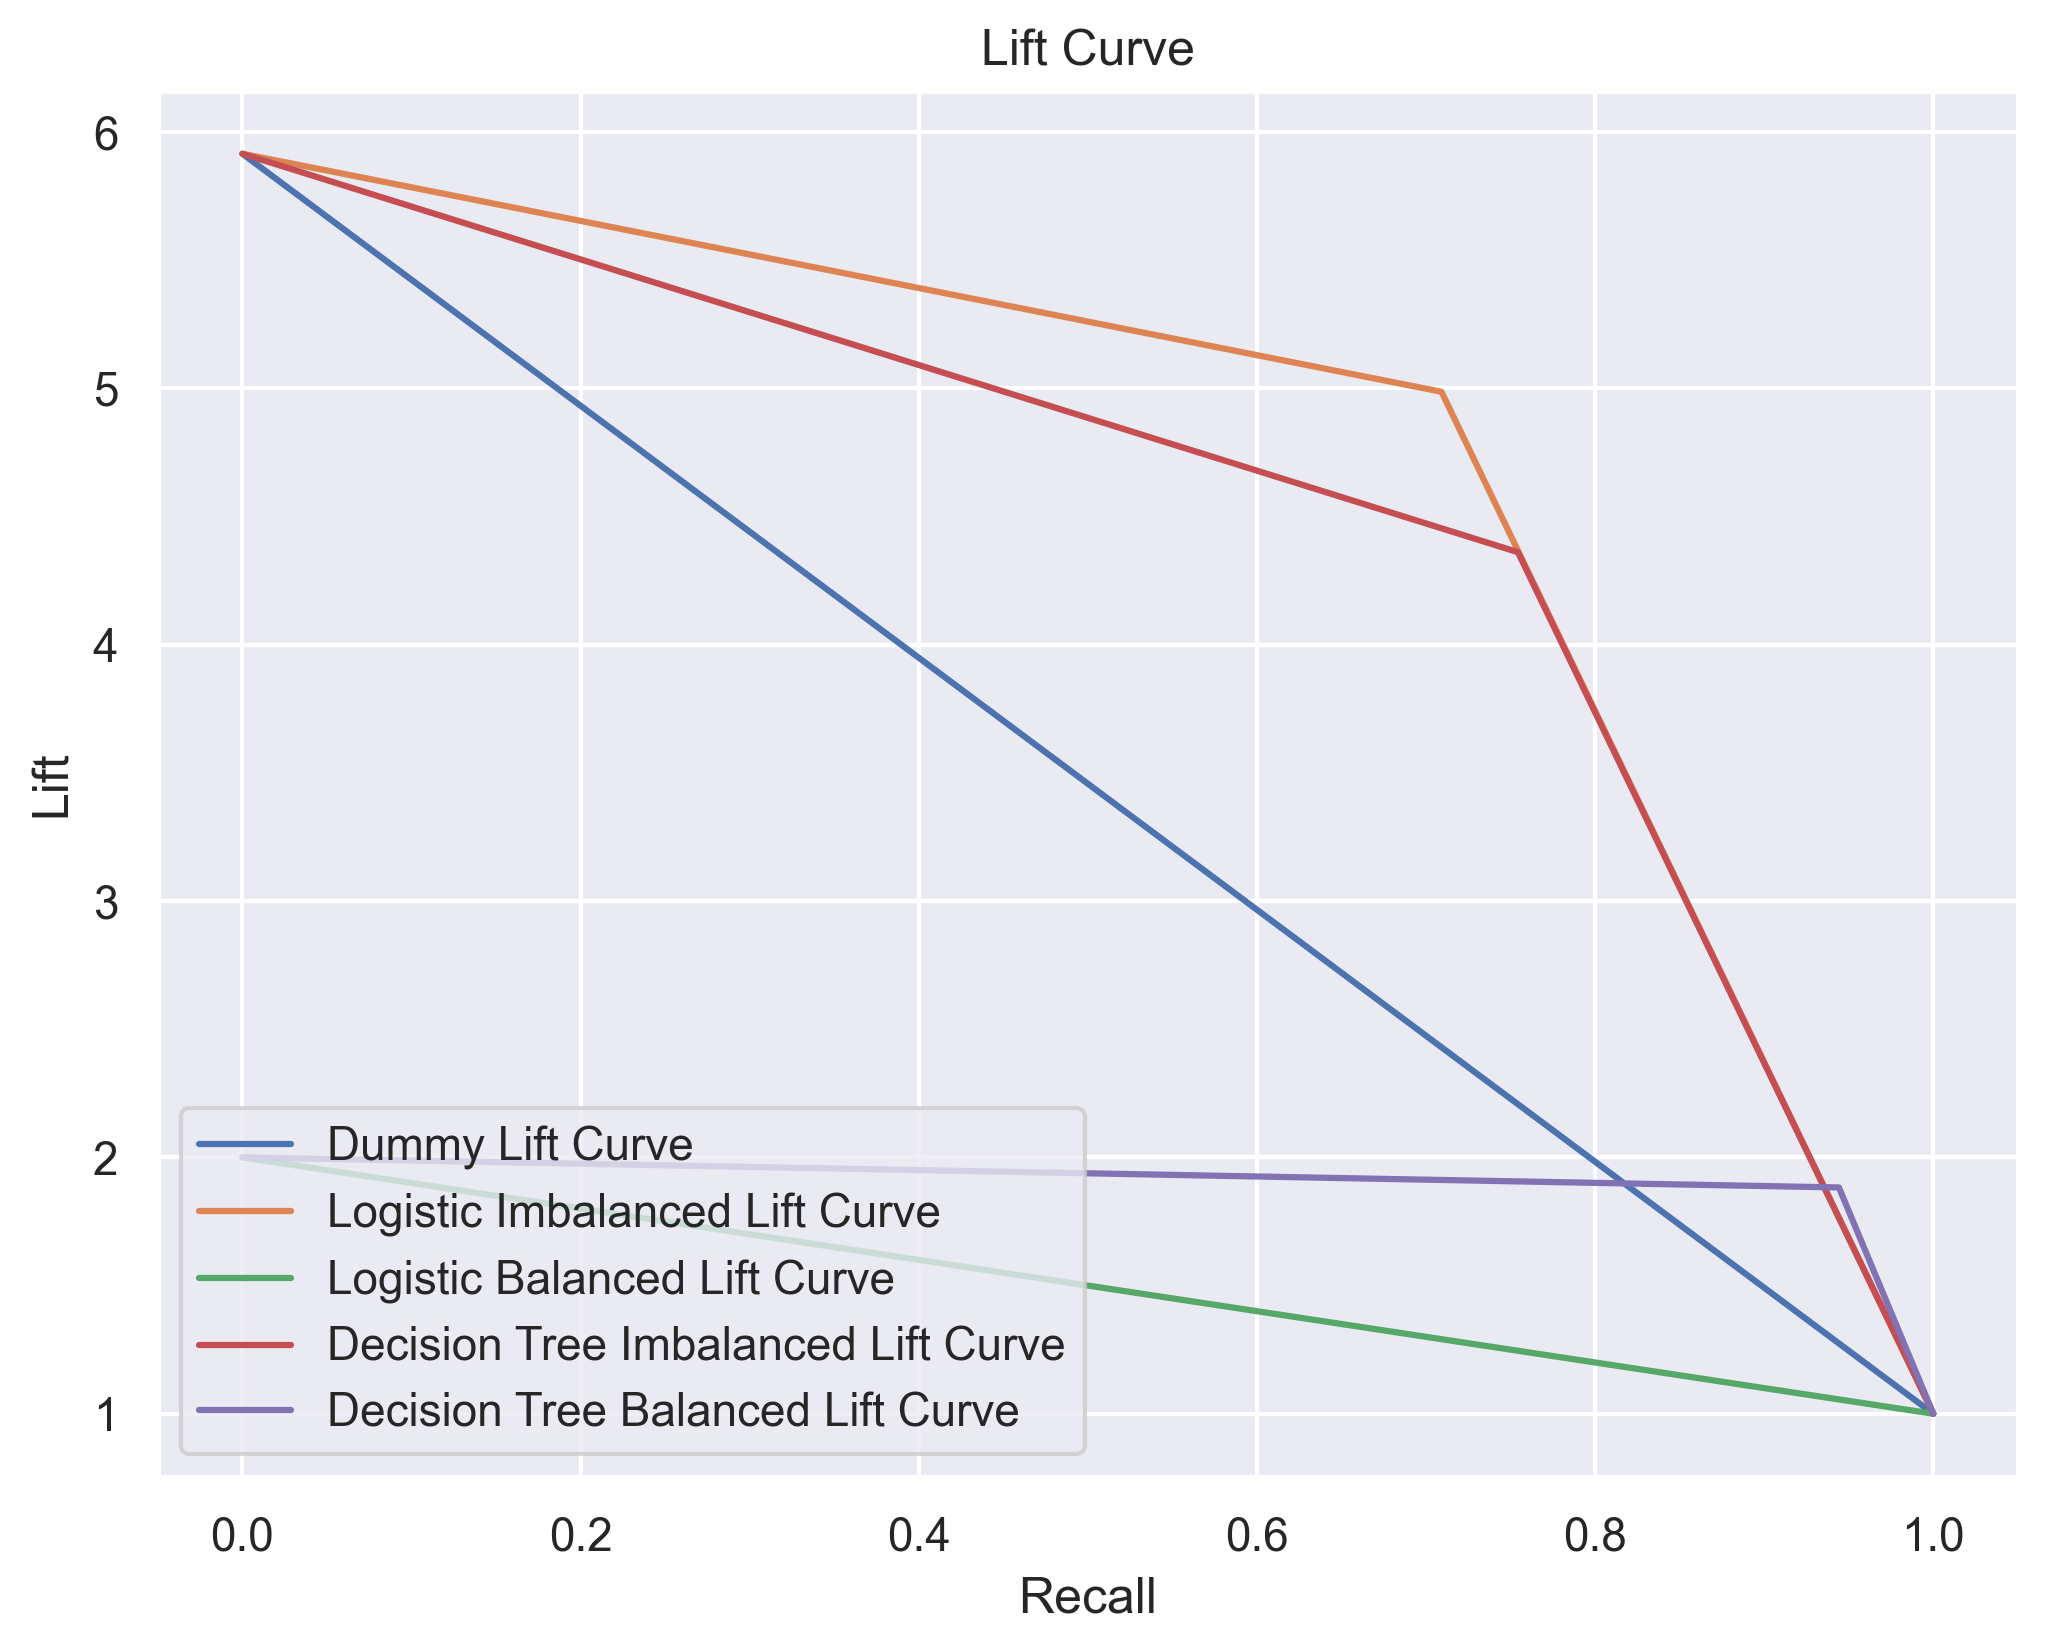

In [50]:
# 绘制 Lift 曲线
y_pred = dt_basic.predict(X_test)
precision_DB, recall_DB, thresholds_DB = precision_recall_curve(y_test, y_pred)
lift_DB = precision_DB / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_Dummy, lift_Dummy, label='Dummy Lift Curve')
plt.plot(recall_LI, lift_LI, label='Logistic Imbalanced Lift Curve')
plt.plot(recall_LB, lift_LB, label='Logistic Balanced Lift Curve')
plt.plot(recall_DI, lift_DI, label='Decision Tree Imbalanced Lift Curve')
plt.plot(recall_DB, lift_DB, label='Decision Tree Balanced Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="DBLift曲线.png")

<a id="6"></a>
### 3.7 随机森林（不平稳数据）
##### 模型拟合

In [51]:
## 3.6 随机森林（不平稳数据）
# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

# 调参

# 建模拟合
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# 模型预测
y_pred = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print("预测准确率:", accuracy)

预测准确率: 0.9344533333333334


##### 混淆矩阵

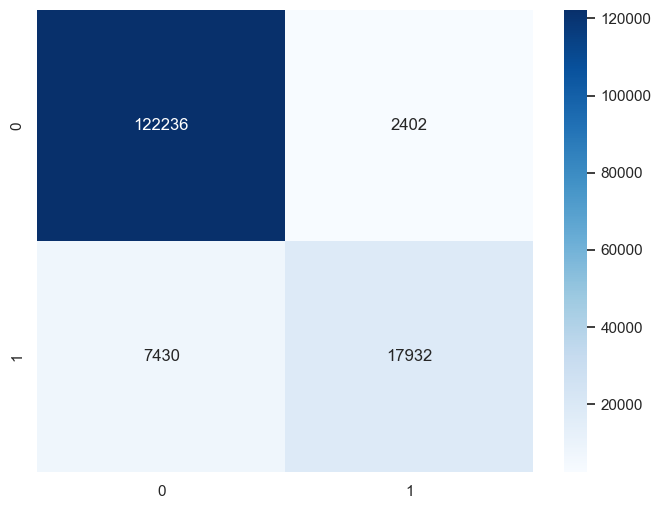

In [52]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="随机森林（不平稳数据）混淆矩阵.png")

##### 模型评估

In [53]:
temp = store_results("随机森林（不平稳数据）", y_train, X_train, y_test, X_test, model_rf, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

Model  Accuracy_train  ...  CrossVal4  CrossVal5
0   Dummy classifier            0.83  ...       0.83       0.83
1  logistic回归（不平稳数据）            0.93  ...       0.93       0.93
2   logistic回归（平稳数据）            0.50  ...       0.91       0.91
3         决策树（不平稳数据）            0.91  ...       0.92       0.91
4          决策树（平稳数据）            0.94  ...       0.94       0.94
5        随机森林（不平稳数据）            0.93  ...       0.94       0.93

[6 rows x 13 columns]

##### Lift曲线

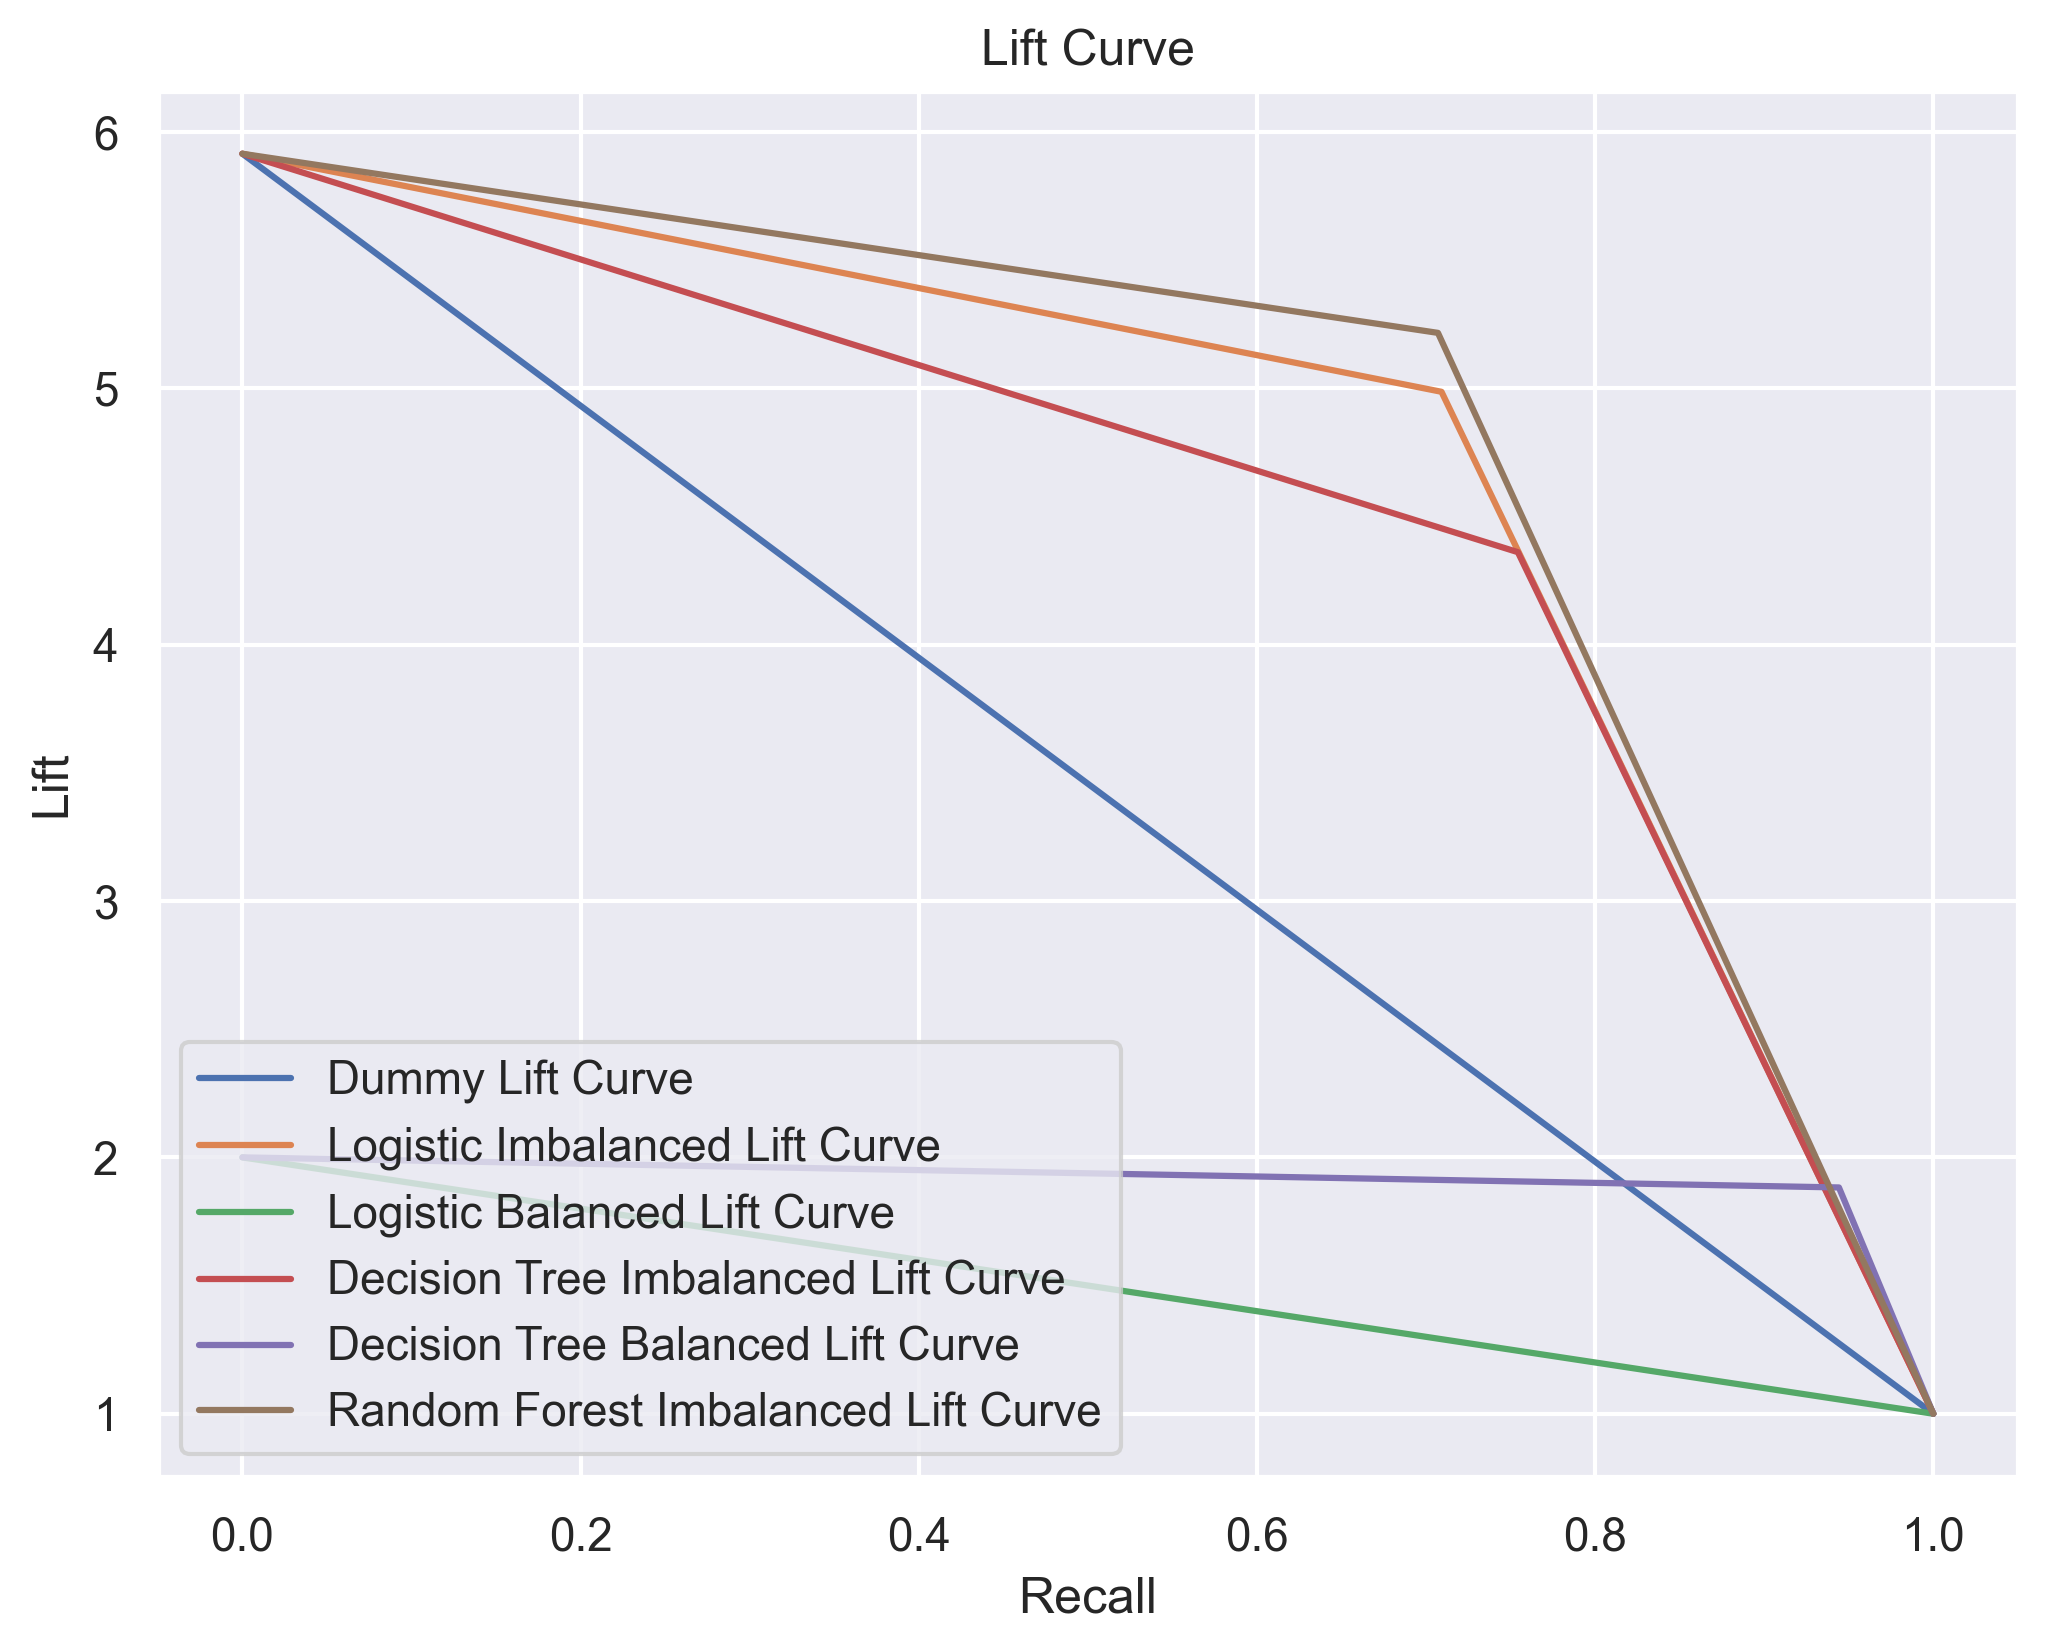

In [54]:
# 绘制 Lift 曲线
y_pred = model_rf.predict(X_test)
precision_RI, recall_RI, thresholds_RI = precision_recall_curve(y_test, y_pred)
lift_RI = precision_RI / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_Dummy, lift_Dummy, label='Dummy Lift Curve')
plt.plot(recall_LI, lift_LI, label='Logistic Imbalanced Lift Curve')
plt.plot(recall_LB, lift_LB, label='Logistic Balanced Lift Curve')
plt.plot(recall_DI, lift_DI, label='Decision Tree Imbalanced Lift Curve')
plt.plot(recall_DB, lift_DB, label='Decision Tree Balanced Lift Curve')
plt.plot(recall_RI, lift_RI, label='Random Forest Imbalanced Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="RILift曲线.png")

<a id="7"></a>
### 3.8 随机森林（平稳数据）
##### 模型拟合

In [55]:
## 3.7 随机森林（平稳数据）
# 数据划分
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

# 调参

# 建模拟合
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# 模型预测
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print("预测准确率:", accuracy)

预测准确率: 0.9565220879667518


##### 混淆矩阵

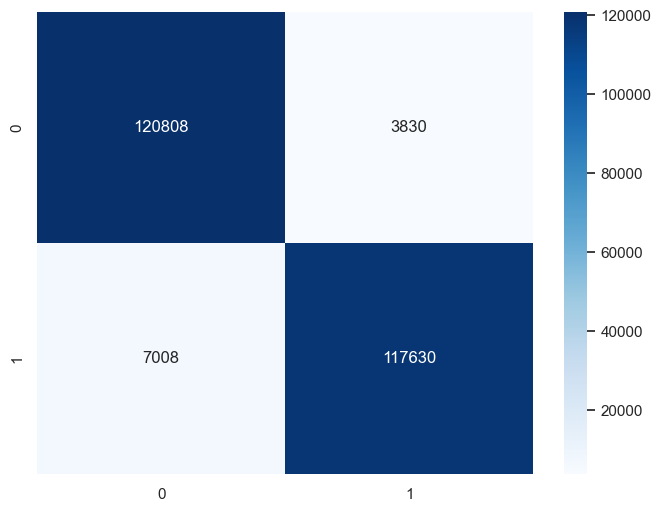

In [56]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="随机森林（平稳数据）混淆矩阵.png")

##### 模型评估

In [57]:
temp = store_results("随机森林（平稳数据）混淆矩阵", y_train, X_train, y_test, X_test, model_rf, 5)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

Model  Accuracy_train  ...  CrossVal4  CrossVal5
0   Dummy classifier            0.83  ...       0.83       0.83
1  logistic回归（不平稳数据）            0.93  ...       0.93       0.93
2   logistic回归（平稳数据）            0.50  ...       0.91       0.91
3         决策树（不平稳数据）            0.91  ...       0.92       0.91
4          决策树（平稳数据）            0.94  ...       0.94       0.94
5        随机森林（不平稳数据）            0.93  ...       0.94       0.93
6     随机森林（平稳数据）混淆矩阵            0.96  ...       0.96       0.96

[7 rows x 13 columns]

##### Lift曲线

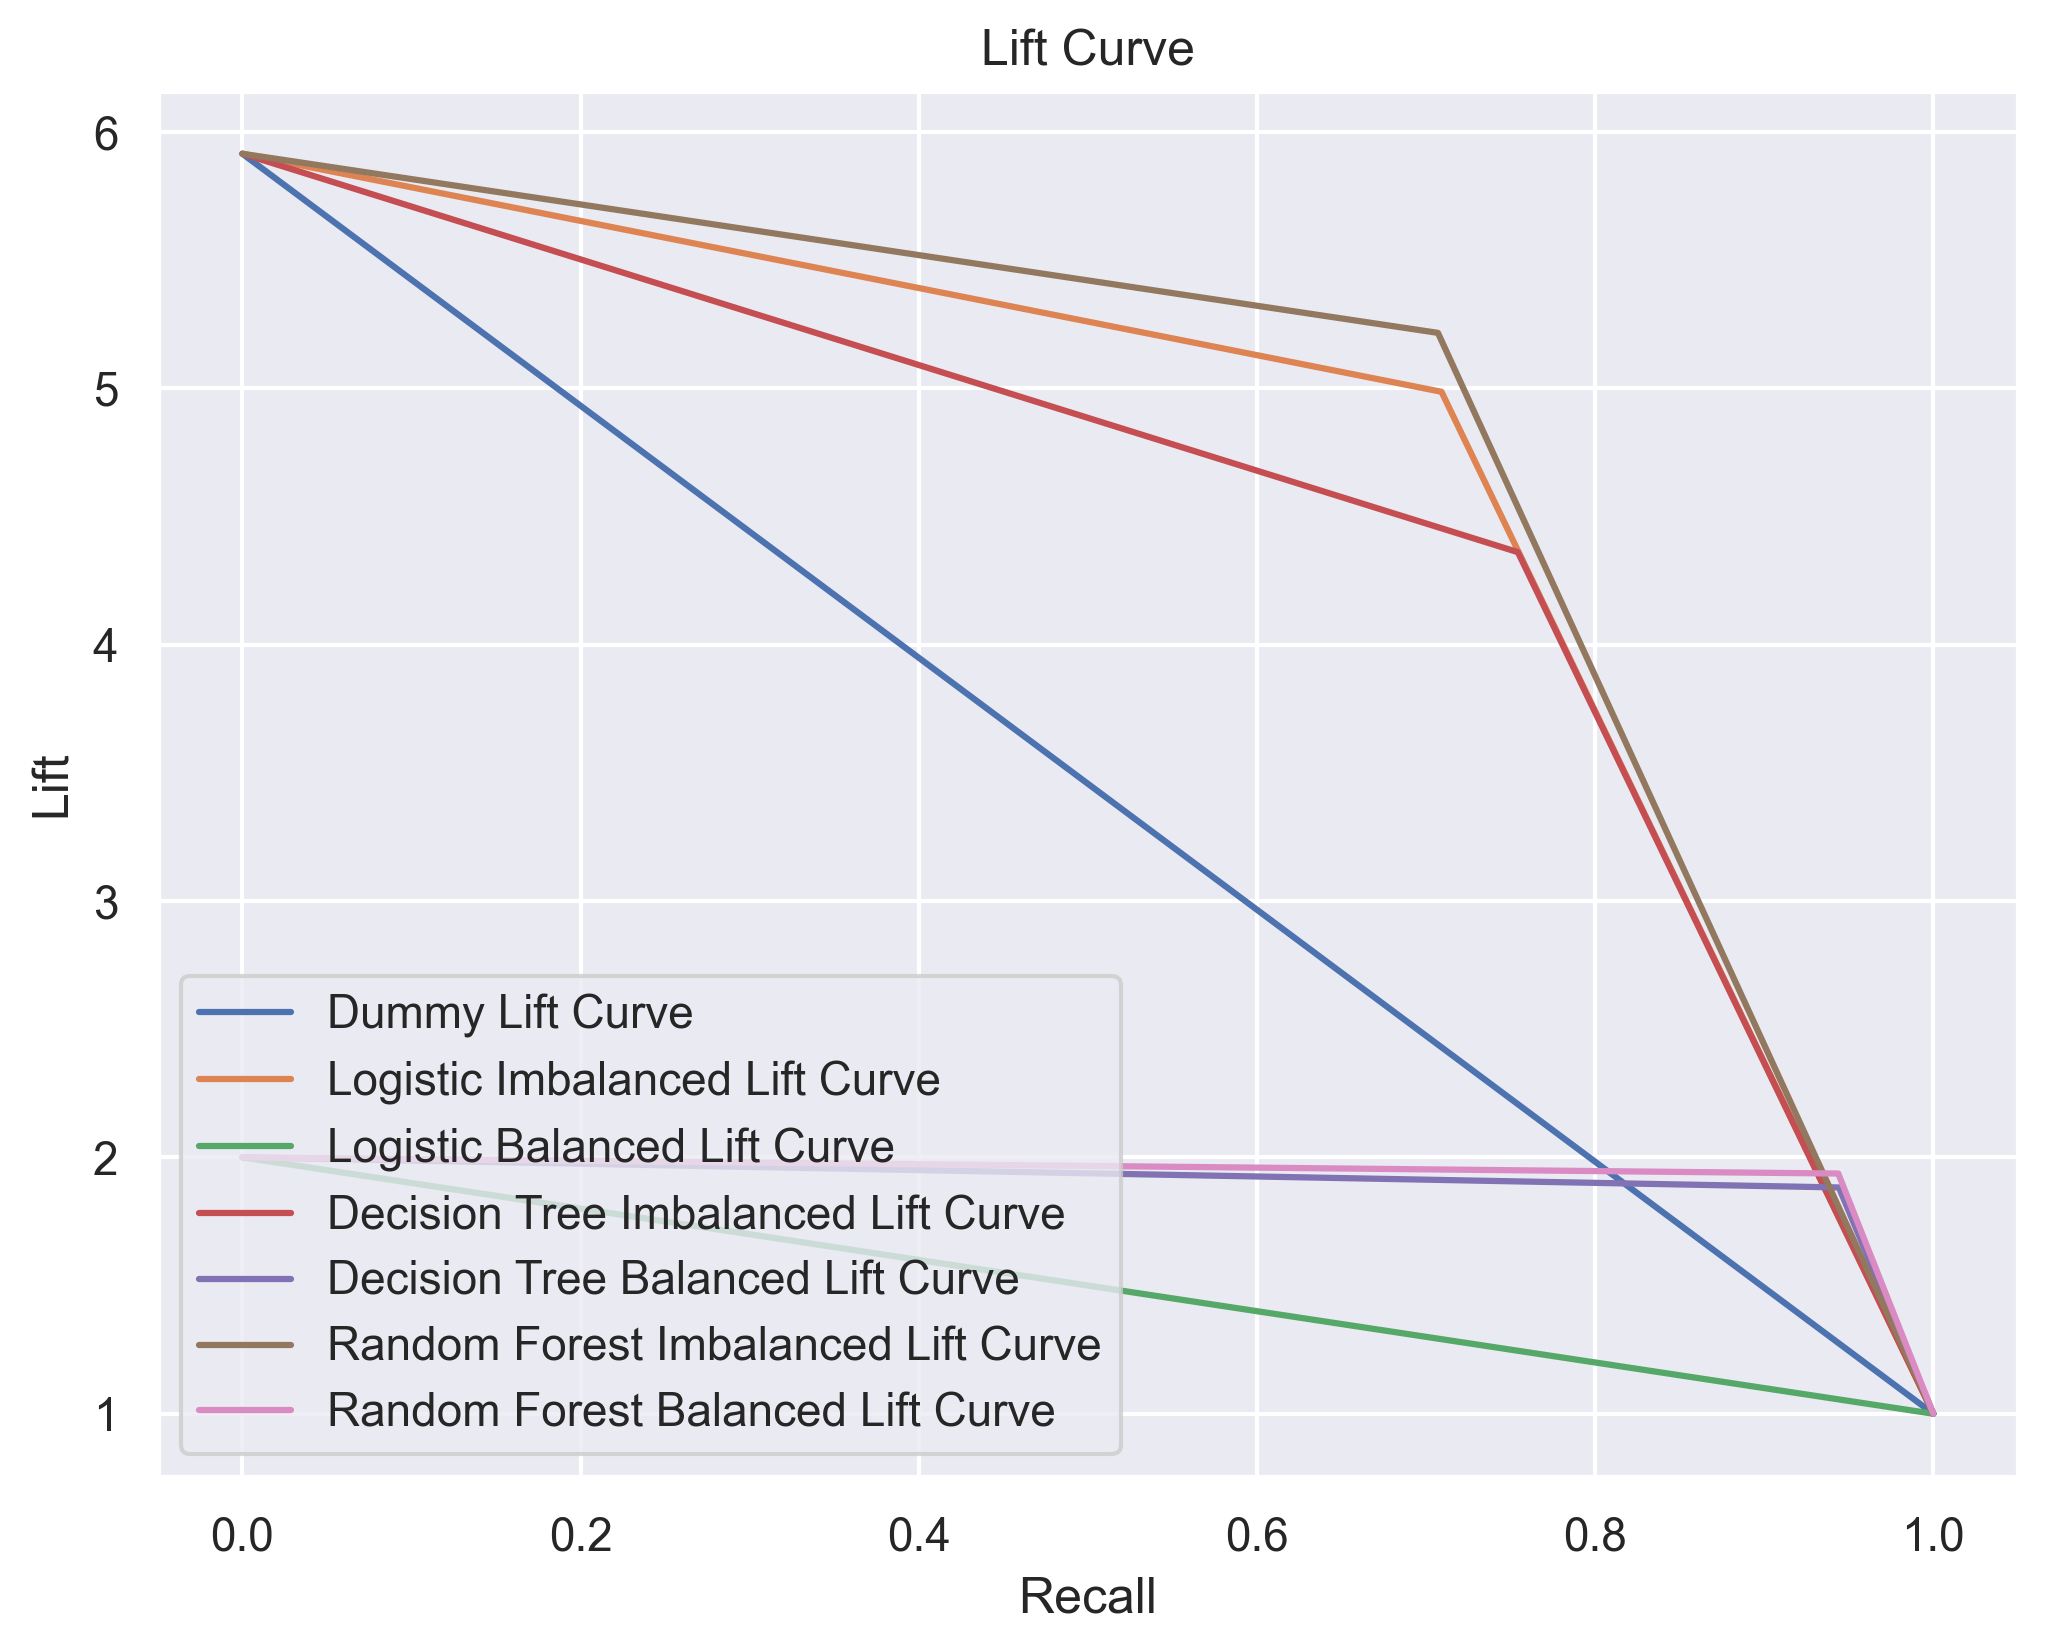

In [58]:
# 绘制 Lift 曲线
y_pred = model_rf.predict(X_test)
precision_RB, recall_RB, thresholds_RB = precision_recall_curve(y_test, y_pred)
lift_RB = precision_RB / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_Dummy, lift_Dummy, label='Dummy Lift Curve')
plt.plot(recall_LI, lift_LI, label='Logistic Imbalanced Lift Curve')
plt.plot(recall_LB, lift_LB, label='Logistic Balanced Lift Curve')
plt.plot(recall_DI, lift_DI, label='Decision Tree Imbalanced Lift Curve')
plt.plot(recall_DB, lift_DB, label='Decision Tree Balanced Lift Curve')
plt.plot(recall_RI, lift_RI, label='Random Forest Imbalanced Lift Curve')
plt.plot(recall_RB, lift_RB, label='Random Forest Balanced Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="RBLift曲线.png")

**探索后发现过采样的效果有明显提升，后续都使用过采样数据**

## 四、CTR模型
### 4.1 特征工程
#### 4.1.1 SMOTE过采样

原始数据形状  Counter({0: 415459, 1: 84541})
过采用数据形状 Counter({0: 415459, 1: 415459})


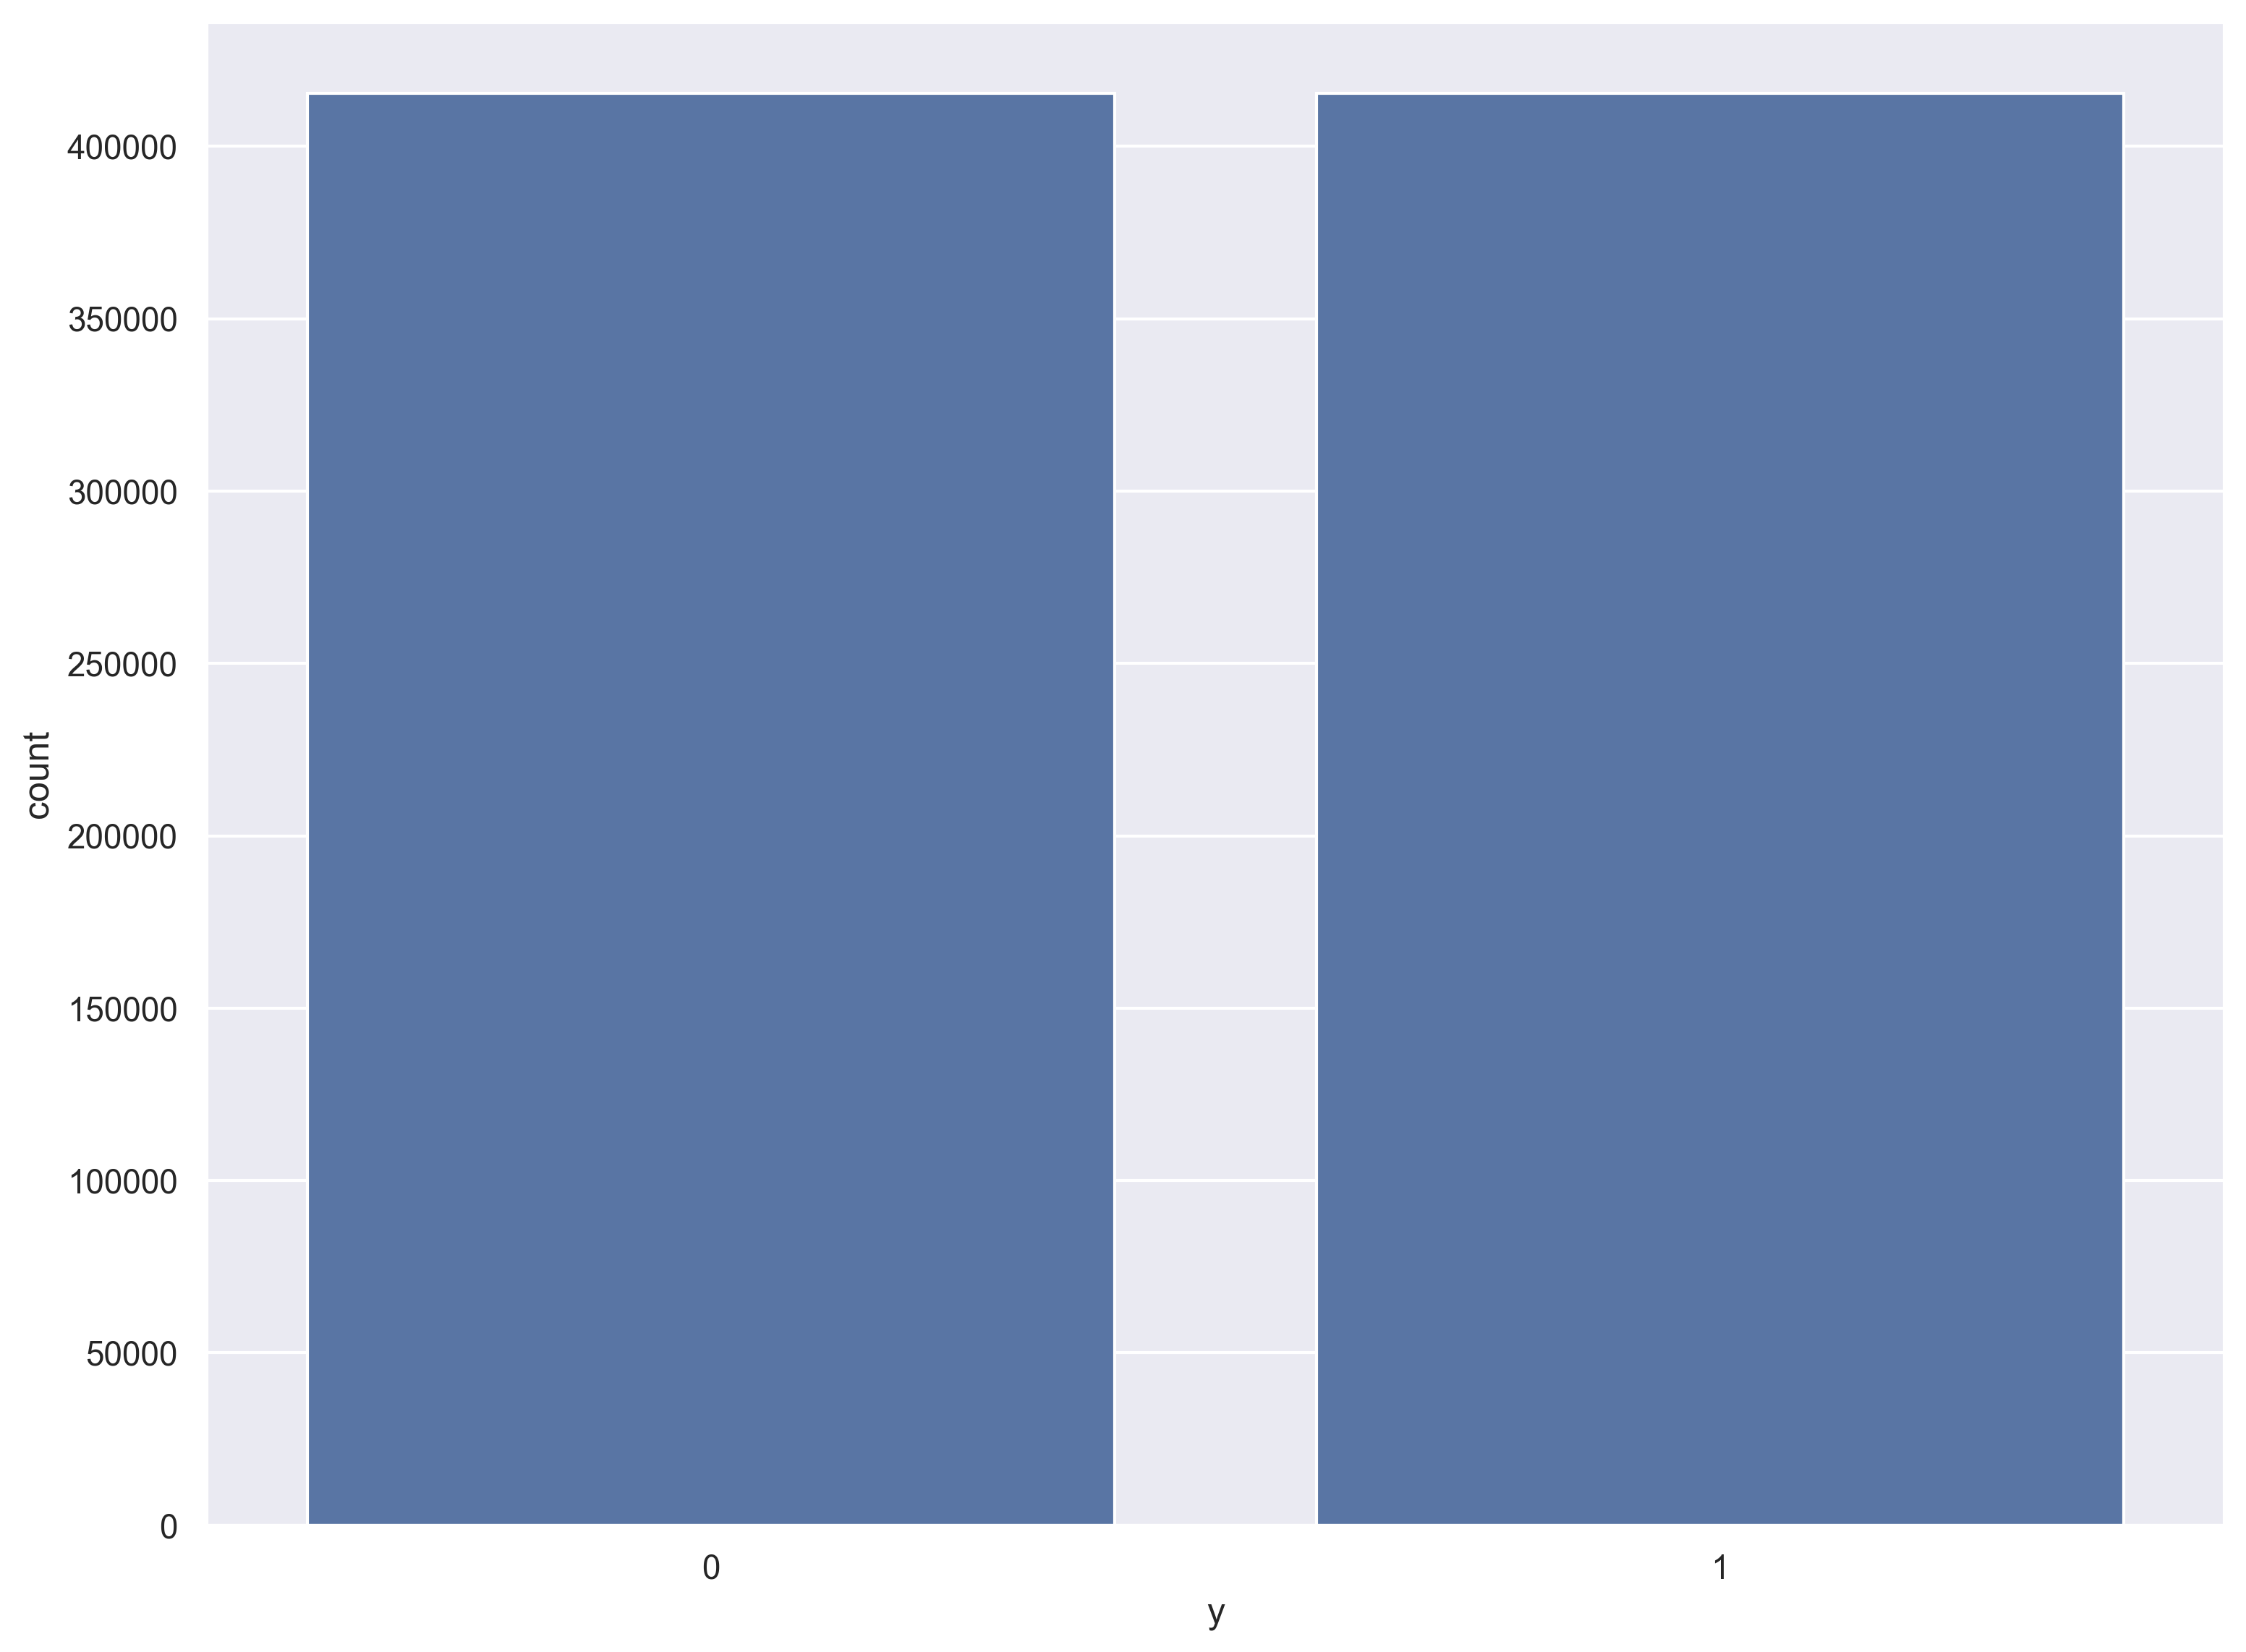

In [59]:
####--------------------------------------------4、CTR模型--------------------------------------------####

## 特征工程
# SMOTE过采样
randomsample=  SMOTE()
x_new, y_new = randomsample.fit_resample(X, y)

print('原始数据形状  {}'.format(Counter(y)))
print('过采用数据形状 {}'.format(Counter(y_new)))
plt.figure(figsize=(12, 9), dpi=300)
sns.countplot(x=y_new)
plt.savefig(fname="过采样后click分布.png")

#### 4.1.2 数据划分

In [60]:
# 数据划分
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

#### 4.1.3 最大最小归一化

In [61]:
# 归一化
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

#### 4.1.4 区分稀疏特征和密集特征

In [62]:
# 特征预处理
# 区分稀疏特征和密集特征
sparse_features = [feat for feat in categorical if feat in X_train.columns]
dense_features = [feat for feat in numerical if feat in X_train.columns]

sparse_feature_columns = [SparseFeat(feat, vocabulary_size=X_train[feat].nunique(), embedding_dim=4) for feat in sparse_features]
dense_feature_columns = [DenseFeat(feat, 1) for feat in dense_features]

# 组合特征
feature_columns = sparse_feature_columns + dense_feature_columns
feature_names = get_feature_names(feature_columns)

# 数据转换
train_model_input = {name: X_train[name].values for name in feature_names}
test_model_input = {name: X_test[name].values for name in feature_names}

<a id="8"></a>
### 4.2 AFM
效果并不好，那就作为基模型对比
##### 模型拟合

In [63]:
## AFM
model_afm = AFM(sparse_feature_columns, sparse_feature_columns, task='binary')

model_afm.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy', 'auc'])
history = model_afm.fit(train_model_input, y_train.values, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

cpu
Train on 465313 samples, validate on 116329 samples, 909 steps per epoch



09it [00:20, 44.42it/s]

Epoch 1/10
20s - loss:  0.6921 - binary_crossentropy:  0.6921 - auc:  0.5078 - val_binary_crossentropy:  0.6915 - val_auc:  0.5076



09it [00:18, 50.48it/s]

Epoch 2/10
19s - loss:  0.6915 - binary_crossentropy:  0.6915 - auc:  0.5078 - val_binary_crossentropy:  0.6915 - val_auc:  0.5076



09it [00:21, 43.03it/s]

Epoch 3/10
21s - loss:  0.6914 - binary_crossentropy:  0.6914 - auc:  0.5079 - val_binary_crossentropy:  0.6914 - val_auc:  0.5076



09it [00:20, 43.44it/s]

Epoch 4/10
22s - loss:  0.6914 - binary_crossentropy:  0.6914 - auc:  0.5078 - val_binary_crossentropy:  0.6915 - val_auc:  0.5076



09it [00:21, 41.64it/s]

Epoch 5/10
22s - loss:  0.6914 - binary_crossentropy:  0.6914 - auc:  0.5078 - val_binary_crossentropy:  0.6915 - val_auc:  0.5076



09it [00:22, 39.68it/s]

Epoch 6/10
23s - loss:  0.6914 - binary_crossentropy:  0.6914 - auc:  0.5079 - val_binary_crossentropy:  0.6914 - val_auc:  0.5076



09it [00:20, 43.97it/s]

Epoch 7/10
21s - loss:  0.6914 - binary_crossentropy:  0.6914 - auc:  0.5079 - val_binary_crossentropy:  0.6915 - val_auc:  0.5076



09it [00:19, 45.56it/s]

Epoch 8/10
20s - loss:  0.6914 - binary_crossentropy:  0.6914 - auc:  0.5079 - val_binary_crossentropy:  0.6919 - val_auc:  0.5076



09it [00:23, 39.48it/s]

Epoch 9/10
23s - loss:  0.6914 - binary_crossentropy:  0.6914 - auc:  0.5079 - val_binary_crossentropy:  0.6914 - val_auc:  0.5076



09it [00:17, 51.01it/s]

Epoch 10/10
19s - loss:  0.6914 - binary_crossentropy:  0.6914 - auc:  0.5079 - val_binary_crossentropy:  0.6914 - val_auc:  0.5076


##### 模型预测

In [64]:
# 预测
y_pred = model_afm.predict(test_model_input, batch_size=512)
y_pred = (y_pred > 0.5).astype(int)

##### 模型评估

In [65]:
# 评估
print("Accuracy:", accuracy_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.508091432789358
Confusion Matrix:
 [[  3217 121421]
 [  1200 123438]]
AUC Score: 0.508091432789358


##### 混淆矩阵

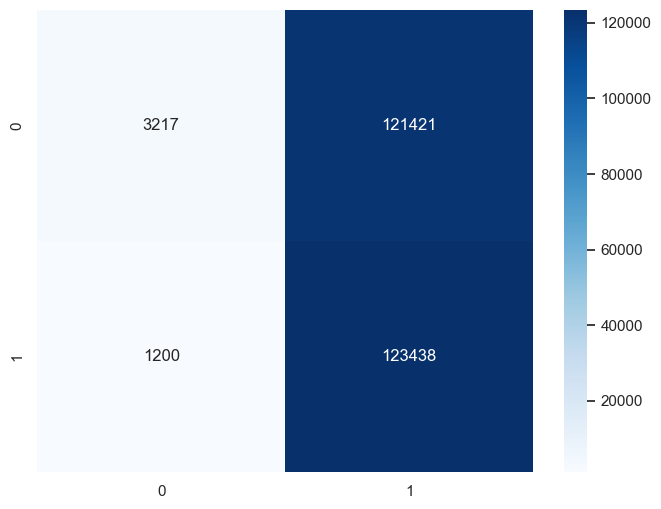

In [66]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="AFM混淆矩阵.png")

##### Lift曲线

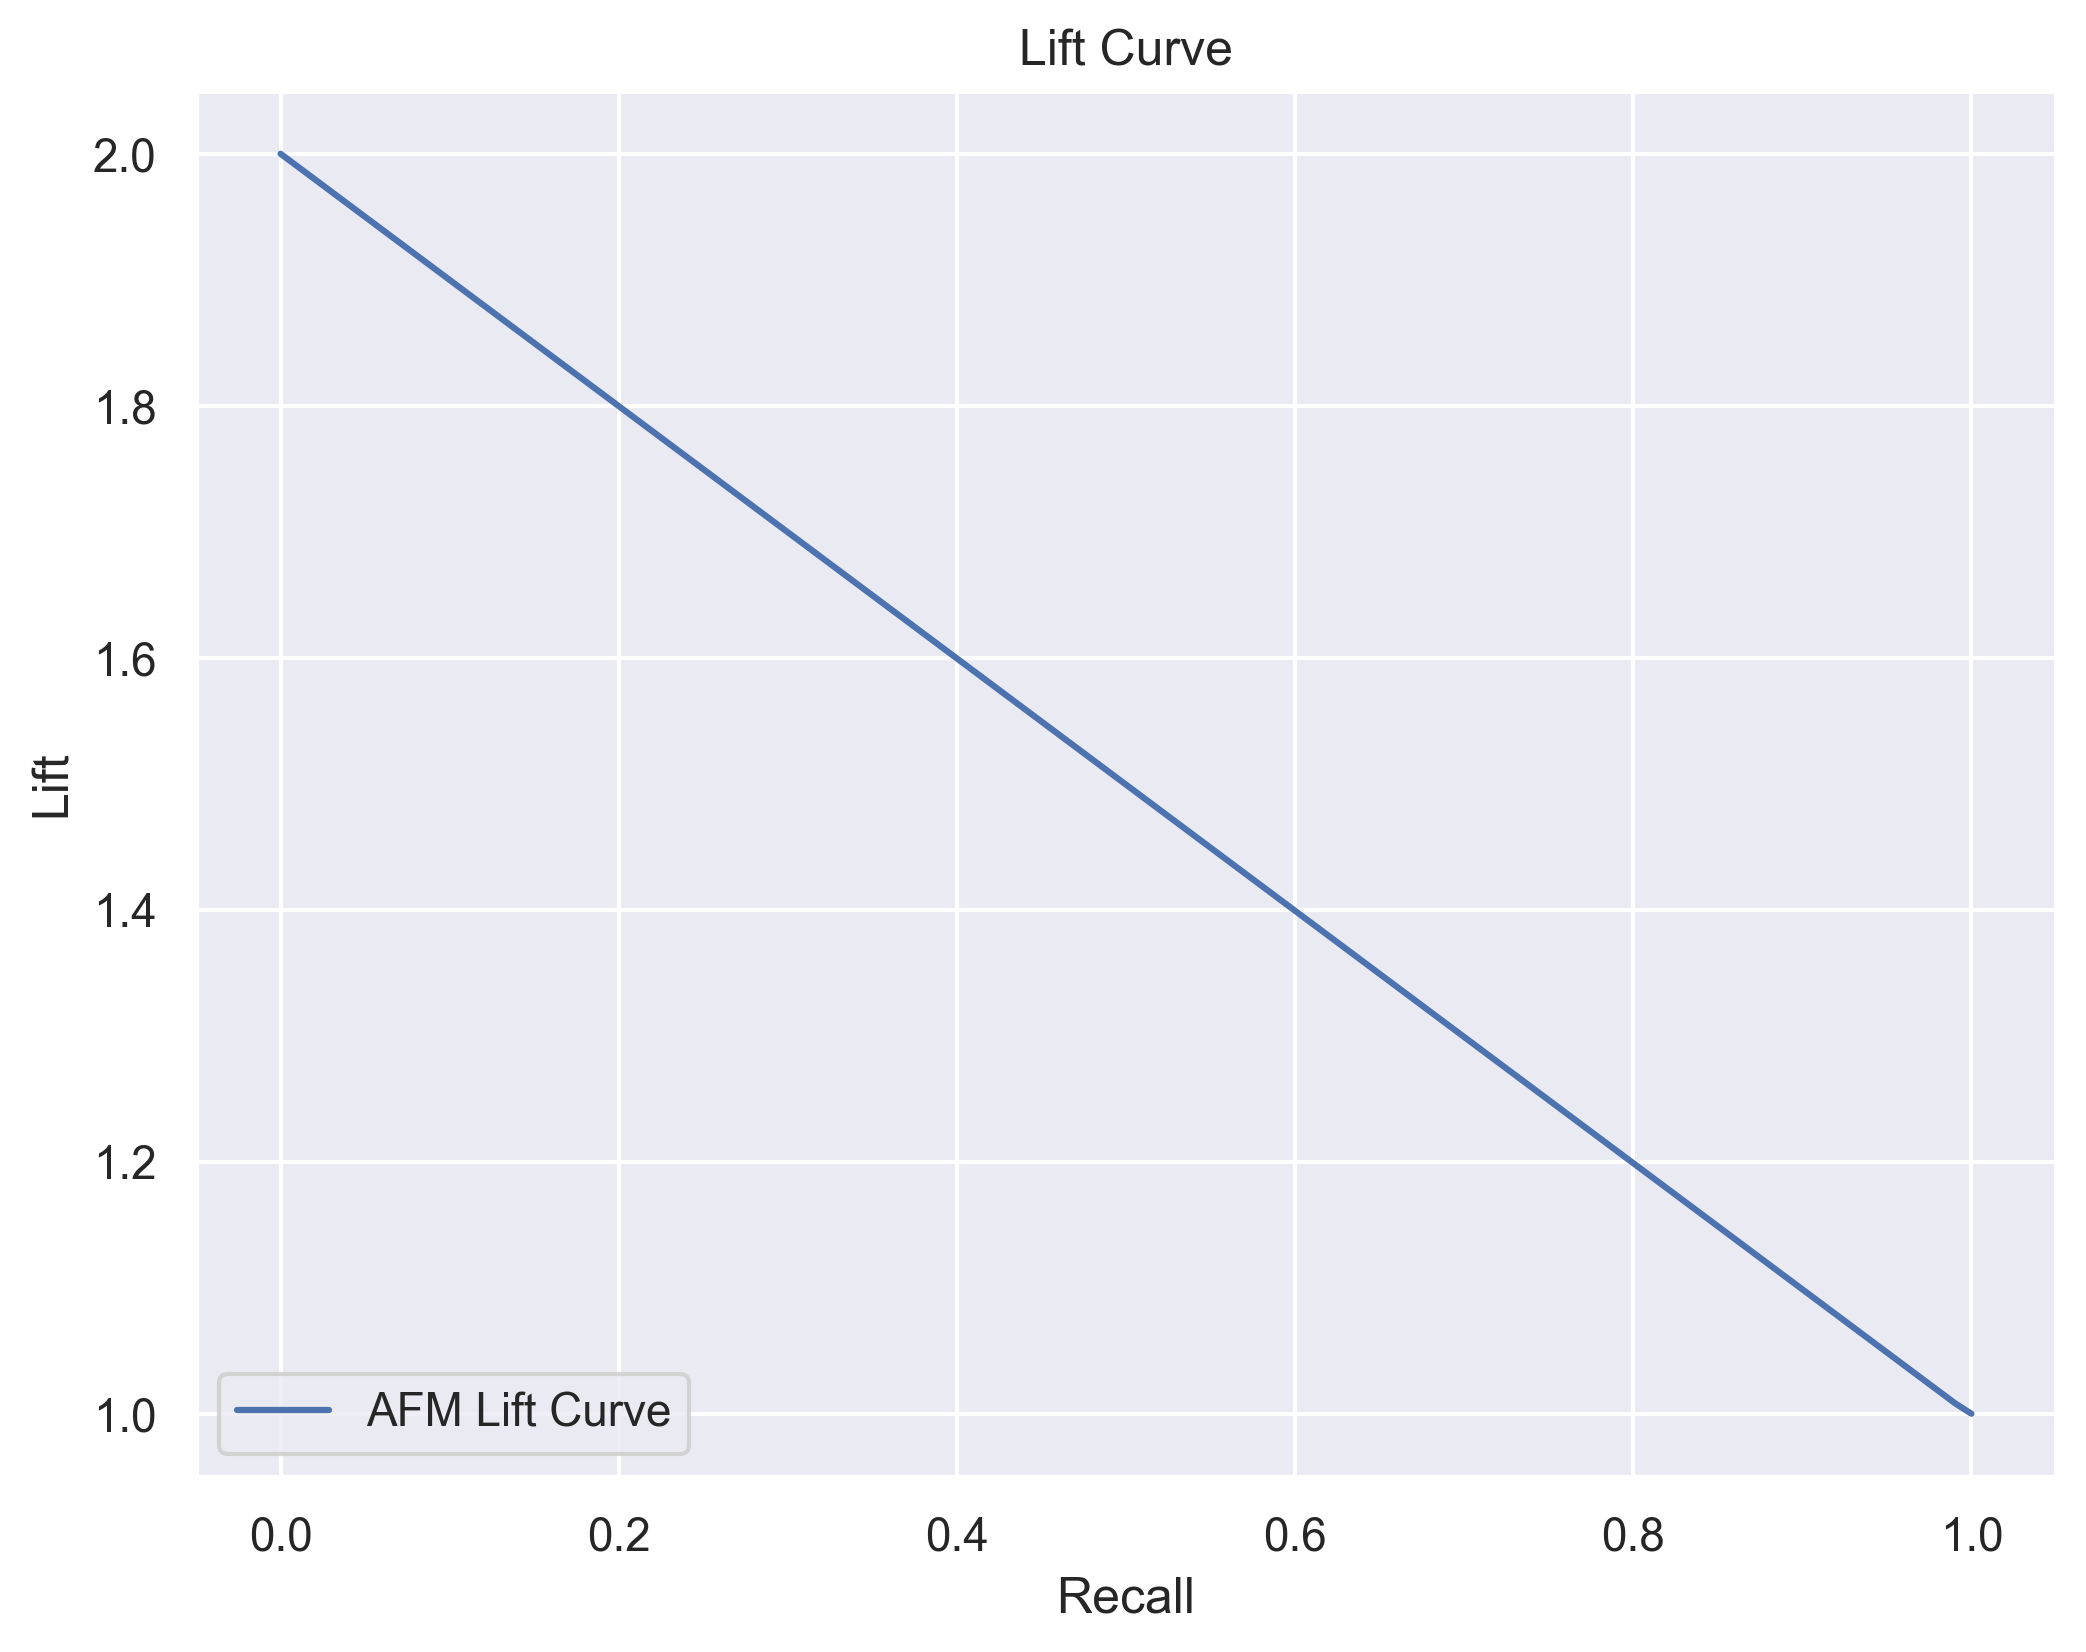

In [67]:
# 绘制 Lift 曲线
precision_AFM, recall_AFM, thresholds_AFM = precision_recall_curve(y_test, y_pred)
lift_AFM = precision_AFM / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="AFMLift曲线.png")

<a id="9"></a>
### 4.3 DCN
##### 模型拟合

In [68]:
## DCN
model_dcn = DCN(feature_columns, feature_columns, task='binary')

model_dcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy', 'auc'])
history = model_dcn.fit(train_model_input, y_train.values, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

cpu
Train on 465313 samples, validate on 116329 samples, 909 steps per epoch



09it [00:19, 45.55it/s]

Epoch 1/10
20s - loss:  0.6177 - binary_crossentropy:  0.6177 - auc:  0.7169 - val_binary_crossentropy:  0.5868 - val_auc:  0.7570



09it [00:18, 49.40it/s]

Epoch 2/10
18s - loss:  0.5817 - binary_crossentropy:  0.5817 - auc:  0.7612 - val_binary_crossentropy:  0.5761 - val_auc:  0.7668



09it [00:19, 46.61it/s]

Epoch 3/10
21s - loss:  0.5717 - binary_crossentropy:  0.5717 - auc:  0.7708 - val_binary_crossentropy:  0.5656 - val_auc:  0.7753



09it [00:21, 42.67it/s]

Epoch 4/10
21s - loss:  0.5569 - binary_crossentropy:  0.5569 - auc:  0.7830 - val_binary_crossentropy:  0.5446 - val_auc:  0.7933



09it [00:20, 44.61it/s]

Epoch 5/10
20s - loss:  0.5316 - binary_crossentropy:  0.5316 - auc:  0.8034 - val_binary_crossentropy:  0.5189 - val_auc:  0.8120



09it [00:18, 50.12it/s]

Epoch 6/10
18s - loss:  0.5070 - binary_crossentropy:  0.5070 - auc:  0.8244 - val_binary_crossentropy:  0.4850 - val_auc:  0.8467



09it [00:21, 42.27it/s]

Epoch 7/10
21s - loss:  0.4552 - binary_crossentropy:  0.4552 - auc:  0.8594 - val_binary_crossentropy:  0.4373 - val_auc:  0.8649



09it [00:16, 54.47it/s]

Epoch 8/10
17s - loss:  0.4327 - binary_crossentropy:  0.4327 - auc:  0.8690 - val_binary_crossentropy:  0.4433 - val_auc:  0.8715



09it [00:16, 53.88it/s]

Epoch 9/10
17s - loss:  0.4234 - binary_crossentropy:  0.4234 - auc:  0.8718 - val_binary_crossentropy:  0.4217 - val_auc:  0.8722



09it [00:18, 50.45it/s]

Epoch 10/10
18s - loss:  0.4193 - binary_crossentropy:  0.4193 - auc:  0.8732 - val_binary_crossentropy:  0.4149 - val_auc:  0.8741


##### 预测

In [69]:
# 预测
y_pred = model_dcn.predict(test_model_input, batch_size=512)
y_pred = (y_pred > 0.5).astype(int)

##### 模型评估

In [70]:
# 评估
print("Accuracy:", accuracy_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.8025882957043599
Confusion Matrix:
 [[118131   6507]
 [ 42703  81935]]
AUC Score: 0.8025882957043597


##### 混淆矩阵

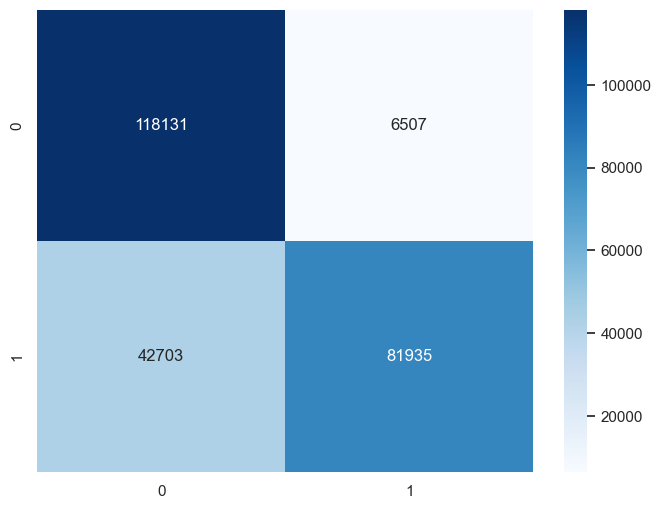

In [71]:
# 使用 seaborn 绘制混淆矩阵热图
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="DCN混淆矩阵.png")

##### Lift曲线

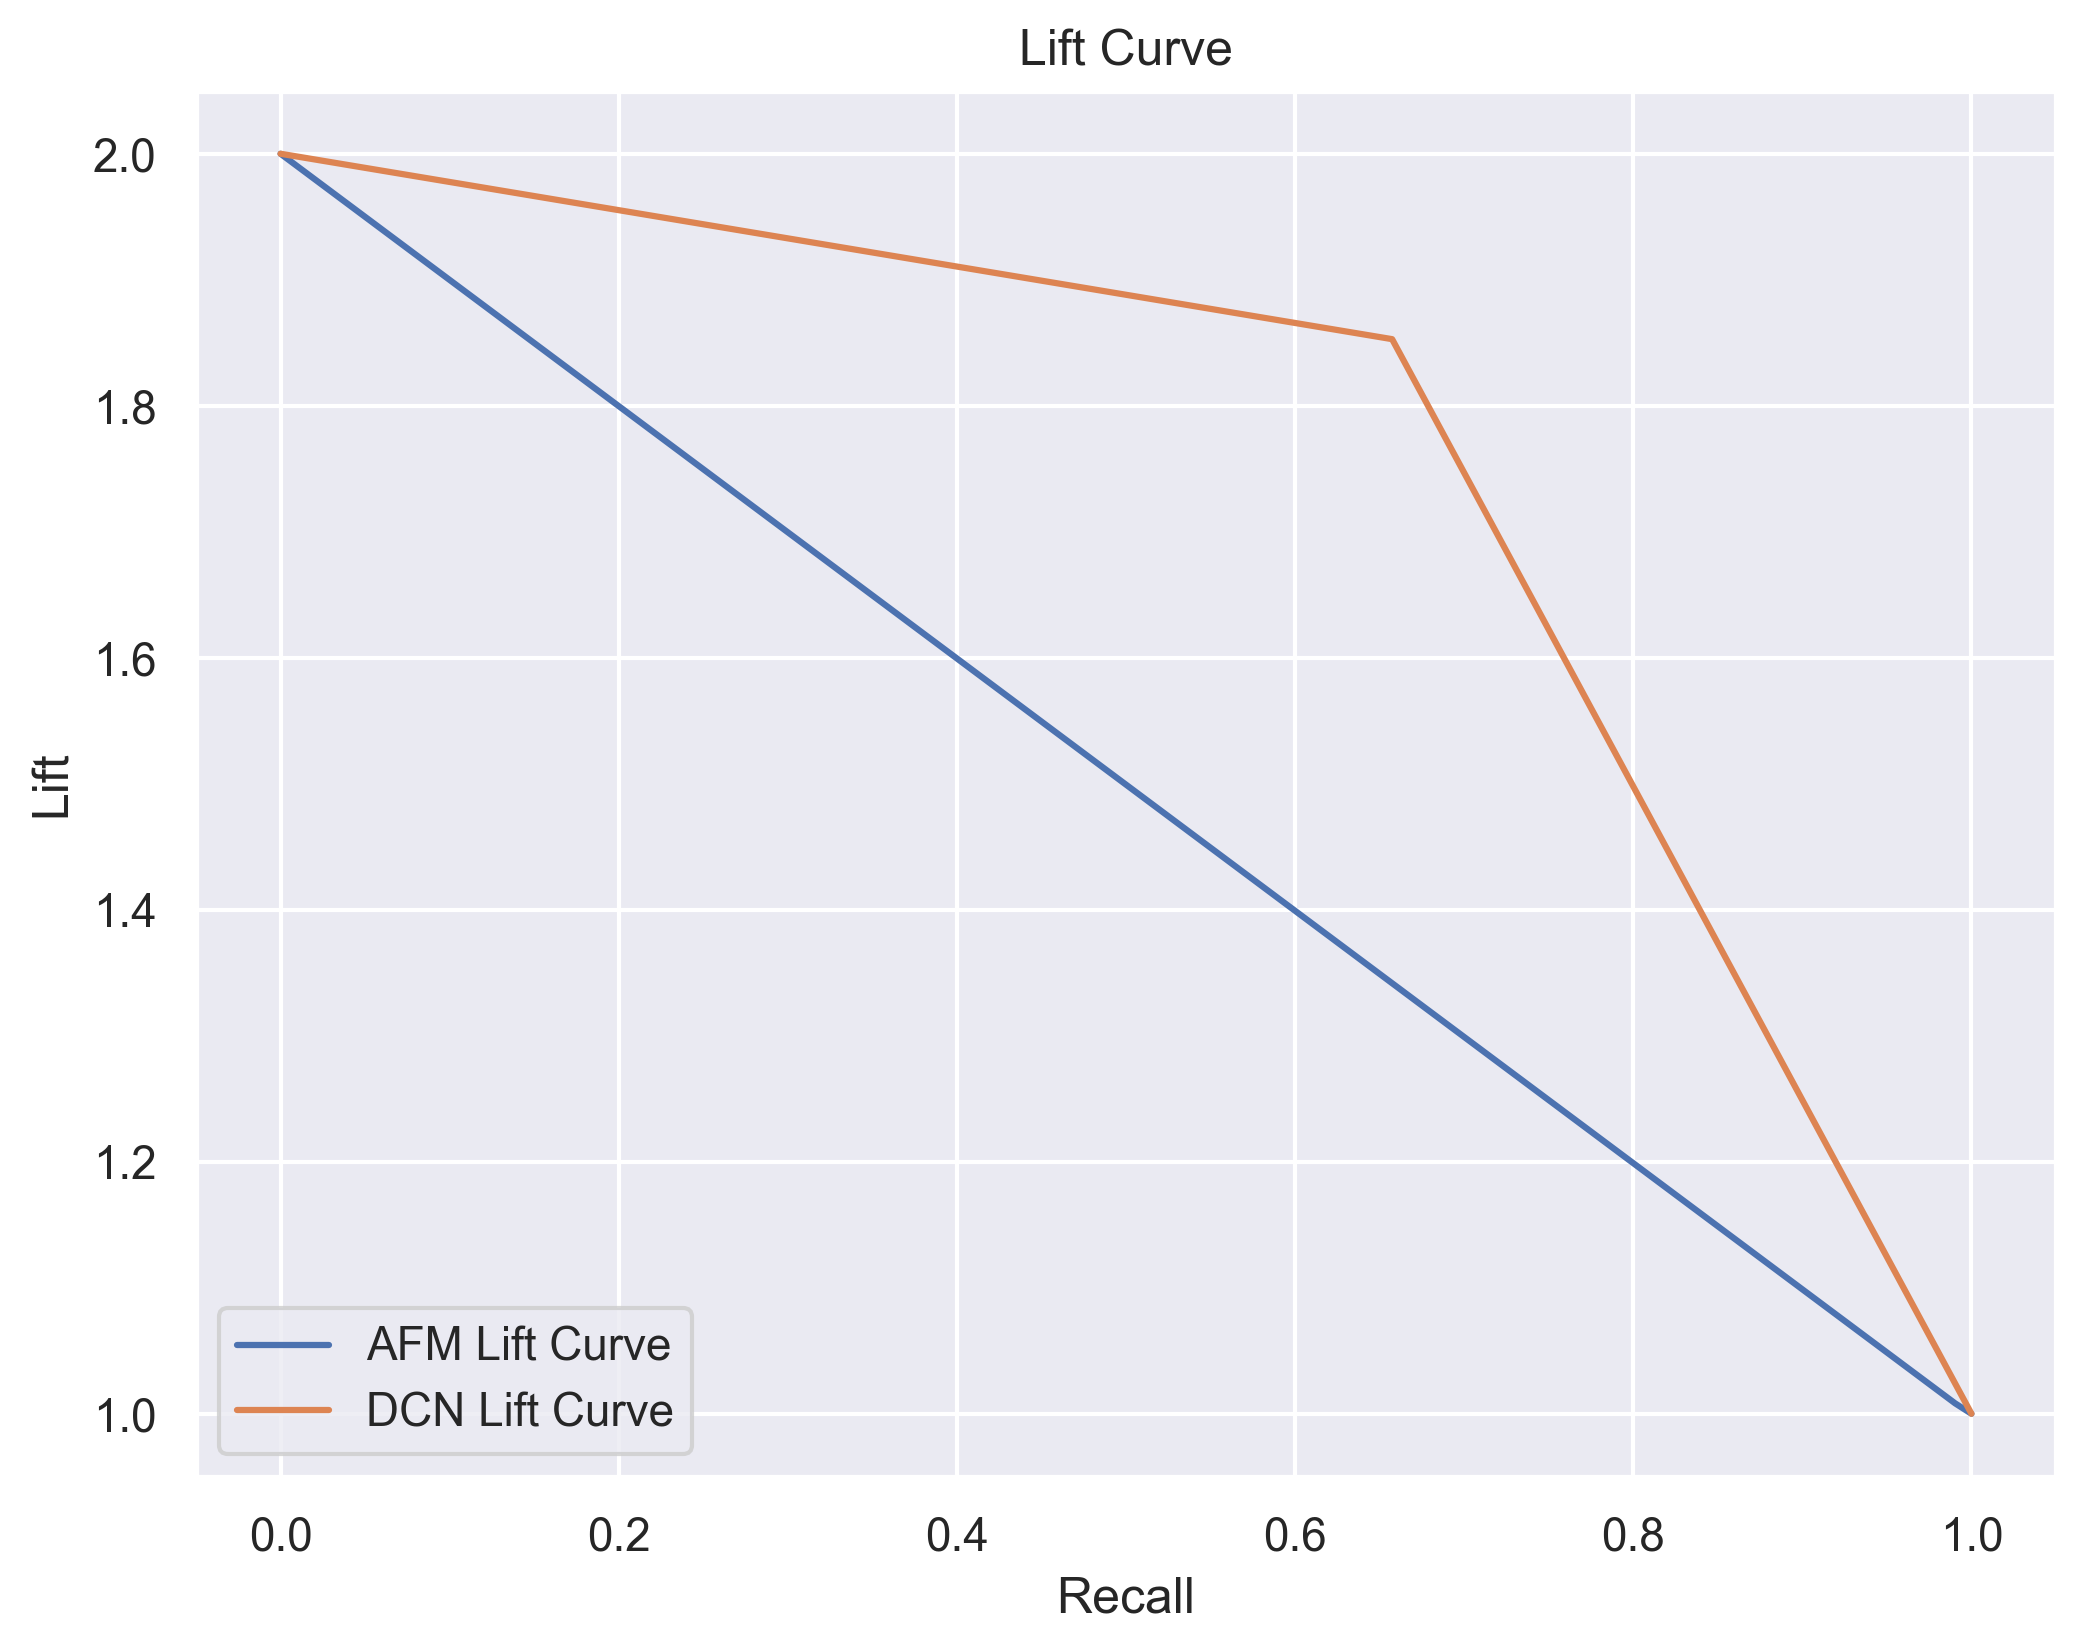

In [72]:
# 绘制 Lift 曲线
precision_DCN, recall_DCN, thresholds_DCN = precision_recall_curve(y_test, y_pred)
lift_DCN = precision_DCN / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
plt.plot(recall_DCN, lift_DCN, label='DCN Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="DCNLift曲线.png")

<a id="10"></a>
### 4.4 DCN-Mix
##### 模型拟合

In [73]:
## DCN-Mix
model_dcnmix = DCNMix(feature_columns, feature_columns, task='binary')

model_dcnmix.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy', 'auc'])
history = model_dcnmix.fit(train_model_input, y_train.values, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

cpu
Train on 465313 samples, validate on 116329 samples, 909 steps per epoch



09it [00:19, 46.00it/s]

Epoch 1/10
20s - loss:  0.5769 - binary_crossentropy:  0.5769 - auc:  0.7573 - val_binary_crossentropy:  0.5318 - val_auc:  0.7993



09it [00:20, 45.28it/s]

Epoch 2/10
20s - loss:  0.4967 - binary_crossentropy:  0.4967 - auc:  0.8256 - val_binary_crossentropy:  0.4350 - val_auc:  0.8620



09it [00:20, 43.49it/s]

Epoch 3/10
21s - loss:  0.4375 - binary_crossentropy:  0.4375 - auc:  0.8604 - val_binary_crossentropy:  0.4252 - val_auc:  0.8678



09it [00:20, 45.41it/s]

Epoch 4/10
20s - loss:  0.4284 - binary_crossentropy:  0.4284 - auc:  0.8651 - val_binary_crossentropy:  0.4191 - val_auc:  0.8711



09it [00:21, 41.99it/s]

Epoch 5/10
22s - loss:  0.4235 - binary_crossentropy:  0.4234 - auc:  0.8681 - val_binary_crossentropy:  0.4166 - val_auc:  0.8716



09it [00:19, 45.54it/s]

Epoch 6/10
20s - loss:  0.4202 - binary_crossentropy:  0.4202 - auc:  0.8701 - val_binary_crossentropy:  0.4122 - val_auc:  0.8745



09it [00:21, 42.52it/s]

Epoch 7/10
21s - loss:  0.4154 - binary_crossentropy:  0.4154 - auc:  0.8730 - val_binary_crossentropy:  0.4078 - val_auc:  0.8776



09it [00:20, 44.79it/s]

Epoch 8/10
22s - loss:  0.4111 - binary_crossentropy:  0.4111 - auc:  0.8754 - val_binary_crossentropy:  0.4048 - val_auc:  0.8773



09it [00:20, 45.07it/s]

Epoch 9/10
20s - loss:  0.4074 - binary_crossentropy:  0.4074 - auc:  0.8777 - val_binary_crossentropy:  0.4073 - val_auc:  0.8785



09it [00:21, 43.12it/s]

Epoch 10/10
21s - loss:  0.4042 - binary_crossentropy:  0.4042 - auc:  0.8793 - val_binary_crossentropy:  0.4032 - val_auc:  0.8792


##### 预测

In [74]:
# 预测
y_pred = model_dcnmix.predict(test_model_input, batch_size=512)
y_pred = (y_pred > 0.5).astype(int)

##### 模型评估

In [75]:
# 评估
print("Accuracy:", accuracy_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.809624673053162
Confusion Matrix:
 [[117443   7195]
 [ 40261  84377]]
AUC Score: 0.809624673053162


##### 混淆矩阵

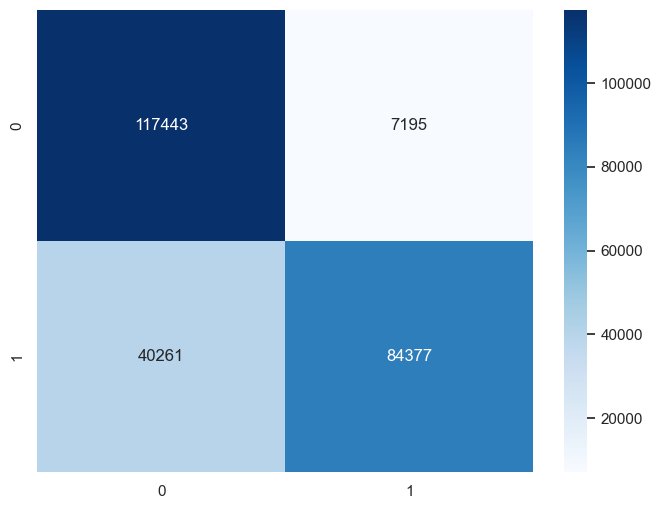

In [76]:
# 使用 seaborn 绘制混淆矩阵热图
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="DCNMIX混淆矩阵.png")

##### Lift曲线

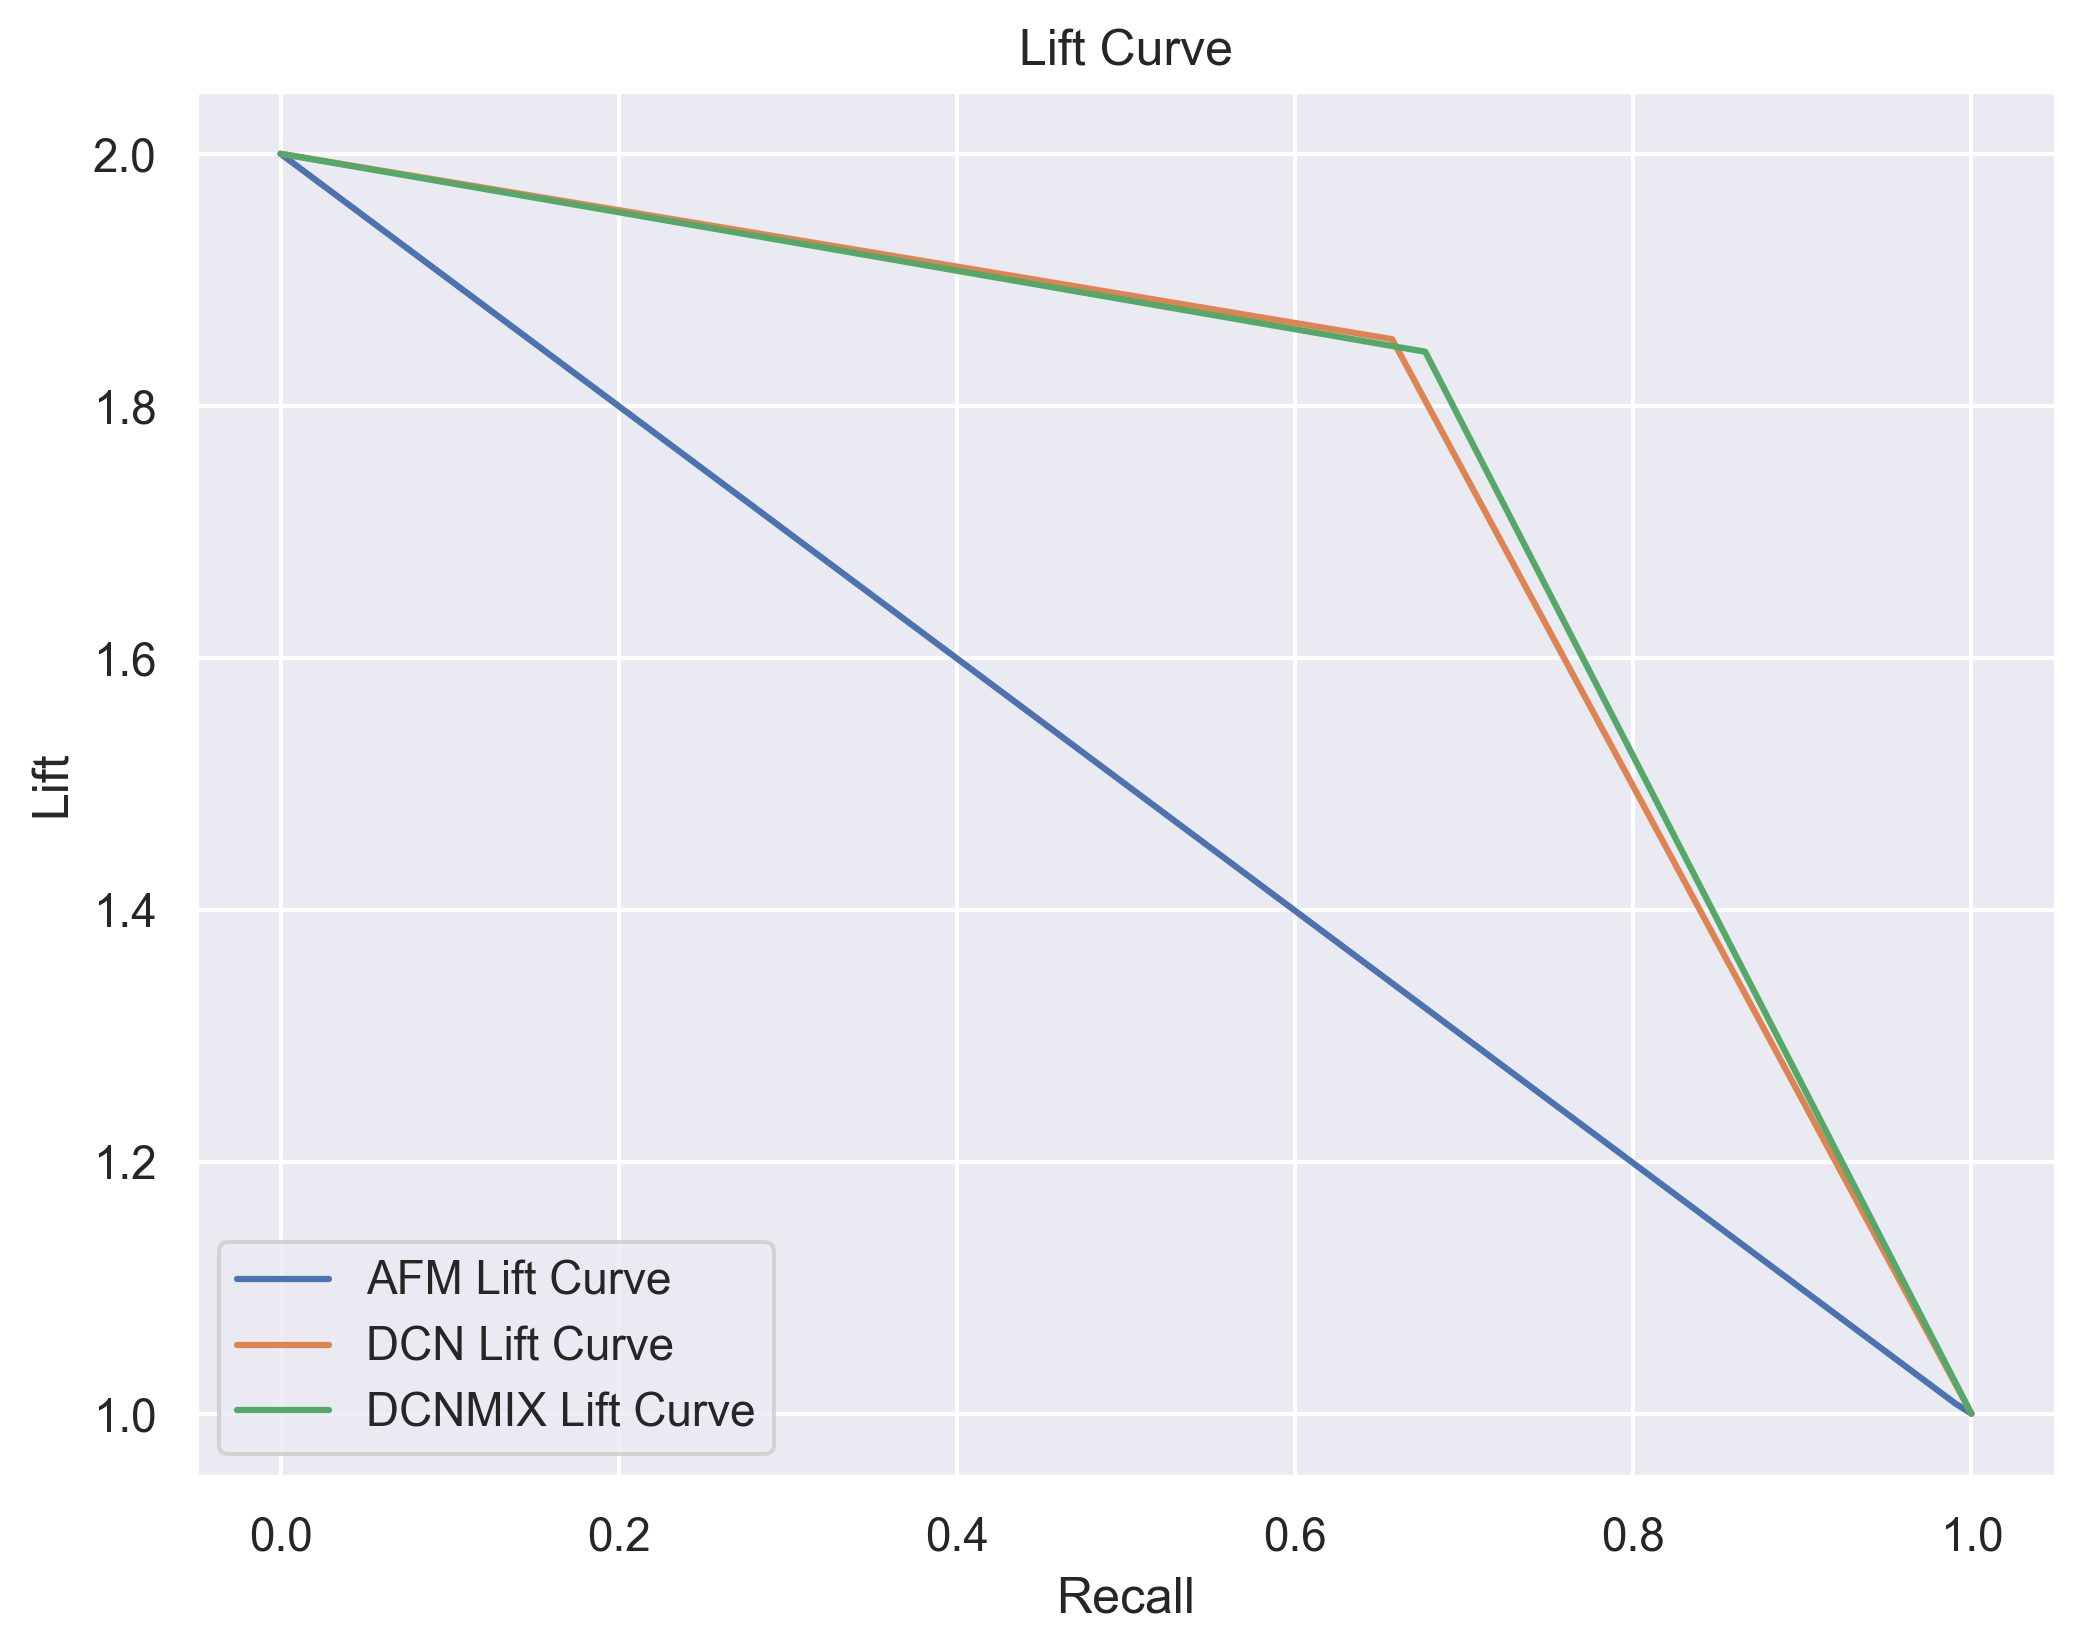

In [77]:
# 绘制 Lift 曲线
precision_DCNMIX, recall_DCNMIX, thresholds_DCNMIX = precision_recall_curve(y_test, y_pred)
lift_DCNMIX = precision_DCNMIX / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
plt.plot(recall_DCN, lift_DCN, label='DCN Lift Curve')
plt.plot(recall_DCNMIX, lift_DCNMIX, label='DCNMIX Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="DCNMIXLift曲线.png")

<a id="11"></a>
### 4.5 DeepFM
##### 模型拟合

In [78]:
## DeepFM
model_deepfm = DeepFM(feature_columns, feature_columns, task='binary')

model_deepfm.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy', 'auc'])
history = model_deepfm.fit(train_model_input, y_train.values, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

cpu
Train on 465313 samples, validate on 116329 samples, 909 steps per epoch



09it [00:17, 51.51it/s]

Epoch 1/10
17s - loss:  0.6150 - binary_crossentropy:  0.6150 - auc:  0.7253 - val_binary_crossentropy:  0.5972 - val_auc:  0.7479



09it [00:16, 54.46it/s]

Epoch 2/10
17s - loss:  0.5925 - binary_crossentropy:  0.5925 - auc:  0.7519 - val_binary_crossentropy:  0.5817 - val_auc:  0.7629



09it [00:16, 55.63it/s]

Epoch 3/10
17s - loss:  0.5736 - binary_crossentropy:  0.5736 - auc:  0.7724 - val_binary_crossentropy:  0.5666 - val_auc:  0.7788



09it [00:16, 54.99it/s]

Epoch 4/10
16s - loss:  0.5508 - binary_crossentropy:  0.5508 - auc:  0.7942 - val_binary_crossentropy:  0.5230 - val_auc:  0.8182



09it [00:16, 54.42it/s]

Epoch 5/10
17s - loss:  0.4898 - binary_crossentropy:  0.4898 - auc:  0.8425 - val_binary_crossentropy:  0.4609 - val_auc:  0.8610



09it [00:16, 55.21it/s]

Epoch 6/10
16s - loss:  0.4490 - binary_crossentropy:  0.4490 - auc:  0.8631 - val_binary_crossentropy:  0.4350 - val_auc:  0.8673



09it [00:19, 47.72it/s]

Epoch 7/10
19s - loss:  0.4323 - binary_crossentropy:  0.4323 - auc:  0.8693 - val_binary_crossentropy:  0.4410 - val_auc:  0.8728



09it [00:16, 54.12it/s]

Epoch 8/10
17s - loss:  0.4218 - binary_crossentropy:  0.4218 - auc:  0.8736 - val_binary_crossentropy:  0.4151 - val_auc:  0.8775



09it [00:16, 53.77it/s]

Epoch 9/10
17s - loss:  0.4142 - binary_crossentropy:  0.4142 - auc:  0.8767 - val_binary_crossentropy:  0.4078 - val_auc:  0.8799



09it [00:18, 49.49it/s]

Epoch 10/10
18s - loss:  0.4081 - binary_crossentropy:  0.4081 - auc:  0.8795 - val_binary_crossentropy:  0.4016 - val_auc:  0.8821


##### 预测

In [79]:
# 预测
y_pred = model_deepfm.predict(test_model_input, batch_size=512)
y_pred = (y_pred > 0.5).astype(int)

##### 模型评估

In [80]:
# 评估
print("Accuracy:", accuracy_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.8159750637847205
Confusion Matrix:
 [[116712   7926]
 [ 37947  86691]]
AUC Score: 0.8159750637847206


##### 混淆矩阵

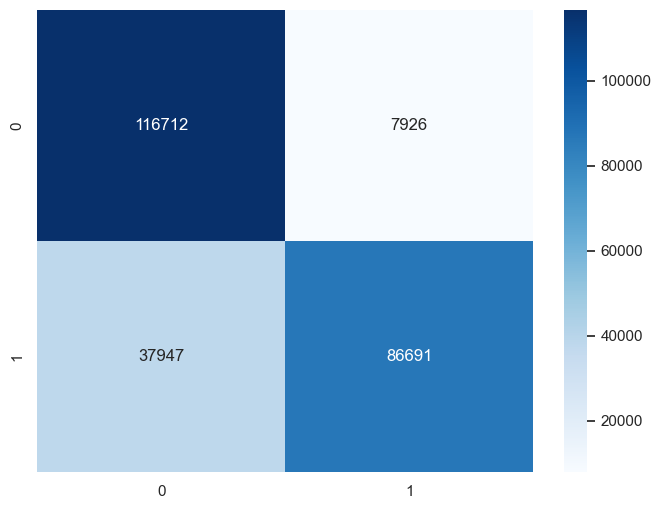

In [81]:
# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="DeepFM混淆矩阵.png")

##### Lift曲线

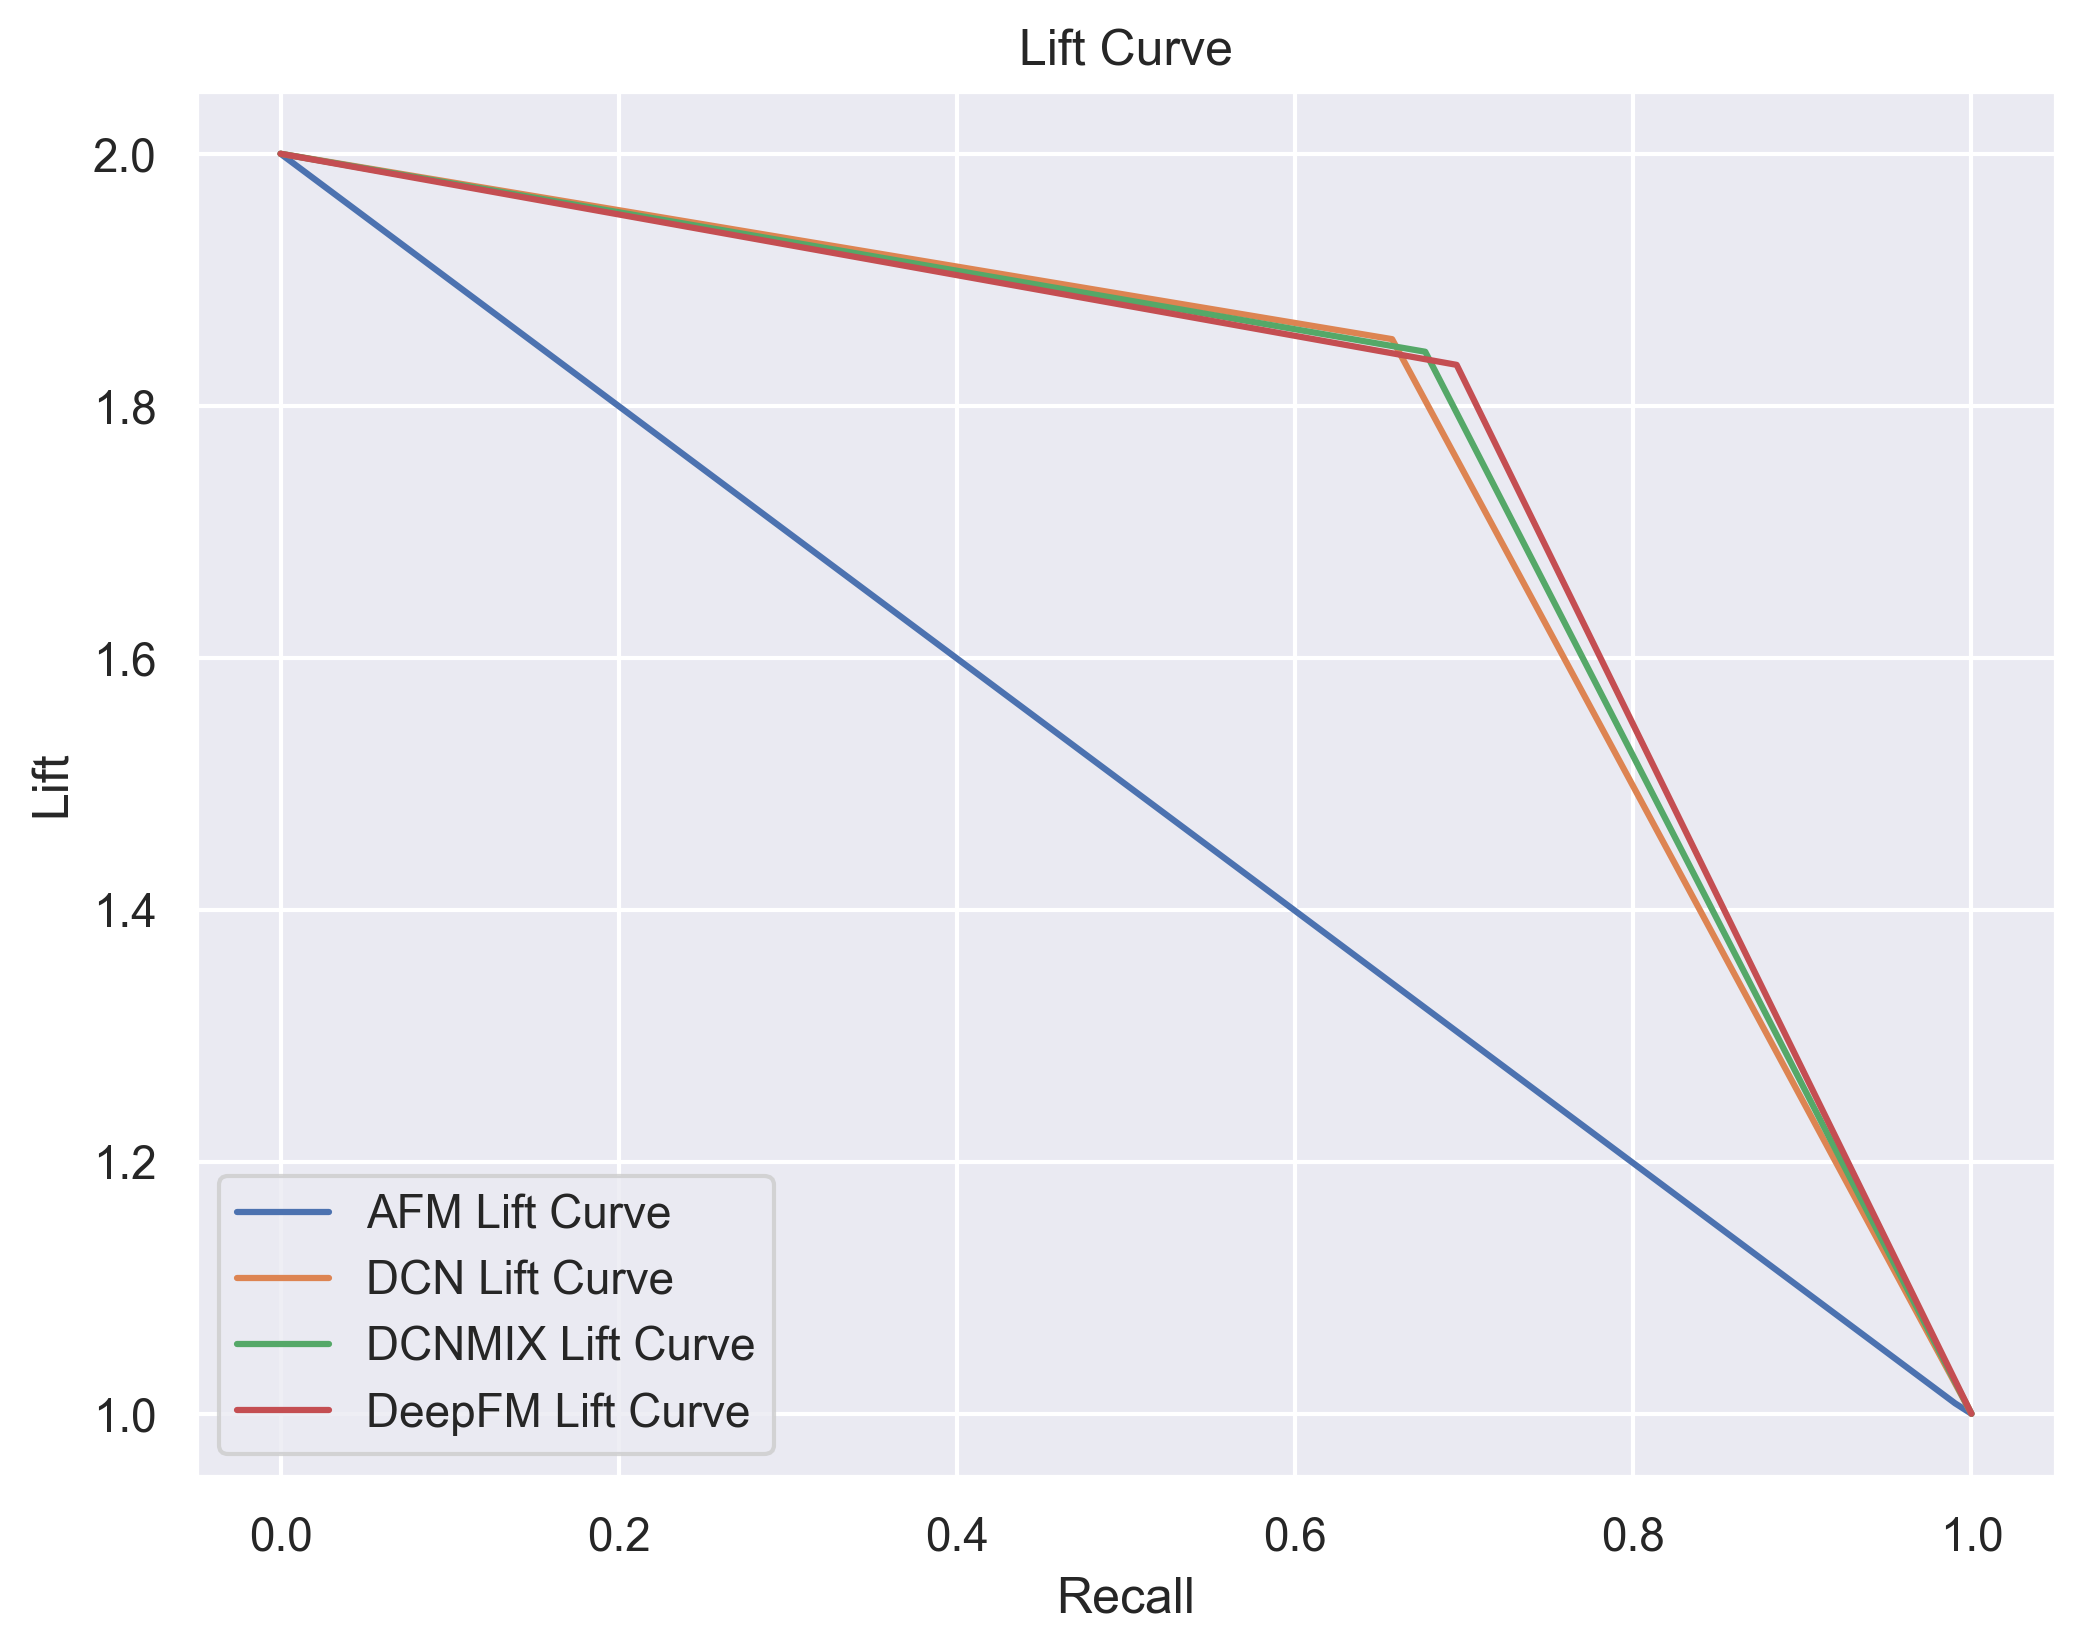

In [82]:
# 绘制Lift曲线
precision_DeepFM, recall_DeepFM, thresholds_DeepFM = precision_recall_curve(y_test, y_pred)
lift_DeepFM = precision_DeepFM / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
plt.plot(recall_DCN, lift_DCN, label='DCN Lift Curve')
plt.plot(recall_DCNMIX, lift_DCNMIX, label='DCNMIX Lift Curve')
plt.plot(recall_DeepFM, lift_DeepFM, label='DeepFM Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="DeepFMLift曲线.png")

<a id="12"></a>
### 4.6 xDeepFM
相比DeepFM可以更有效地捕捉特征之间的高阶交互关系
##### 模型拟合

In [83]:
model_xDeepFM = xDeepFM(feature_columns, feature_columns, task='binary')

model_xDeepFM.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy', 'auc'])
history = model_xDeepFM.fit(train_model_input, y_train.values, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

cpu
Train on 465313 samples, validate on 116329 samples, 909 steps per epoch



09it [03:10,  4.76it/s]

Epoch 1/10
227s - loss:  0.6140 - binary_crossentropy:  0.6140 - auc:  0.7268 - val_binary_crossentropy:  0.5957 - val_auc:  0.7503



09it [03:08,  4.82it/s]

Epoch 2/10
229s - loss:  0.5838 - binary_crossentropy:  0.5838 - auc:  0.7611 - val_binary_crossentropy:  0.5821 - val_auc:  0.7658



09it [03:15,  4.66it/s]

Epoch 3/10
231s - loss:  0.5762 - binary_crossentropy:  0.5762 - auc:  0.7684 - val_binary_crossentropy:  0.5805 - val_auc:  0.7717



09it [03:23,  4.46it/s]

Epoch 4/10
240s - loss:  0.5659 - binary_crossentropy:  0.5659 - auc:  0.7792 - val_binary_crossentropy:  0.5575 - val_auc:  0.7891



09it [03:27,  4.38it/s]

Epoch 5/10
244s - loss:  0.5243 - binary_crossentropy:  0.5243 - auc:  0.8153 - val_binary_crossentropy:  0.4779 - val_auc:  0.8475



09it [03:22,  4.49it/s]

Epoch 6/10
238s - loss:  0.4594 - binary_crossentropy:  0.4594 - auc:  0.8579 - val_binary_crossentropy:  0.4411 - val_auc:  0.8670



09it [03:09,  4.79it/s]

Epoch 7/10
225s - loss:  0.4334 - binary_crossentropy:  0.4334 - auc:  0.8700 - val_binary_crossentropy:  0.4295 - val_auc:  0.8709



09it [03:10,  4.77it/s]

Epoch 8/10
226s - loss:  0.4212 - binary_crossentropy:  0.4212 - auc:  0.8750 - val_binary_crossentropy:  0.4155 - val_auc:  0.8790



09it [03:08,  4.81it/s]

Epoch 9/10
224s - loss:  0.4125 - binary_crossentropy:  0.4125 - auc:  0.8789 - val_binary_crossentropy:  0.4044 - val_auc:  0.8811



09it [03:10,  4.78it/s]

Epoch 10/10
225s - loss:  0.4071 - binary_crossentropy:  0.4071 - auc:  0.8809 - val_binary_crossentropy:  0.4017 - val_auc:  0.8821


##### 预测

In [84]:
y_pred = model_xDeepFM.predict(test_model_input, batch_size=512)
y_pred = (y_pred > 0.5).astype(int)

##### 模型评估

In [85]:
# 评估
print("Accuracy:", accuracy_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.8042972448210016
Confusion Matrix:
 [[106674  17964]
 [ 30820  93818]]
AUC Score: 0.8042972448210016


##### 混淆矩阵

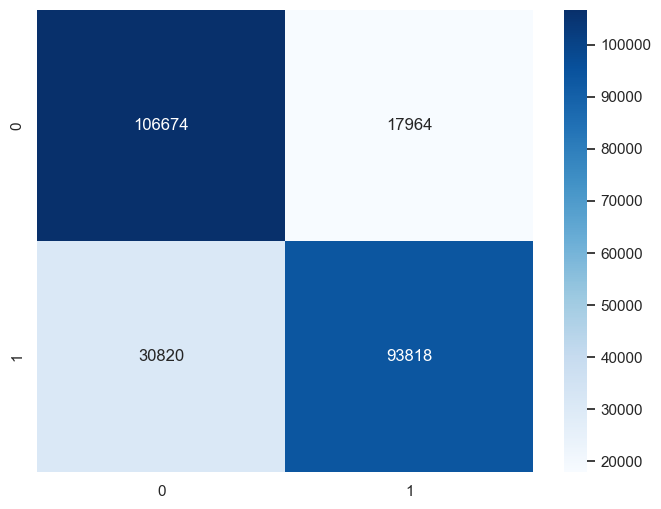

In [86]:
# 使用 seaborn 绘制混淆矩阵热图
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="xDeepFM混淆矩阵.png")

##### Lift曲线

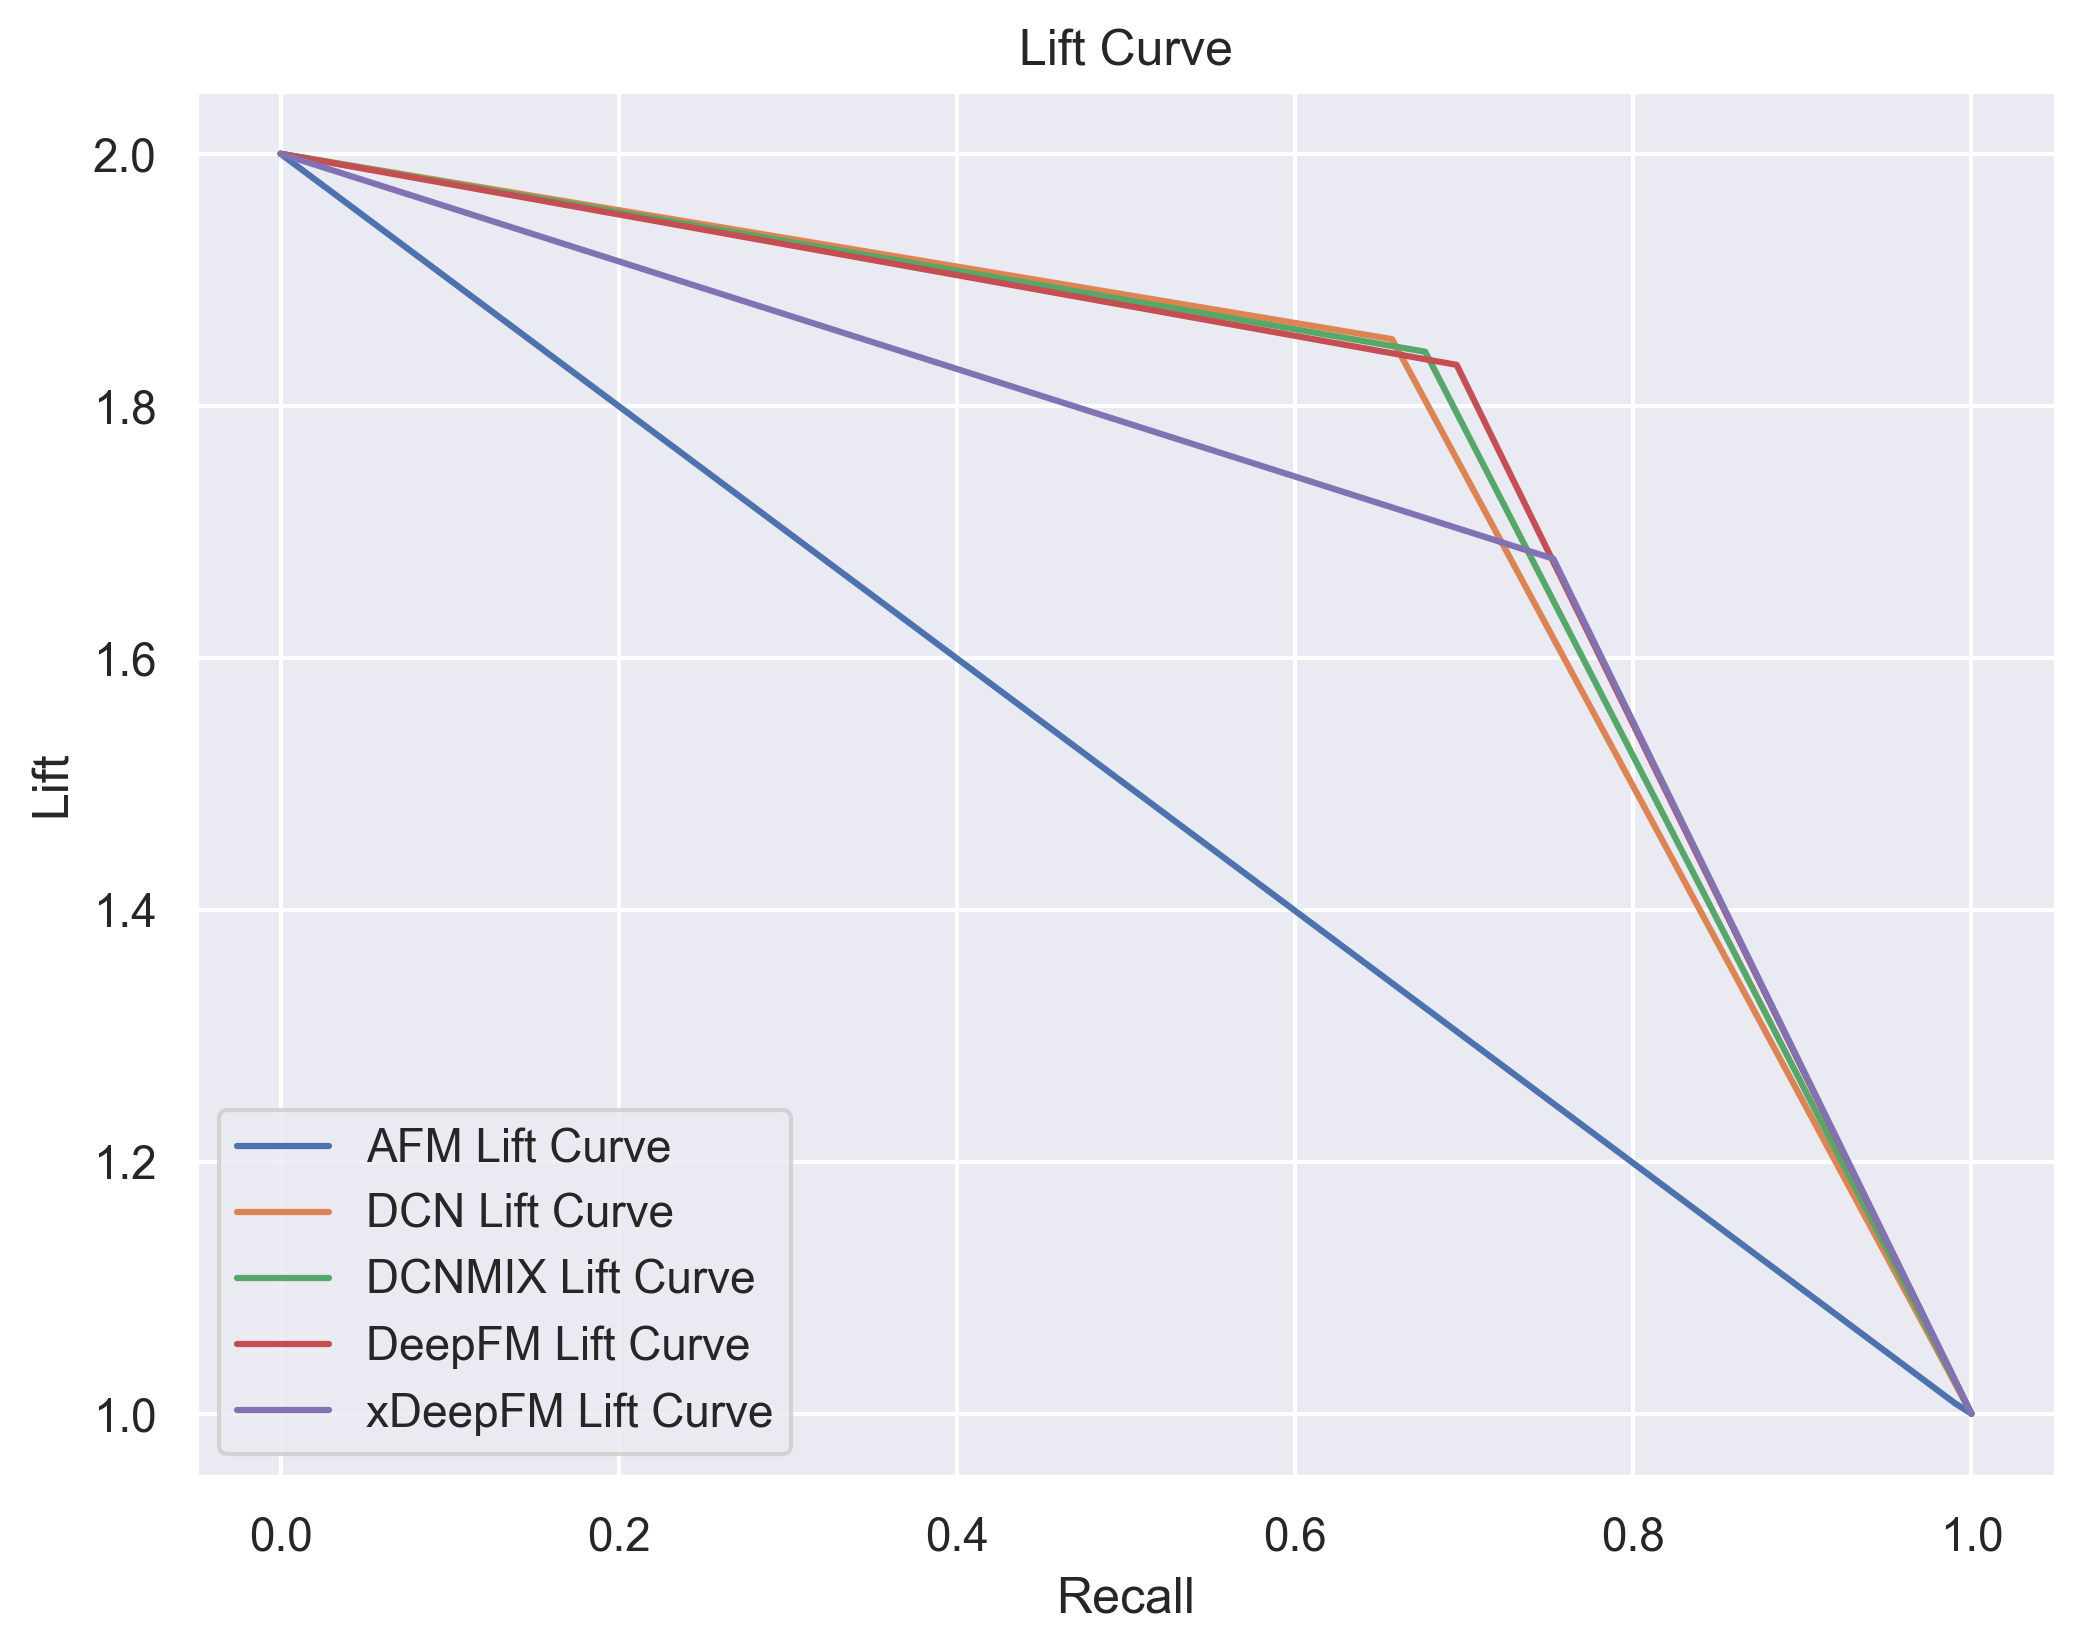

In [87]:
# 绘制 Lift 曲线
precision_xDeepFM, recall_xDeepFM, thresholds_xDeepFM = precision_recall_curve(y_test, y_pred)
lift_xDeepFM = precision_xDeepFM / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
plt.plot(recall_DCN, lift_DCN, label='DCN Lift Curve')
plt.plot(recall_DCNMIX, lift_DCNMIX, label='DCNMIX Lift Curve')
plt.plot(recall_DeepFM, lift_DeepFM, label='DeepFM Lift Curve')
plt.plot(recall_xDeepFM, lift_xDeepFM, label='xDeepFM Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="xDeepFMLift曲线.png")

<a id="13"></a>
### 4.7 AutoInt
主要由Embedding层和Multi-Head Attention层组成
##### 模型拟合

In [88]:
# 主要由Embedding层和Multi-Head Attention层组成
model_AutoInt = AutoInt(feature_columns, feature_columns, task='binary')

model_AutoInt.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy', 'auc'])
history = model_AutoInt.fit(train_model_input, y_train.values, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

cpu
Train on 465313 samples, validate on 116329 samples, 909 steps per epoch



09it [00:21, 41.55it/s]

Epoch 1/10
22s - loss:  0.6126 - binary_crossentropy:  0.6126 - auc:  0.7288 - val_binary_crossentropy:  0.5956 - val_auc:  0.7469



09it [00:20, 43.87it/s]

Epoch 2/10
22s - loss:  0.5881 - binary_crossentropy:  0.5881 - auc:  0.7562 - val_binary_crossentropy:  0.5917 - val_auc:  0.7530



09it [00:20, 43.62it/s]

Epoch 3/10
21s - loss:  0.5833 - binary_crossentropy:  0.5833 - auc:  0.7608 - val_binary_crossentropy:  0.5802 - val_auc:  0.7632



09it [00:21, 42.50it/s]

Epoch 4/10
22s - loss:  0.5730 - binary_crossentropy:  0.5730 - auc:  0.7720 - val_binary_crossentropy:  0.5594 - val_auc:  0.7856



09it [00:22, 40.99it/s]

Epoch 5/10
22s - loss:  0.5422 - binary_crossentropy:  0.5422 - auc:  0.8012 - val_binary_crossentropy:  0.5093 - val_auc:  0.8244



09it [00:21, 42.53it/s]

Epoch 6/10
22s - loss:  0.4643 - binary_crossentropy:  0.4643 - auc:  0.8529 - val_binary_crossentropy:  0.4378 - val_auc:  0.8661



09it [00:20, 43.96it/s]

Epoch 7/10
21s - loss:  0.4340 - binary_crossentropy:  0.4340 - auc:  0.8663 - val_binary_crossentropy:  0.4409 - val_auc:  0.8672



09it [00:21, 42.40it/s]

Epoch 8/10
22s - loss:  0.4257 - binary_crossentropy:  0.4257 - auc:  0.8695 - val_binary_crossentropy:  0.4159 - val_auc:  0.8745



09it [00:20, 43.97it/s]

Epoch 9/10
21s - loss:  0.4198 - binary_crossentropy:  0.4198 - auc:  0.8716 - val_binary_crossentropy:  0.4132 - val_auc:  0.8745



09it [00:20, 43.70it/s]

Epoch 10/10
22s - loss:  0.4165 - binary_crossentropy:  0.4165 - auc:  0.8733 - val_binary_crossentropy:  0.4142 - val_auc:  0.8746


##### 预测

In [89]:
# 预测
y_pred = model_AutoInt.predict(test_model_input, batch_size=512)
y_pred = (y_pred > 0.5).astype(int)

##### 模型评估

In [90]:
# 评估
print("Accuracy:", accuracy_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.8046101509972882
Confusion Matrix:
 [[116041   8597]
 [ 40109  84529]]
AUC Score: 0.8046101509972882


##### 混淆矩阵

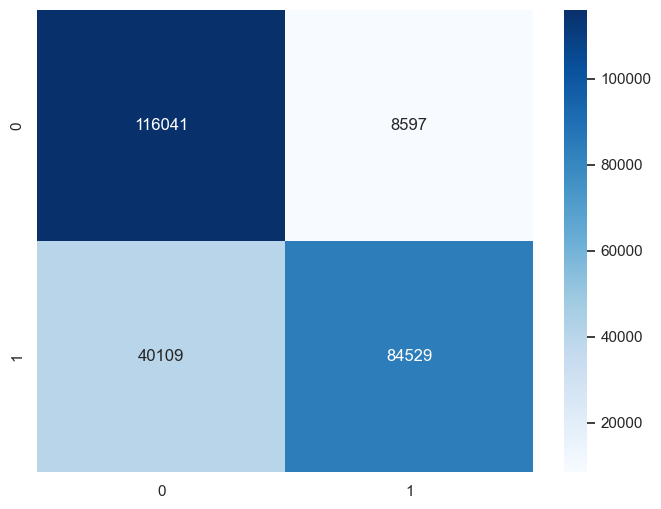

In [91]:
# 使用 seaborn 绘制混淆矩阵热图
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="AutoInt混淆矩阵.png")

##### Lift曲线

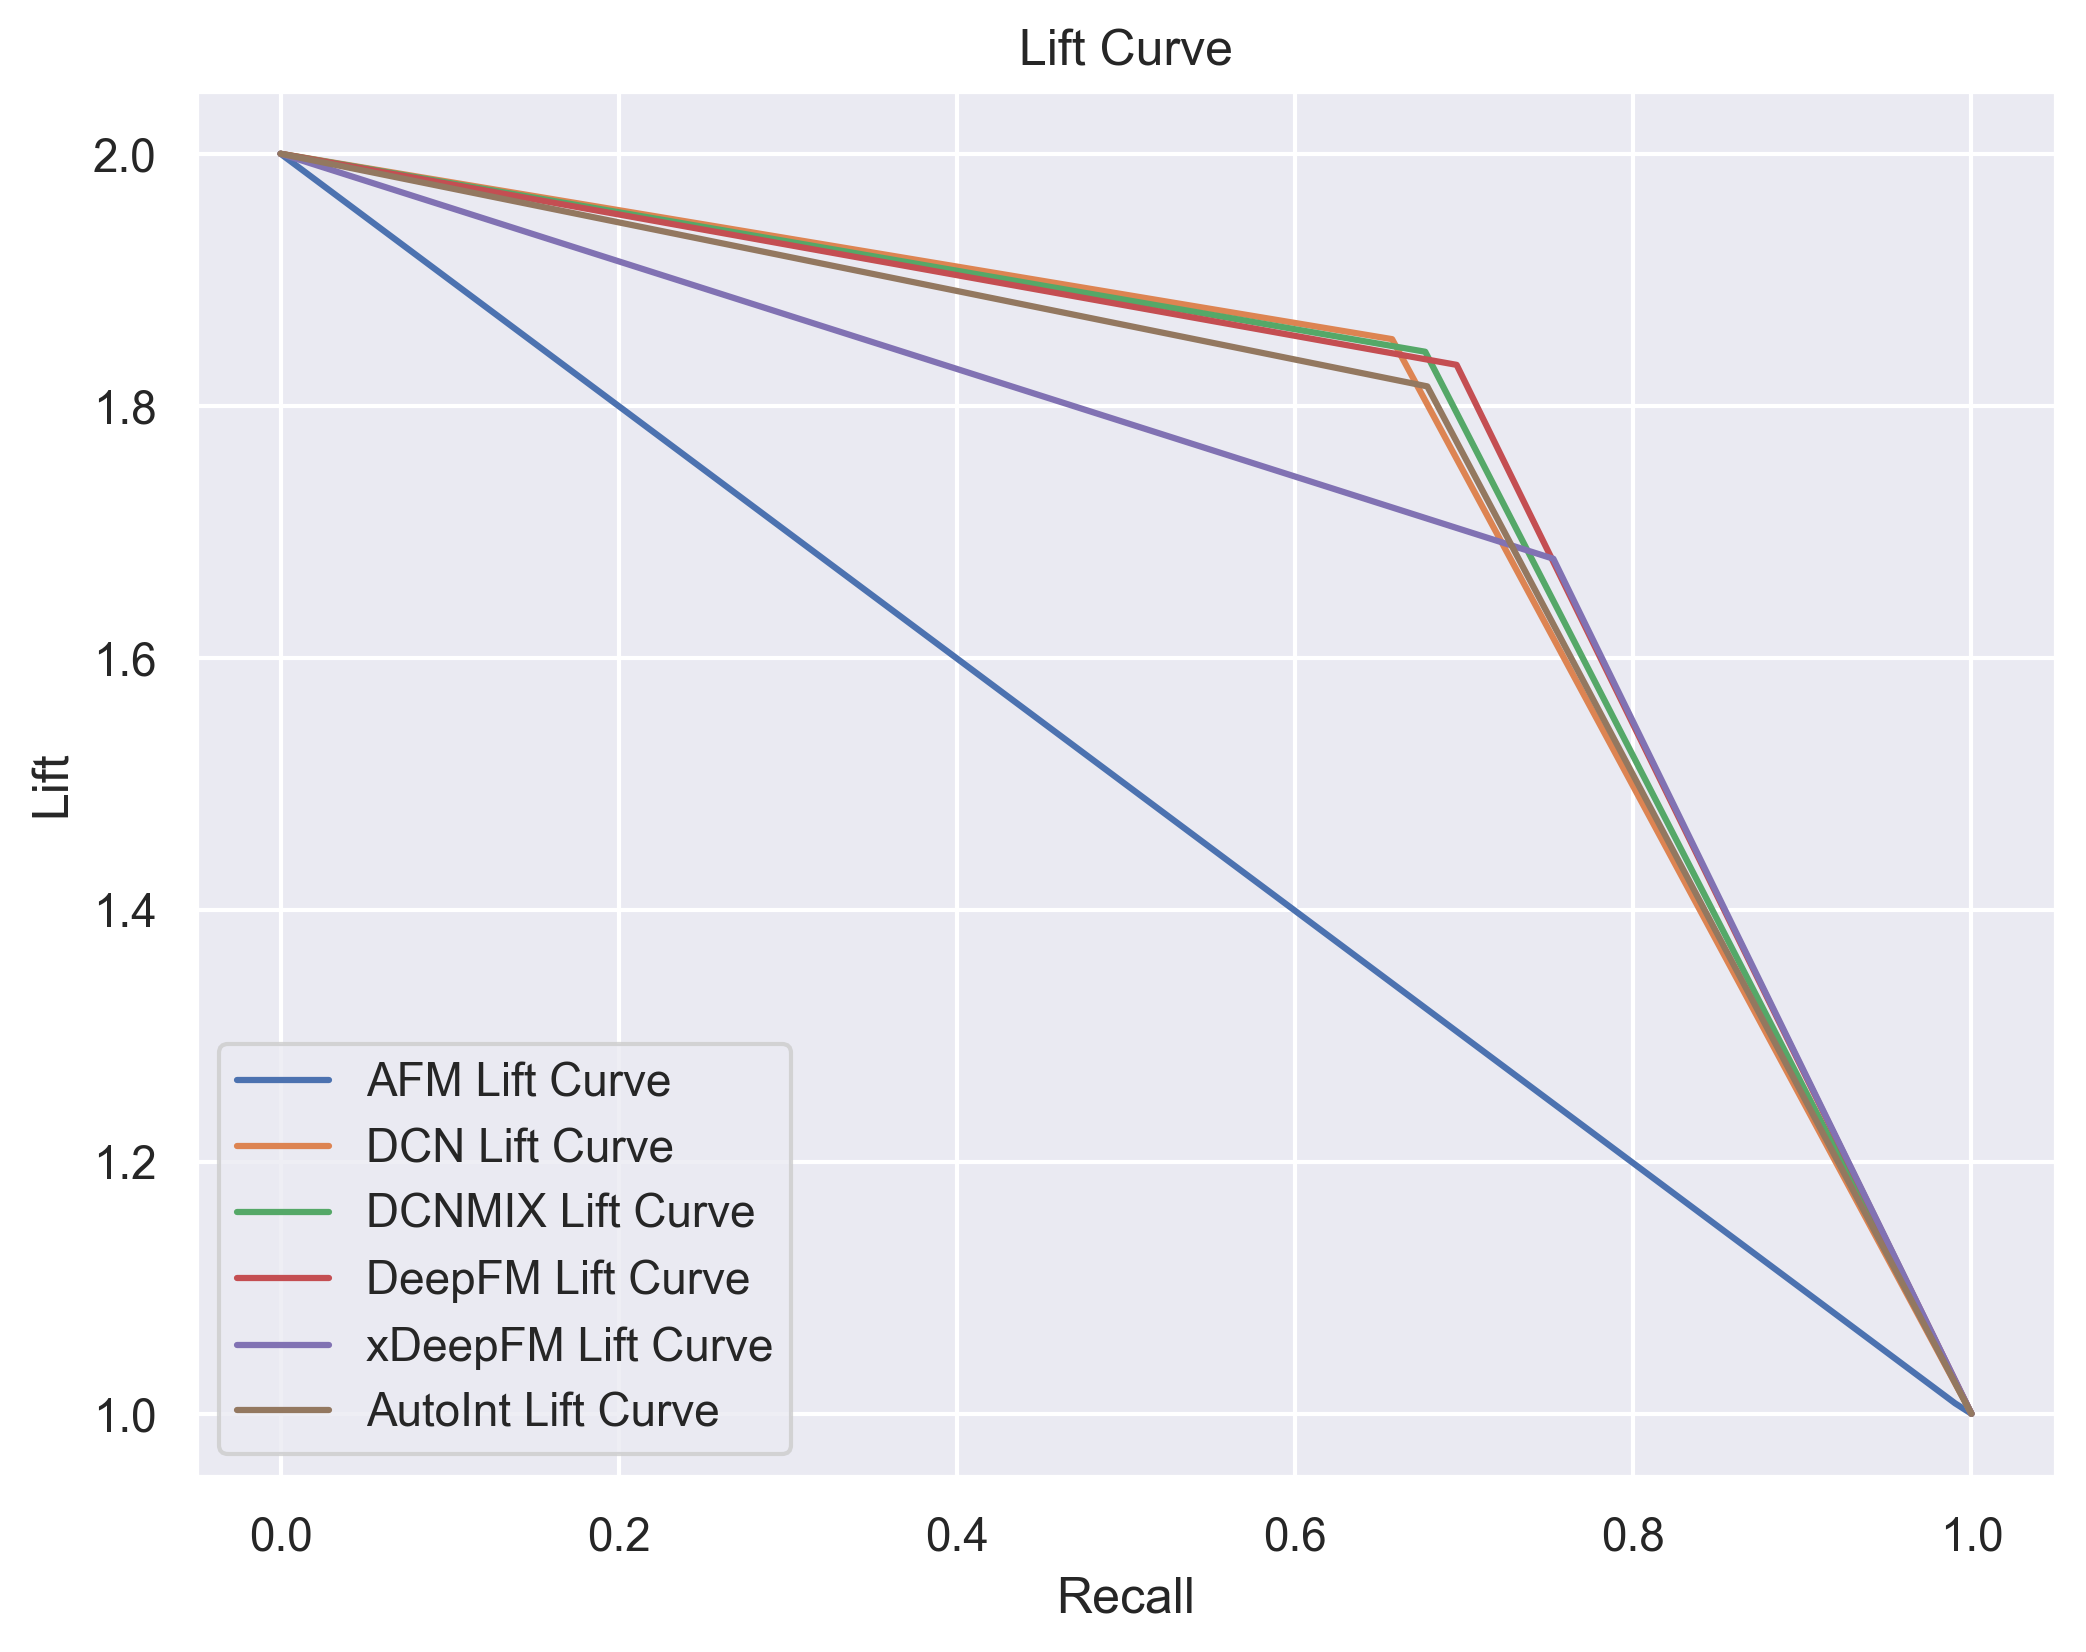

In [92]:
# 绘制 Lift 曲线
precision_AutoInt, recall_AutoInt, thresholds_AutoInt = precision_recall_curve(y_test, y_pred)
lift_AutoInt = precision_AutoInt / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
plt.plot(recall_DCN, lift_DCN, label='DCN Lift Curve')
plt.plot(recall_DCNMIX, lift_DCNMIX, label='DCNMIX Lift Curve')
plt.plot(recall_DeepFM, lift_DeepFM, label='DeepFM Lift Curve')
plt.plot(recall_xDeepFM, lift_xDeepFM, label='xDeepFM Lift Curve')
plt.plot(recall_AutoInt, lift_AutoInt, label='AutoInt Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="AutoIntLift曲线.png")

<a id="14"></a>
### 4.8 ONN
##### 模型拟合

In [93]:
## ONN
model_ONN = ONN(feature_columns, feature_columns, task='binary')

model_ONN.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy', 'auc'])
history = model_ONN.fit(train_model_input, y_train.values, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

cpu
Train on 465313 samples, validate on 116329 samples, 909 steps per epoch



09it [1:42:07,  6.74s/it] 

Epoch 1/10
6128s - loss:  0.7921 - binary_crossentropy:  0.5831 - auc:  0.7600 - val_binary_crossentropy:  0.5036 - val_auc:  0.8314



09it [2:48:53, 11.15s/it] 

Epoch 2/10
10134s - loss:  0.5048 - binary_crossentropy:  0.4540 - auc:  0.8568 - val_binary_crossentropy:  0.4372 - val_auc:  0.8669



09it [3:56:23, 15.60s/it]  

Epoch 3/10
14183s - loss:  0.4379 - binary_crossentropy:  0.4266 - auc:  0.8679 - val_binary_crossentropy:  0.4188 - val_auc:  0.8724



09it [01:51,  8.14it/s]

Epoch 4/10
112s - loss:  0.4204 - binary_crossentropy:  0.4182 - auc:  0.8716 - val_binary_crossentropy:  0.4098 - val_auc:  0.8753



09it [01:36,  9.43it/s]

Epoch 5/10
96s - loss:  0.4130 - binary_crossentropy:  0.4127 - auc:  0.8739 - val_binary_crossentropy:  0.4058 - val_auc:  0.8774



09it [01:38,  9.22it/s]

Epoch 6/10
99s - loss:  0.4096 - binary_crossentropy:  0.4096 - auc:  0.8755 - val_binary_crossentropy:  0.4036 - val_auc:  0.8788



09it [02:00,  7.57it/s]

Epoch 7/10
120s - loss:  0.4072 - binary_crossentropy:  0.4072 - auc:  0.8766 - val_binary_crossentropy:  0.4012 - val_auc:  0.8794



09it [02:09,  7.04it/s]

Epoch 8/10
129s - loss:  0.4052 - binary_crossentropy:  0.4052 - auc:  0.8776 - val_binary_crossentropy:  0.4018 - val_auc:  0.8792



09it [02:10,  6.99it/s]

Epoch 9/10
130s - loss:  0.4031 - binary_crossentropy:  0.4031 - auc:  0.8788 - val_binary_crossentropy:  0.3979 - val_auc:  0.8814



09it [01:52,  8.07it/s]

Epoch 10/10
113s - loss:  0.4012 - binary_crossentropy:  0.4012 - auc:  0.8797 - val_binary_crossentropy:  0.4018 - val_auc:  0.8811


##### 预测

In [94]:
# 预测
y_pred = model_ONN.predict(test_model_input, batch_size=512)
y_pred = (y_pred > 0.5).astype(int)

##### 模型评估

In [95]:
# 评估
print("Accuracy:", accuracy_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.8028089346748183
Confusion Matrix:
 [[119717   4921]
 [ 44234  80404]]
AUC Score: 0.8028089346748183


##### 混淆矩阵

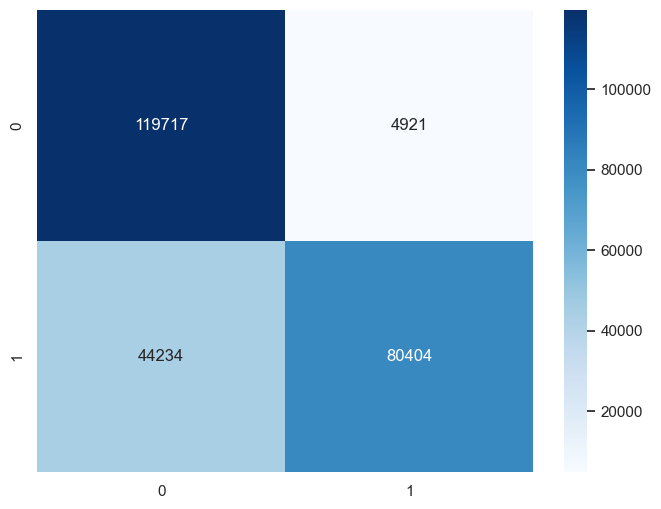

In [96]:
# 使用 seaborn 绘制混淆矩阵热图
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="ONN混淆矩阵.png")

##### Lift曲线

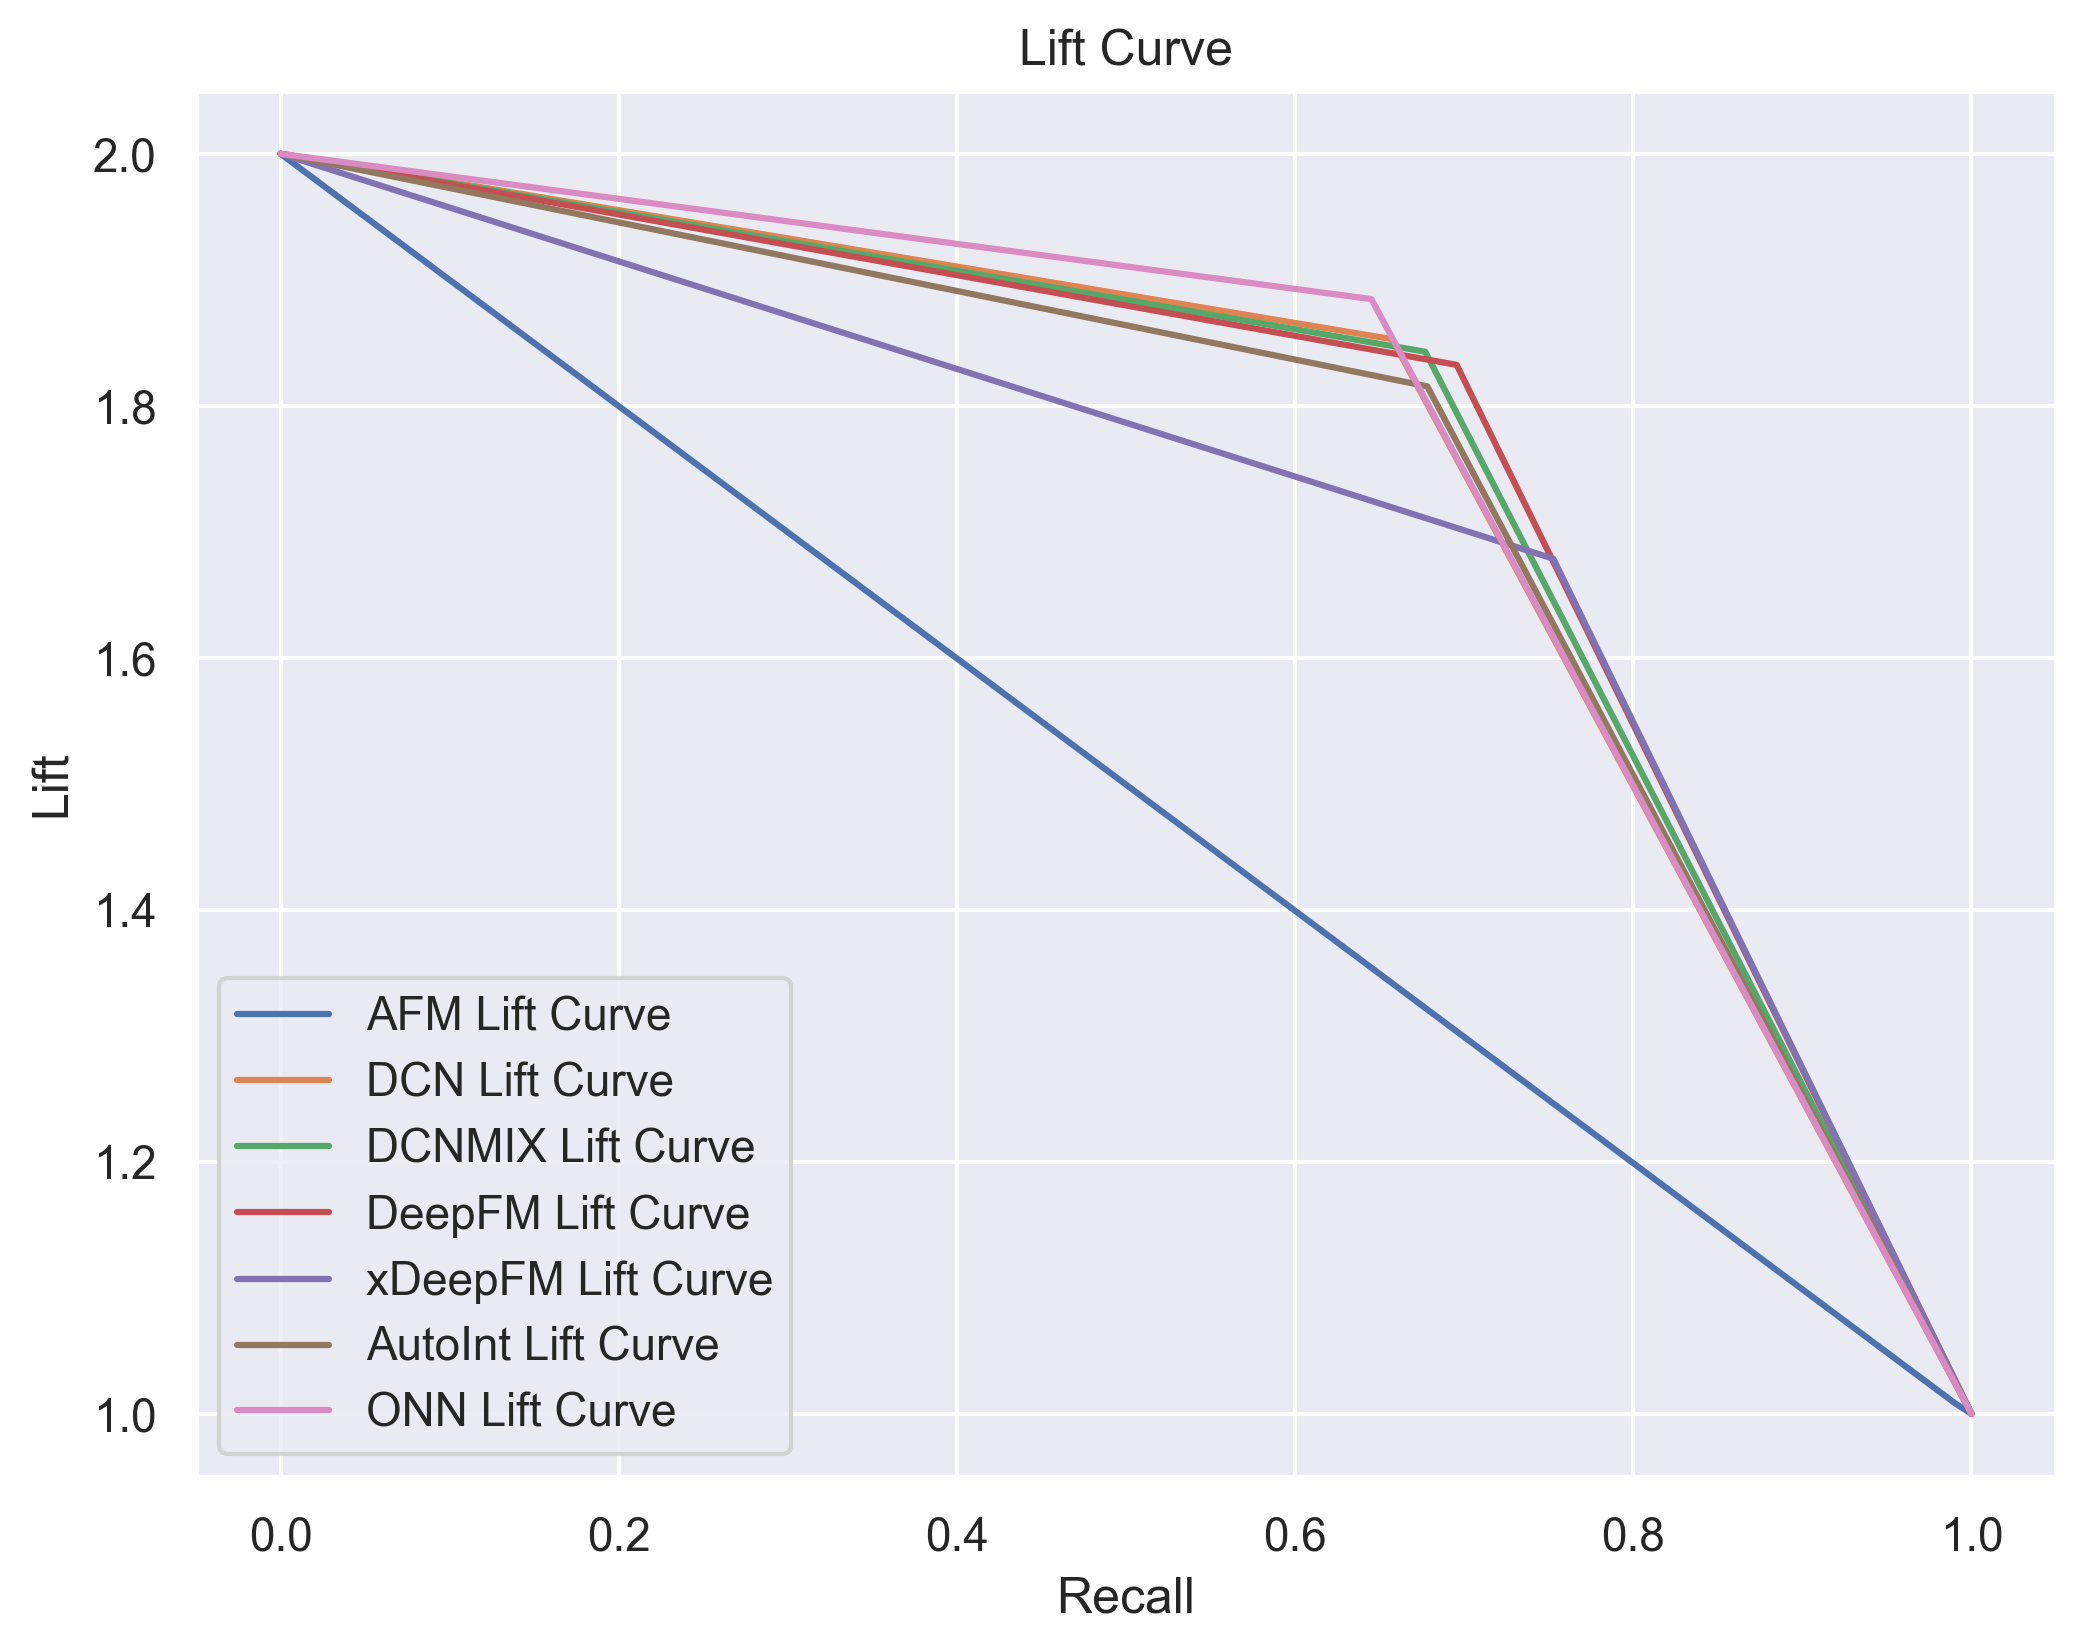

In [97]:
# 绘制 Lift 曲线
precision_ONN, recall_ONN, thresholds_ONN = precision_recall_curve(y_test, y_pred)
lift_ONN = precision_ONN / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
plt.plot(recall_DCN, lift_DCN, label='DCN Lift Curve')
plt.plot(recall_DCNMIX, lift_DCNMIX, label='DCNMIX Lift Curve')
plt.plot(recall_DeepFM, lift_DeepFM, label='DeepFM Lift Curve')
plt.plot(recall_xDeepFM, lift_xDeepFM, label='xDeepFM Lift Curve')
plt.plot(recall_AutoInt, lift_AutoInt, label='AutoInt Lift Curve')
plt.plot(recall_ONN, lift_ONN, label='ONN Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="ONNLift曲线.png")

<a id="15"></a>
### 4.9 FiBiNET
##### 模型拟合

In [98]:
## FiBiNET
model_FiBiNET = FiBiNET(feature_columns, feature_columns, task='binary')

model_FiBiNET.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy', 'auc'])
history = model_FiBiNET.fit(train_model_input, y_train.values, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

cpu
Train on 465313 samples, validate on 116329 samples, 909 steps per epoch



09it [00:25, 35.90it/s]

Epoch 1/10
25s - loss:  0.6168 - binary_crossentropy:  0.6168 - auc:  0.7216 - val_binary_crossentropy:  0.5973 - val_auc:  0.7471



09it [00:21, 41.38it/s]

Epoch 2/10
23s - loss:  0.5952 - binary_crossentropy:  0.5952 - auc:  0.7484 - val_binary_crossentropy:  0.5962 - val_auc:  0.7475



09it [00:25, 36.17it/s]

Epoch 3/10
25s - loss:  0.5921 - binary_crossentropy:  0.5921 - auc:  0.7517 - val_binary_crossentropy:  0.5885 - val_auc:  0.7550



09it [00:26, 34.83it/s]

Epoch 4/10
26s - loss:  0.5805 - binary_crossentropy:  0.5805 - auc:  0.7654 - val_binary_crossentropy:  0.5726 - val_auc:  0.7749



09it [00:23, 37.98it/s]

Epoch 5/10
24s - loss:  0.5682 - binary_crossentropy:  0.5682 - auc:  0.7786 - val_binary_crossentropy:  0.5633 - val_auc:  0.7833



09it [00:25, 35.53it/s]

Epoch 6/10
26s - loss:  0.5611 - binary_crossentropy:  0.5611 - auc:  0.7849 - val_binary_crossentropy:  0.5555 - val_auc:  0.7883



09it [00:23, 39.41it/s]

Epoch 7/10
23s - loss:  0.5518 - binary_crossentropy:  0.5518 - auc:  0.7925 - val_binary_crossentropy:  0.5466 - val_auc:  0.7958



09it [00:22, 39.74it/s]

Epoch 8/10
23s - loss:  0.5420 - binary_crossentropy:  0.5420 - auc:  0.8007 - val_binary_crossentropy:  0.5394 - val_auc:  0.8036



09it [00:22, 40.27it/s]

Epoch 9/10
23s - loss:  0.5322 - binary_crossentropy:  0.5322 - auc:  0.8085 - val_binary_crossentropy:  0.5302 - val_auc:  0.8112



09it [00:22, 40.09it/s]

Epoch 10/10
23s - loss:  0.5239 - binary_crossentropy:  0.5239 - auc:  0.8146 - val_binary_crossentropy:  0.5172 - val_auc:  0.8197


##### 预测

In [99]:
# 预测
y_pred = model_FiBiNET.predict(test_model_input, batch_size=512)
y_pred = (y_pred > 0.5).astype(int)

##### 模型评估

In [100]:
# 评估
print("Accuracy:", accuracy_score(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", roc_auc_score(y_test, y_pred))

Accuracy: 0.7403841525056564
Confusion Matrix:
 [[94168 30470]
 [34246 90392]]
AUC Score: 0.7403841525056564


##### 混淆矩阵

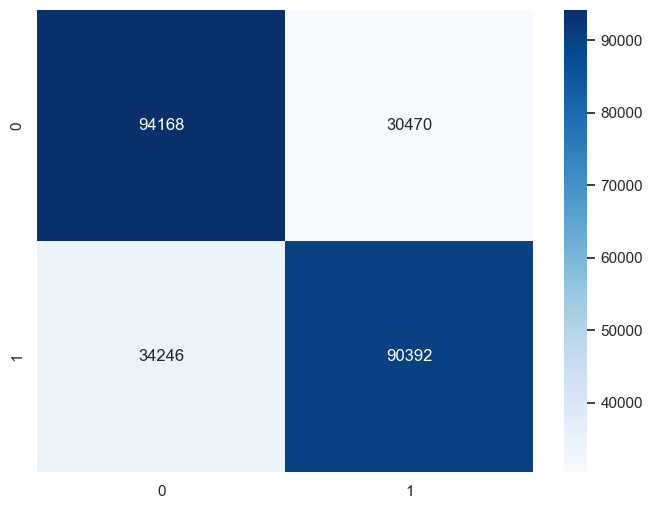

In [101]:
# 使用 seaborn 绘制混淆矩阵热图
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="FiBiNET混淆矩阵.png")

##### Lift曲线

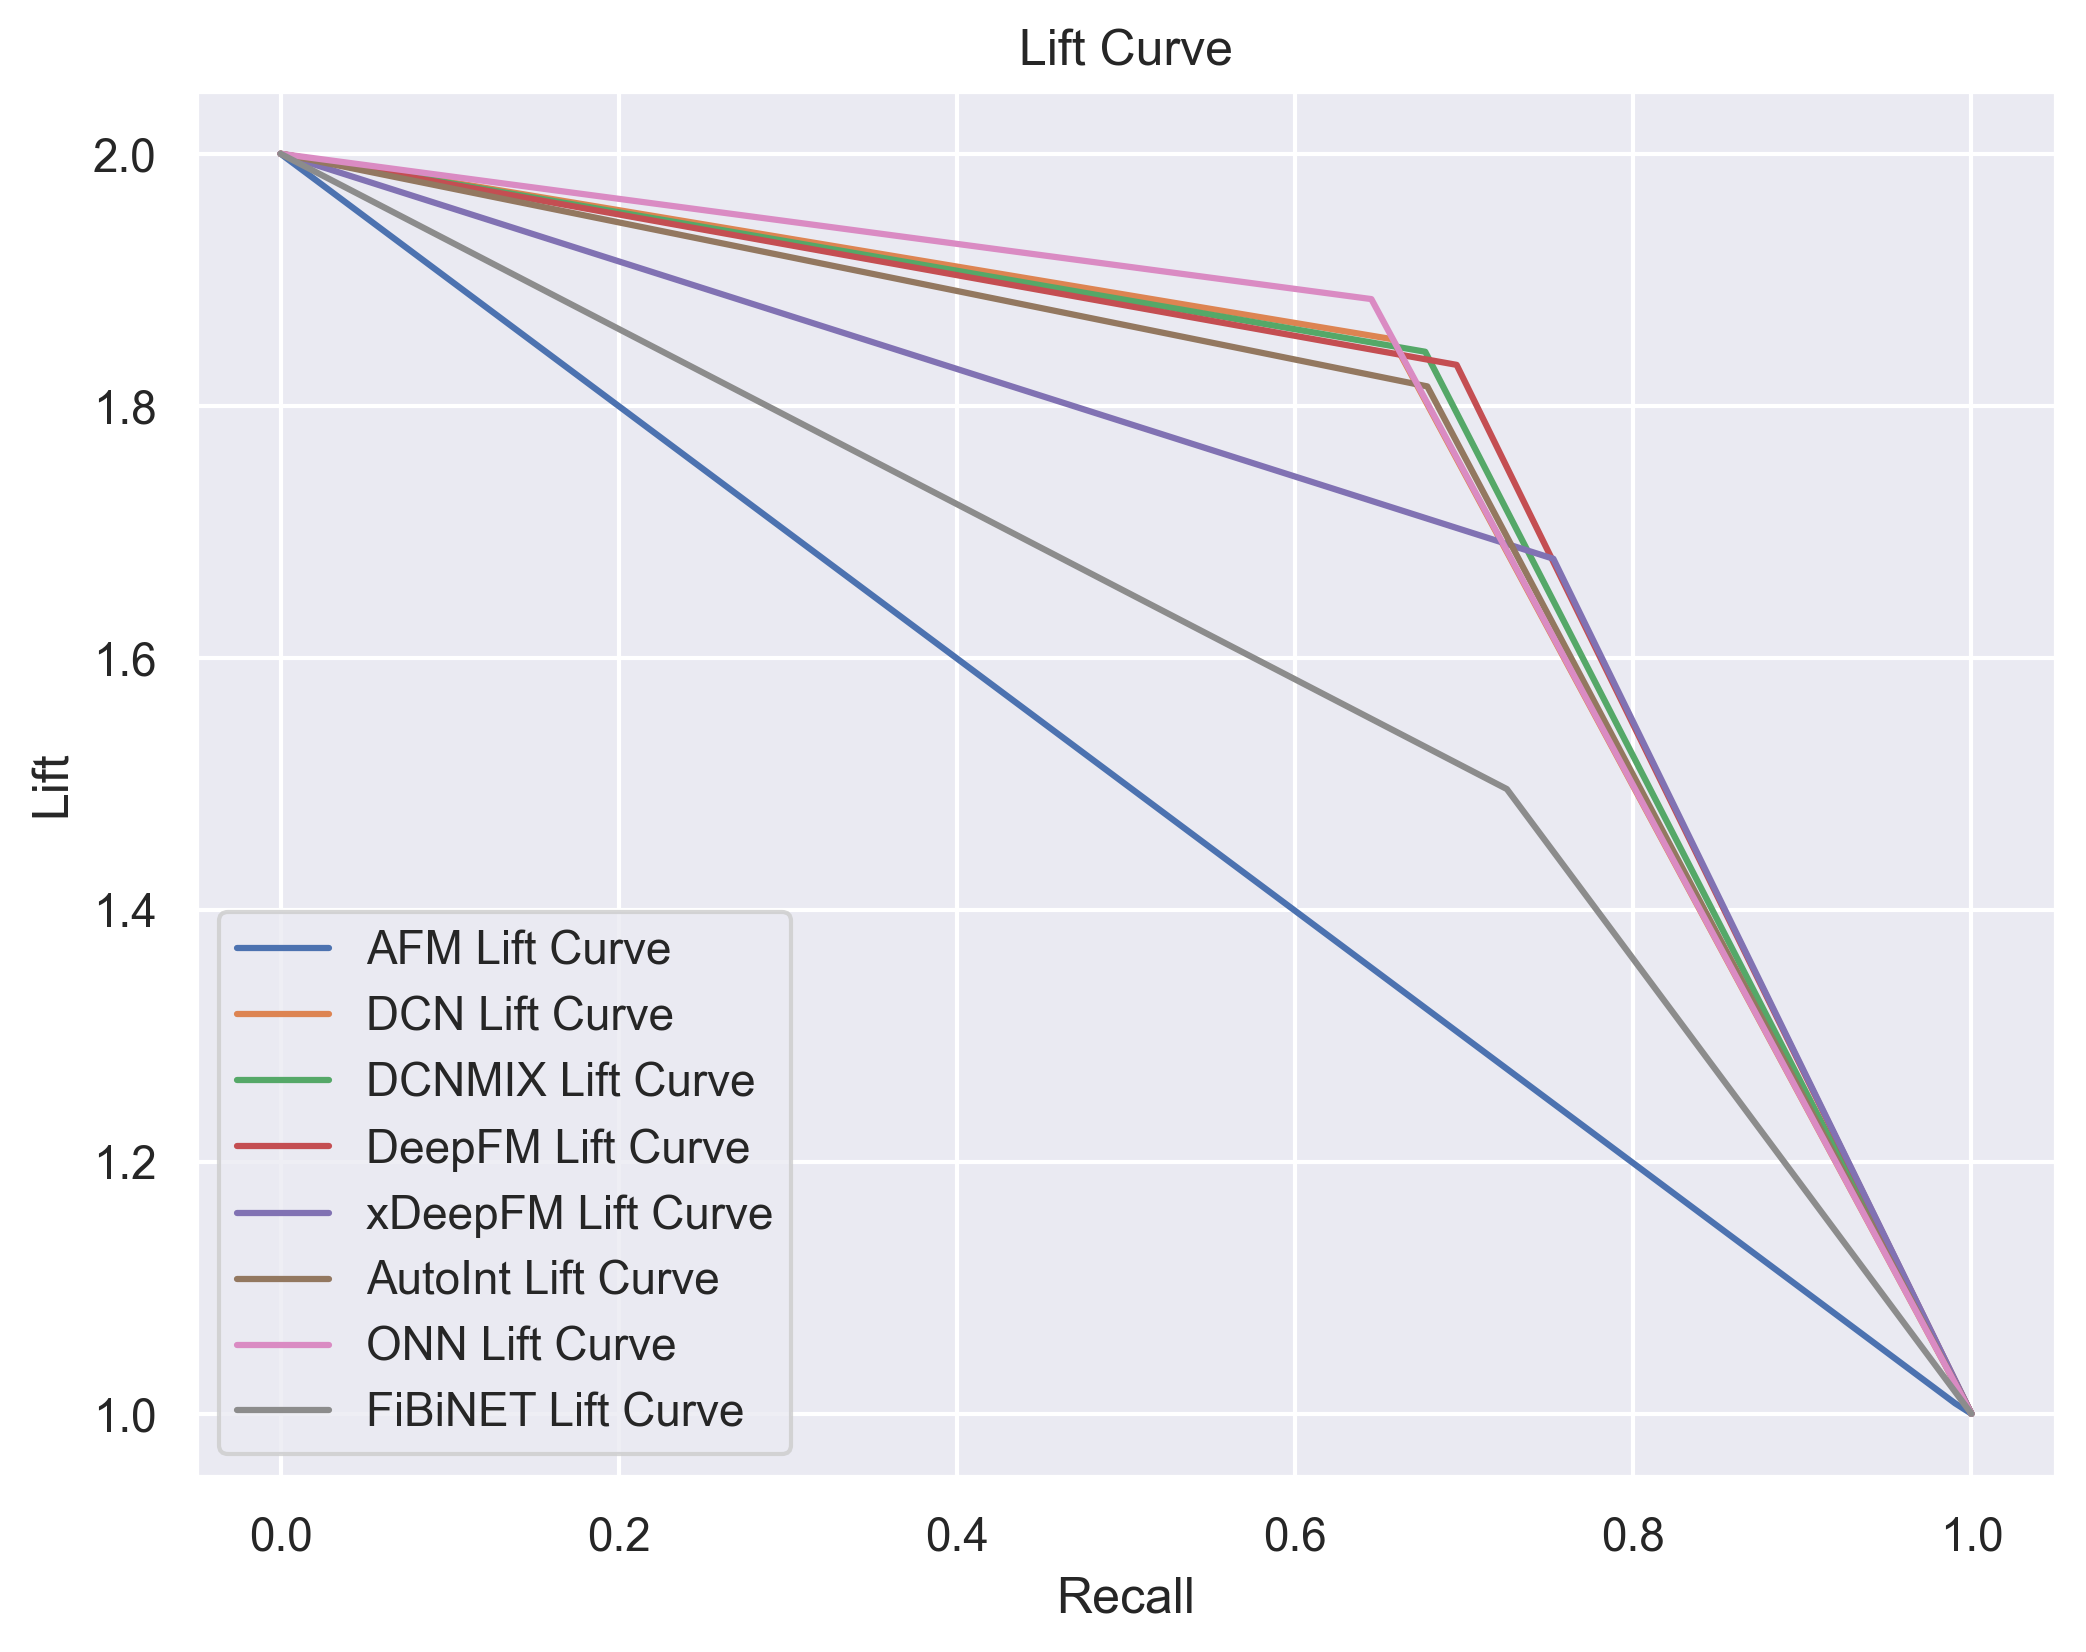

In [102]:
# 绘制 Lift 曲线
precision_FiBiNET, recall_FiBiNET, thresholds_FiBiNET = precision_recall_curve(y_test, y_pred)
lift_FiBiNET = precision_FiBiNET / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
plt.plot(recall_DCN, lift_DCN, label='DCN Lift Curve')
plt.plot(recall_DCNMIX, lift_DCNMIX, label='DCNMIX Lift Curve')
plt.plot(recall_DeepFM, lift_DeepFM, label='DeepFM Lift Curve')
plt.plot(recall_xDeepFM, lift_xDeepFM, label='xDeepFM Lift Curve')
plt.plot(recall_AutoInt, lift_AutoInt, label='AutoInt Lift Curve')
plt.plot(recall_ONN, lift_ONN, label='ONN Lift Curve')
plt.plot(recall_FiBiNET, lift_FiBiNET, label='FiBiNET Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc="lower left")
plt.savefig(fname="FiBiNETLift曲线.png")

## 五、全模型对比
对比之前用到的全部机器学习和深度学习模型

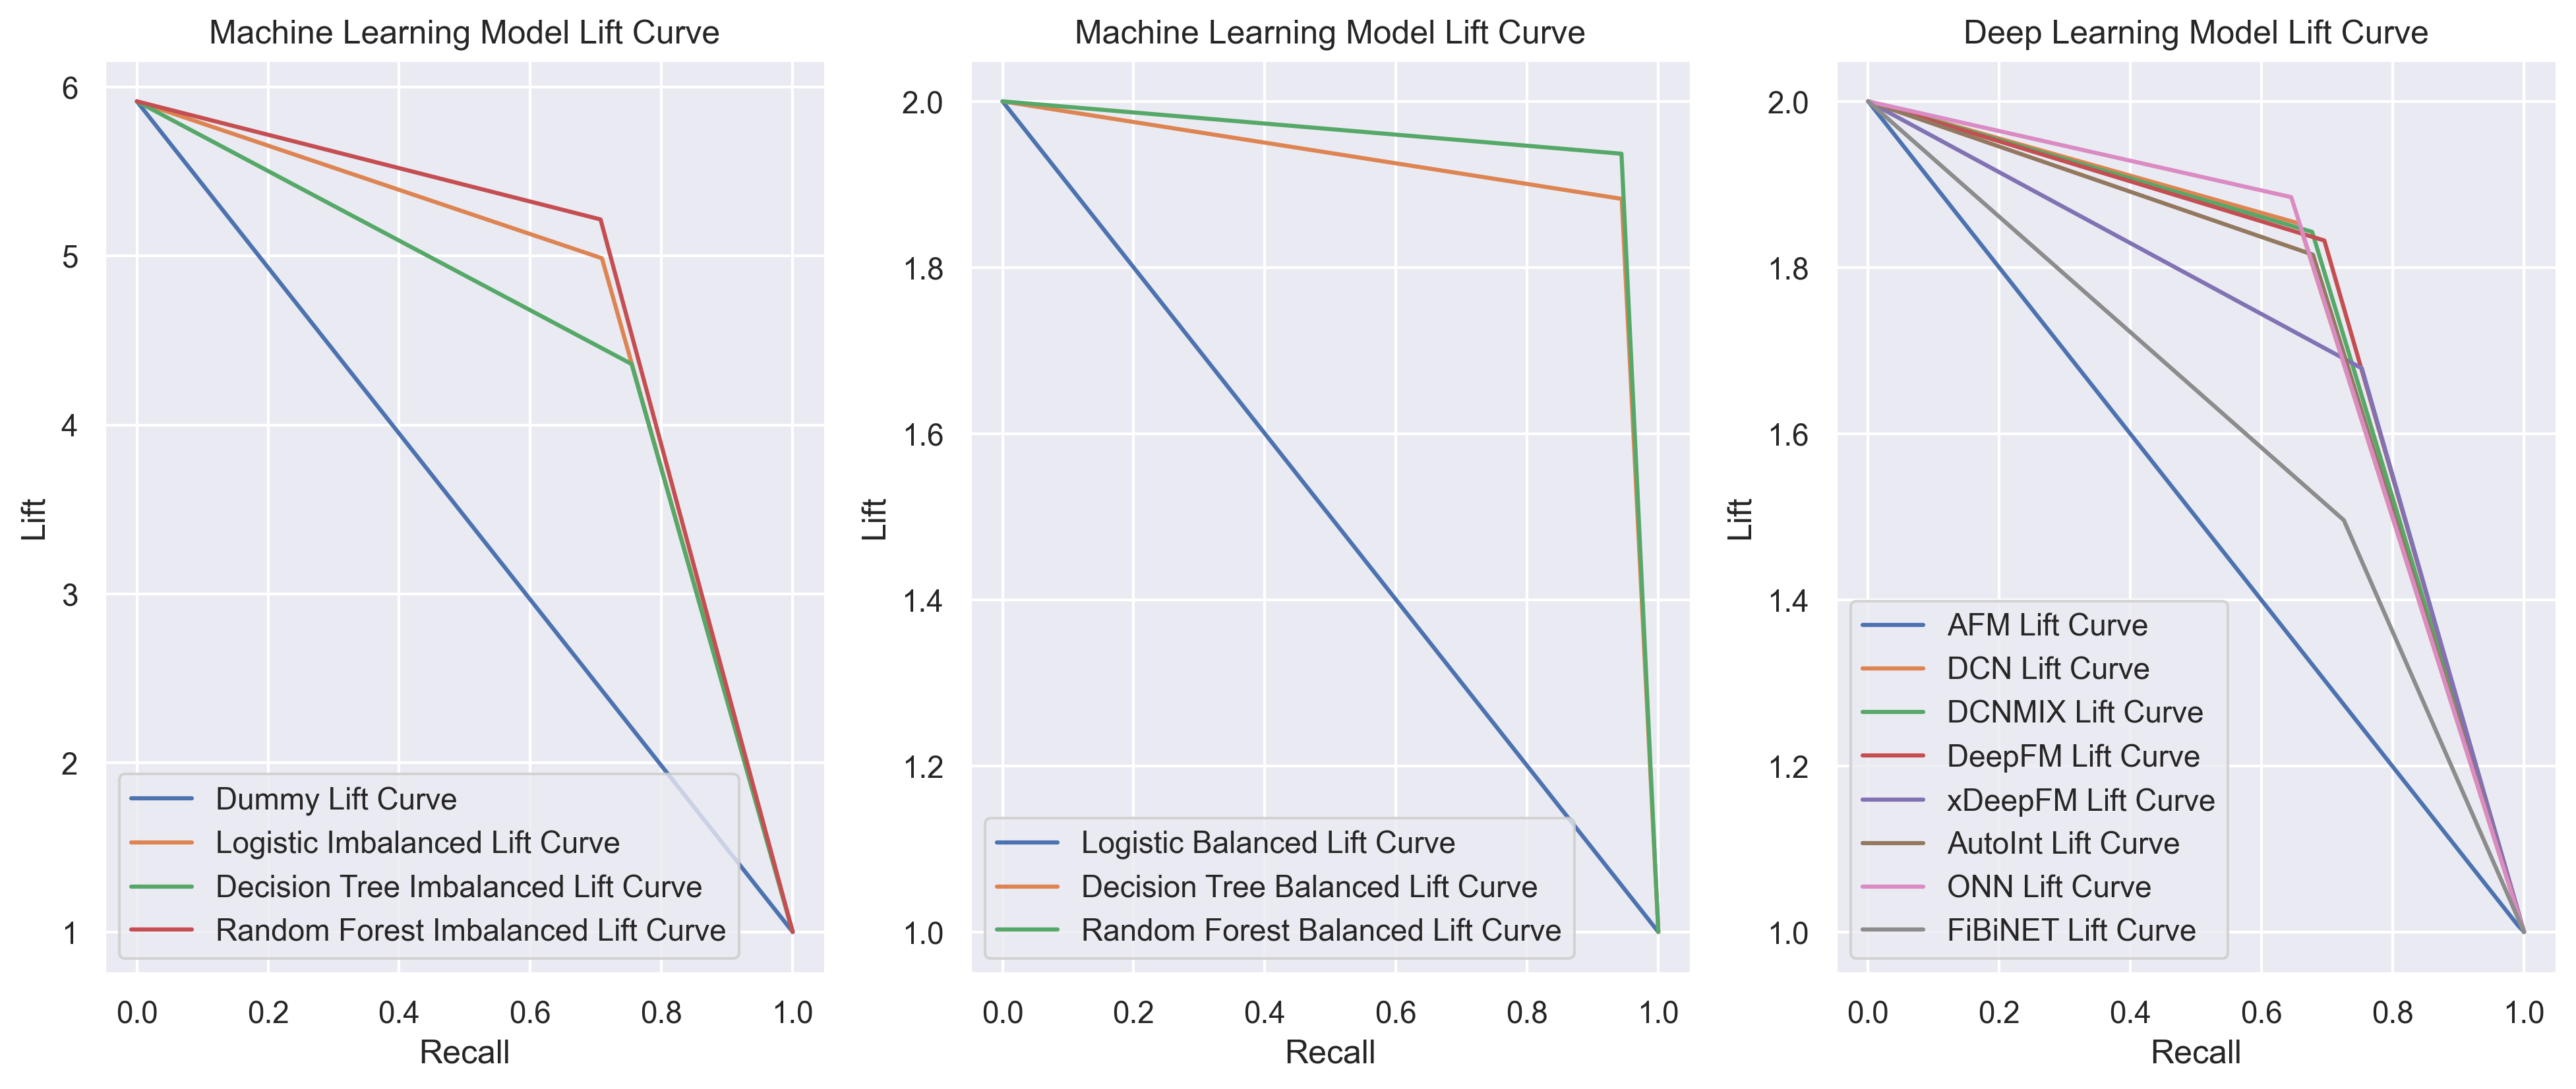

In [105]:
## 全模型对比
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), dpi=300)

# 传统机器学习模型（Imbalanced）
ax1.plot(recall_Dummy, lift_Dummy, label='Dummy Lift Curve')
ax1.plot(recall_LI, lift_LI, label='Logistic Imbalanced Lift Curve')
ax1.plot(recall_DI, lift_DI, label='Decision Tree Imbalanced Lift Curve')
ax1.plot(recall_RI, lift_RI, label='Random Forest Imbalanced Lift Curve')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Lift')
ax1.set_title('Machine Learning Model Lift Curve')
ax1.legend(loc="lower left")

# 传统机器学习模型（Balanced）
ax2.plot(recall_LB, lift_LB, label='Logistic Balanced Lift Curve')
ax2.plot(recall_DB, lift_DB, label='Decision Tree Balanced Lift Curve')
ax2.plot(recall_RB, lift_RB, label='Random Forest Balanced Lift Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Lift')
ax2.set_title('Machine Learning Model Lift Curve')
ax2.legend(loc="lower left")

# 深度学习模型
ax3.plot(recall_AFM, lift_AFM, label='AFM Lift Curve')
ax3.plot(recall_DCN, lift_DCN, label='DCN Lift Curve')
ax3.plot(recall_DCNMIX, lift_DCNMIX, label='DCNMIX Lift Curve')
ax3.plot(recall_DeepFM, lift_DeepFM, label='DeepFM Lift Curve')
ax3.plot(recall_xDeepFM, lift_xDeepFM, label='xDeepFM Lift Curve')
ax3.plot(recall_AutoInt, lift_AutoInt, label='AutoInt Lift Curve')
ax3.plot(recall_ONN, lift_ONN, label='ONN Lift Curve')
ax3.plot(recall_FiBiNET, lift_FiBiNET, label='FiBiNET Lift Curve')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Lift')
ax3.set_title('Deep Learning Model Lift Curve')
ax3.legend(loc="lower left")

plt.savefig(fname="全模型对比.png")

实验结果表明做了平衡处理的数据效果有显著提升，机器学习模型表现最好的是Random Forest，根据交叉验证结果来看没有过拟合，深度学习的CTR模型中表现最好的是ONN，其次是DeepFM，但结果似乎不如机器学习，查了一下可能是数据更适合用机器学习（维度问题）